In [1]:
import os
# set GPU number. This might work for several framework such as PyTorch, TensorFlow, Keras
gpu_id = '0'
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_id

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# sys.path.append('../../loglizer')
    
# from loglizer import dataloader
# from loglizer.preprocessing import Vectorizer, Iterator
import sys
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import Dataset
import torch.utils.data as Data
from torch.autograd import Variable
import pickle as pkl
import argparse
import time
import copy
import torchvision.transforms as transforms
import torchvision
import random
from collections import OrderedDict
from PIL import Image

import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from collections import defaultdict

from torch.nn.utils import clip_grad_norm_
from torch.distributions.laplace import Laplace

# from opacus import PrivacyEngine
# from opacus.layers import DPLSTM
from _utils import clip_generator, add_noise_generator

In [4]:
# struct_log = '../data/HDFS/HDFS.log_structured.csv' # The structured log file

#初始參數
class Parser():
    def __init__(self):
        self.mode = 'fedavg'  #FedBN,FedAvg,fedprox,fedopt,fedadagrad,fedadam 待加入scoffold
        #所有方法都有使用Fedbn
        self.beta_1 = 0.9
        self.beta_2 = 0.99 #b1,b2 for adaptive opt
        self.tau = 1e-2
        self.batch = 32
        self.lr = 1e-1
        self.server_lr = 1e-1
        self.server_momentum = 0.5
        self.client_momentum = 0.9 # 0 is fedavg others is fedavgm
        self.no_cuda = False
        self.seed = 1
        self.client_num = 5
        self.wk_iters = 1 # training
        self.num_workers = 2 # dataloader
        self.mu = 1e-3
        self.iters = 50 #epochs
        self.local_epochs = 10
        self.server_opt = 'sgd'
        self.percent = 1
#         self.early_stop = 500
        self.window_size = 10
        self.train_ratio = 0.5
        self.split_type='sequential' # sequential, uniform
        self.max_grad_norm = 1.0
        
args = Parser()

use_cuda = not args.no_cuda and torch.cuda.is_available()
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed) 
random.seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

group = {'noise_scale':0.08, 'norm_bound':1.5}
# 0 0.01 0.03 0.05 0.07 0.10

In [5]:
sys.path.append('../')
from logdeep.tools.predict_sl_dp import Predicter
from logdeep.tools.train_sl_dp import Trainer
from logdeep.tools.utils import *

# Config Parameters

options = dict()
options['data_dir'] = '../data/'
options['window_size'] = 10
options['device'] = device

# Smaple
options['sample'] = "sliding_window"
options['window_size'] = 10  # if fix_window

# Features
options['sequentials'] = True
options['quantitatives'] = True
options['semantics'] = False
options['feature_num'] = sum(
    [options['sequentials'], options['quantitatives'], options['semantics']])

# Model
options['input_size'] = 1
options['hidden_size'] = 64
options['num_layers'] = 2
options['num_classes'] = 28

# Train
options['batch_size'] = 2048
options['accumulation_step'] = 1

options['optimizer'] = 'adam'
options['lr'] = 1e-2
options['max_epoch'] = args.local_epochs
options['lr_step'] = (300, 350)
options['lr_decay_ratio'] = 0.1

options['resume_path'] = None
options['model_name'] = "loganomaly"
options['save_dir'] = "../result/loganomaly/"

# Predict
options['model_path'] = "../result/loganomaly/loganomaly_last.pth"
options['num_candidates'] = 9
options['use_dp'] = False

seed_everything(seed=1234)


def train():
    trainer = Trainer(Model, options)
    trainer.start_train()


def predict():
    predicter = Predicter(Model, options)
    predicter.predict_unsupervised()

# Preprocessing

In [6]:
class loganomaly(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out
    
class loganomaly_1st(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_1st, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
#         self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, device):
        input0, input1 = features[0], features[1]

        h0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)
        c0_0 = torch.zeros(self.num_layers, input0.size(0),
                           self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (h0_0, c0_0))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, (outpreh, outprec) = self.lstm1(input1, (h0_1, c0_1))
#         multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
#         out = self.fc(multi_out)
        return out1, outpreh, outprec


class loganomaly_2nd(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_keys):
        super(loganomaly_2nd, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm0 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.lstm1 = nn.LSTM(input_size,
                             hidden_size,
                             num_layers,
                             batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_keys)
        self.attention_size = self.hidden_size

        self.w_omega = Variable(
            torch.zeros(self.hidden_size, self.attention_size))
        self.u_omega = Variable(torch.zeros(self.attention_size))

        self.sequence_length = 28

    def attention_net(self, lstm_output):
        output_reshape = torch.Tensor.reshape(lstm_output,
                                              [-1, self.hidden_size])
        attn_tanh = torch.tanh(torch.mm(output_reshape, self.w_omega))
        attn_hidden_layer = torch.mm(
            attn_tanh, torch.Tensor.reshape(self.u_omega, [-1, 1]))
        exps = torch.Tensor.reshape(torch.exp(attn_hidden_layer),
                                    [-1, self.sequence_length])
        alphas = exps / torch.Tensor.reshape(torch.sum(exps, 1), [-1, 1])
        alphas_reshape = torch.Tensor.reshape(alphas,
                                              [-1, self.sequence_length, 1])
        state = lstm_output
        attn_output = torch.sum(state * alphas_reshape, 1)
        return attn_output

    def forward(self, features, hPrevious, cPrevious, device):
        input0, input1 = features[0], features[1]

#         h0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)
#         c0_0 = torch.zeros(self.num_layers, input0.size(0),
#                            self.hidden_size).to(device)

        out0, _ = self.lstm0(input0, (hPrevious, cPrevious))

        h0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)
        c0_1 = torch.zeros(self.num_layers, input1.size(0),
                           self.hidden_size).to(device)

        out1, _ = self.lstm1(input1, (h0_1, c0_1))
        multi_out = torch.cat((out0[:, -1, :], out1[:, -1, :]), -1)
        out = self.fc(multi_out)
        return out

# Federated learning

In [7]:
def communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2):
    if args.mode.lower() == 'fedbn':
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_1.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]
                    server_model_1.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
                        
            for key in server_model_2.state_dict().keys():
                if 'bn' not in key: #非BN層都去交換
                    temp = torch.zeros_like(server_model_2.state_dict()[key], dtype=torch.float32)
                    for client_idx in range(client_num):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]
                    server_model_2.state_dict()[key].data.copy_(temp)
                    for client_idx in range(client_num):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])
    
    elif args.mode.lower() == 'fedadagrad':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_1[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_1[key] = param.grad
                v_1[key] = v_1[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
                    
            for key, param in server_model_2.named_parameters():
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp = temp + client_weights[client_idx] * models_2[client_idx].state_dict()[key]                          
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1)
                grad_2[key] = param.grad
                v_2[key] = v_2[key] + param.grad**2
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr) 

                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key]) 
    
    elif args.mode.lower() == 'fedadam':
        with torch.no_grad():
            for key, param in server_model_1.named_parameters():                
                temp = torch.zeros_like(server_model_1.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_1[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_1[key] = param.grad                
                v_1[key] = torch.mul(v_1[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_1[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])
                    
            for key, param in server_model_2.named_parameters():                
                temp = torch.zeros_like(server_model_2.state_dict()[key])
                for client_idx in range(len(client_weights)):
                    temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]                         
                param.grad = temp - param.data              
                param.grad = torch.mul(grad_2[key], args.beta_1) + torch.mul(param.grad, 1-args.beta_1) 
                grad_2[key] = param.grad                
                v_2[key] = torch.mul(v_2[key], args.beta_2) + torch.mul(param.grad**2, 1-args.beta_2)
                param.data = param.data + torch.mul(torch.div(param.grad, torch.add(torch.sqrt(v_2[key]),args.tau)), args.server_lr)
                
                for client_idx in range(len(client_weights)):
                    models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])

    else:
        with torch.no_grad():
            for key in server_model_1.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_1.state_dict()[key].data.copy_(models_1[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_1.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_1[client_idx].state_dict()[key]                        
                     # weight傳給server
                    
#                     big1 = torch.max(temp)
#                     clip_grad_norm_(temp, max_norm = big1)
#                     m1 = Laplace(torch.tensor([0.0]).to(device),  torch.tensor([1.0]).to(device)) # scale=sensitivity/epsilon
#                     temp = torch.add(temp, m1.sample())
                    clip = clip_generator(norm_bound=group['norm_bound'])
                    add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                    temp = add_noise(clip(temp))
            
                    server_model_1.state_dict()[key].data.copy_(temp)
                                      
                    for client_idx in range(len(client_weights)):                        
                        models_1[client_idx].state_dict()[key].data.copy_(server_model_1.state_dict()[key])  
                        
            for key in server_model_2.state_dict().keys():#遇到BN層就直接拿第一個client參數使用
                # num_batches_tracked is a non trainable LongTensor and
                # num_batches_tracked are the same for all clients for the given datasets
                if 'num_batches_tracked' in key:
                    server_model_2.state_dict()[key].data.copy_(models_2[0].state_dict()[key])
                else:
                    temp = torch.zeros_like(server_model_2.state_dict()[key]).to(device)
                    for client_idx in range(len(client_weights)):
                        temp += client_weights[client_idx] * models_2[client_idx].state_dict()[key]  
                        
                    clip = clip_generator(norm_bound=group['norm_bound'])
                    add_noise = add_noise_generator(noise_scale=group['noise_scale'] * group['norm_bound'])
                    temp = add_noise(clip(temp))
#                     big2 = torch.max(temp)
#                     clip_grad_norm_(temp, max_norm = big2)
#                     m2 = Laplace(torch.tensor([0.0]).to(device),  torch.tensor([1.0]).to(device))
#                     temp = torch.add(temp, m2.sample())
                    
                    server_model_2.state_dict()[key].data.copy_(temp)#weight傳給server
                    
                    for client_idx in range(len(client_weights)):
                        models_2[client_idx].state_dict()[key].data.copy_(server_model_2.state_dict()[key])  
    return server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2

In [8]:
# # setup model
server_model_1 = loganomaly_1st(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
server_model_2 = loganomaly_2nd(input_size=options['input_size'],
                    hidden_size=options['hidden_size'],
                    num_layers=options['num_layers'],
                    num_keys=options['num_classes']).to(device)
# for adaptive velocity
v_1 = {}
grad_1 = {}
v_2 = {}
grad_2 = {}

for key in server_model_1.state_dict().keys():
    v_1[key] = torch.add(torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_1[key] = torch.zeros_like(server_model_1.state_dict()[key],dtype=torch.float32)
for key in server_model_2.state_dict().keys():
    v_2[key] = torch.add(torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32),args.tau**2)
    grad_2[key] = torch.zeros_like(server_model_2.state_dict()[key],dtype=torch.float32)
    
# name of each datasets
datasets = ['Client'+str(i) for i in range(args.client_num)]
# federated client number
client_num = len(datasets)
client_weights = [1/client_num for i in range(client_num)]
# each local client model
models_1 = [copy.deepcopy(server_model_1).to(device) for idx in range(client_num)]
models_2 = [copy.deepcopy(server_model_2).to(device) for idx in range(client_num)]

start_iter = 0

lloogg_1 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_2 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_3 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_4 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}
lloogg_5 = {'train':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}, 
          'val':{'epoch':[], 'lr':[], 'time':[], 'loss':[]}}

result_recall = {}
result_precision = {}
result_f1 = {}
result_acc = {}
for i in range(client_num):
    result_recall[i] = []
    result_precision[i] = []
    result_f1[i] = []
    result_acc[i] = []

# Start training
for a_iter in range(start_iter, args.iters):
#     optimizers = [optim.SGD(params = models[idx].parameters(), lr=args.lr, momentum = args.client_momentum) for idx in range(client_num)]
    for wi in range(args.wk_iters):
        print("============ Train epoch {} ============".format(wi + a_iter * args.wk_iters))
        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            trainer = Trainer(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            trainer.start_train()
            
            exec('lloogg_'+str(client_idx+1)+"['train']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['train']['lr'].append(trainer.log['train']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['time'].append(trainer.log['train']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['train']['loss'].append(trainer.log['train']['loss'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['epoch'].append(a_iter)")
            exec('lloogg_'+str(client_idx+1)+"['val']['lr'].append(trainer.log['valid']['lr'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['time'].append(trainer.log['valid']['time'][-1])")
            exec('lloogg_'+str(client_idx+1)+"['val']['loss'].append(trainer.log['valid']['loss'][-1])")

    with torch.no_grad():
        # aggregation
        server_model_1, server_model_2, models_1, models_2, v_1, v_2, grad_1, grad_2 = communication(args, server_model_1, server_model_2, models_1, models_2, client_weights, v_1, v_2, grad_1, grad_2 )
        # Report loss after aggregation
        print("============ Test epoch {} ============".format(wi + a_iter * args.wk_iters))

        for client_idx in range(args.client_num):
            print('Client ', client_idx)
            predicter = Predicter(models_1[client_idx], models_2[client_idx], options, args.client_num, client_idx)
            predicter.predict_unsupervised()
            
            result_recall[client_idx].append(predicter.recall)
            result_precision[client_idx].append(predicter.precision)
            result_f1[client_idx].append(predicter.f1)
            result_acc[client_idx].append(predicter.acc)

============ Train epoch 0 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▋                                                                         | 77/1058 [00:00<00:01, 754.90it/s]

sampling...


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:57:07 | Learning rate: 0.000313


Train loss: 3.30831:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 14:57:10 | Learning rate: 0.000625


Train loss: 3.18718:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 14:57:11 | Learning rate: 0.001250


Train loss: 2.59012:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 3 | phase: train | ⏰: 14:57:11 | Learning rate: 0.002500


Train loss: 1.86101:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 14:57:11 | Learning rate: 0.005000


Train loss: 1.77781:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 14:57:11 | Learning rate: 0.010000


Train loss: 1.53612:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 14:57:12 | Learning rate: 0.010000


Train loss: 1.33438:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:57:12 
Validation loss: 1.3903087377548218
Starting epoch: 7 | phase: train | ⏰: 14:57:12 | Learning rate: 0.010000


Train loss: 1.13874:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 14:57:12 | Learning rate: 0.010000


Train loss: 0.95893:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:57:12 
Validation loss: 0.9937819242477417
Starting epoch: 9 | phase: train | ⏰: 14:57:12 | Learning rate: 0.010000


Train loss: 0.95360: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 85/1046 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 3.36168:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:57:24 | Learning rate: 0.000313


Train loss: 3.29890:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 14:57:24 | Learning rate: 0.000625


Train loss: 3.18769:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 14:57:24 | Learning rate: 0.001250


Train loss: 2.58528:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 14:57:25 | Learning rate: 0.002500


Train loss: 1.87676:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 14:57:25 | Learning rate: 0.005000


Train loss: 1.70830:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 14:57:25 | Learning rate: 0.010000


Train loss: 1.47567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 14:57:25 | Learning rate: 0.010000


Train loss: 1.29555:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:57:26 
Validation loss: 1.321730613708496
Starting epoch: 7 | phase: train | ⏰: 14:57:26 | Learning rate: 0.010000


Train loss: 1.09862:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 14:57:26 | Learning rate: 0.010000


Train loss: 0.96128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:57:26 
Validation loss: 0.9646816253662109
Starting epoch: 9 | phase: train | ⏰: 14:57:26 | Learning rate: 0.010000


Train loss: 0.94601: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.46it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 19%|██████████████▌                                                               | 196/1051 [00:00<00:00, 906.92it/s]

sampling...


Train loss: 3.36303:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:57:38 | Learning rate: 0.000313


Train loss: 3.29984:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 14:57:39 | Learning rate: 0.000625


Train loss: 3.18886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.76it/s]

Starting epoch: 2 | phase: train | ⏰: 14:57:39 | Learning rate: 0.001250


Train loss: 2.59471:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 14:57:39 | Learning rate: 0.002500


Train loss: 1.89288:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 14:57:39 | Learning rate: 0.005000


Train loss: 1.80069:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 14:57:40 | Learning rate: 0.010000


Train loss: 1.56963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 14:57:40 | Learning rate: 0.010000


Train loss: 1.37650:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:57:40 
Validation loss: 1.4107030630111694
Starting epoch: 7 | phase: train | ⏰: 14:57:40 | Learning rate: 0.010000


Train loss: 1.16830:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 14:57:40 | Learning rate: 0.010000


Train loss: 1.01852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:57:41 
Validation loss: 1.057042121887207
Starting epoch: 9 | phase: train | ⏰: 14:57:41 | Learning rate: 0.010000


Train loss: 0.99392: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 19%|██████████████▊                                                               | 200/1057 [00:00<00:00, 946.03it/s]

sampling...


Train loss: 3.36189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:57:53 | Learning rate: 0.000313


Train loss: 3.29910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 14:57:53 | Learning rate: 0.000625


Train loss: 3.18524:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.67it/s]

Starting epoch: 2 | phase: train | ⏰: 14:57:53 | Learning rate: 0.001250


Train loss: 2.59120:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 14:57:54 | Learning rate: 0.002500


Train loss: 1.85691:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 14:57:54 | Learning rate: 0.005000


Train loss: 1.76897:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 14:57:54 | Learning rate: 0.010000


Train loss: 1.51845:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 14:57:54 | Learning rate: 0.010000


Train loss: 1.30621:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:57:54 
Validation loss: 1.3246043920516968
Starting epoch: 7 | phase: train | ⏰: 14:57:54 | Learning rate: 0.010000


Train loss: 1.09938:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 14:57:55 | Learning rate: 0.010000


Train loss: 0.94610:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:57:55 
Validation loss: 0.9103617072105408
Starting epoch: 9 | phase: train | ⏰: 14:57:55 | Learning rate: 0.010000


Train loss: 0.96803: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 20%|███████████████▍                                                              | 207/1044 [00:00<00:00, 962.23it/s]

sampling...


Train loss: 3.35817:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 14:58:07 | Learning rate: 0.000313


Train loss: 3.29920:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 14:58:07 | Learning rate: 0.000625


Train loss: 3.18521:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 14:58:07 | Learning rate: 0.001250


Train loss: 2.58681:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 14:58:07 | Learning rate: 0.002500


Train loss: 1.86178:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 14:58:08 | Learning rate: 0.005000


Train loss: 1.73435:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 14:58:08 | Learning rate: 0.010000


Train loss: 1.50803:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 14:58:08 | Learning rate: 0.010000


Train loss: 1.32166:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: valid | ⏰: 14:58:08 
Validation loss: 1.3542662858963013
Starting epoch: 7 | phase: train | ⏰: 14:58:08 | Learning rate: 0.010000


Train loss: 1.11686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 14:58:09 | Learning rate: 0.010000


Train loss: 0.96871:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 14:58:09 
Validation loss: 0.9646220207214355
Starting epoch: 9 | phase: train | ⏰: 14:58:09 | Learning rate: 0.010000


Train loss: 0.93977: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


============ Test epoch 0 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:29, 27.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:23<00:00, 49.29it/s]


false positive (FP): 42458, false negative (FN): 147, Precision: 7.049%, Recall: 95.634%, F1-measure: 13.131%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 62.640
Finished Predicting
elapsed_time: 156.51393485069275
Client  1


  0%|                                                                                 | 2/5574 [00:00<06:49, 13.61it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:24<00:00, 47.17it/s]


false positive (FP): 41205, false negative (FN): 158, Precision: 7.225%, Recall: 95.307%, F1-measure: 13.432%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.729
Finished Predicting
elapsed_time: 164.0249309539795
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:56, 32.52it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:24<00:00, 45.65it/s]


false positive (FP): 41759, false negative (FN): 148, Precision: 7.157%, Recall: 95.604%, F1-measure: 13.317%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.252
Finished Predicting
elapsed_time: 177.04392623901367
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:19, 28.78it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:25<00:00, 45.65it/s]


false positive (FP): 41975, false negative (FN): 159, Precision: 7.100%, Recall: 95.278%, F1-measure: 13.215%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.053
Finished Predicting
elapsed_time: 172.65931820869446
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:27, 20.98it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:18<00:00, 59.32it/s]


false positive (FP): 41160, false negative (FN): 158, Precision: 7.233%, Recall: 95.307%, F1-measure: 13.445%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.769
Finished Predicting
elapsed_time: 144.1330337524414
============ Train epoch 1 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▌                                                                         | 74/1058 [00:00<00:01, 725.50it/s]

sampling...


Train loss: 2.62210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:11:59 | Learning rate: 0.000313


Train loss: 2.27209:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 1 | phase: train | ⏰: 15:11:59 | Learning rate: 0.000625


Train loss: 1.94322:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:11:59 | Learning rate: 0.001250


Train loss: 1.69821:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 15:11:59 | Learning rate: 0.002500


Train loss: 1.42190:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 15:12:00 | Learning rate: 0.005000


Train loss: 1.16469:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 15:12:00 | Learning rate: 0.010000


Train loss: 0.87680:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 15:12:00 | Learning rate: 0.010000


Train loss: 0.76489:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:12:00 
Validation loss: 0.7946968078613281
Starting epoch: 7 | phase: train | ⏰: 15:12:00 | Learning rate: 0.010000


Train loss: 0.65638:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 15:12:01 | Learning rate: 0.010000


Train loss: 0.57199:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:12:01 
Validation loss: 0.6080904603004456
Starting epoch: 9 | phase: train | ⏰: 15:12:01 | Learning rate: 0.010000


Train loss: 0.57095: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 90/1046 [00:00<00:01, 891.08it/s]

sampling...


Train loss: 2.60404:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:12:13 | Learning rate: 0.000313


Train loss: 2.31975:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 1 | phase: train | ⏰: 15:12:13 | Learning rate: 0.000625


Train loss: 1.96712:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 15:12:13 | Learning rate: 0.001250


Train loss: 1.75285:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 15:12:13 | Learning rate: 0.002500


Train loss: 1.44428:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 15:12:14 | Learning rate: 0.005000


Train loss: 1.12577:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 15:12:14 | Learning rate: 0.010000


Train loss: 1.06028:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 15:12:14 | Learning rate: 0.010000


Train loss: 0.93403:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:12:14 
Validation loss: 0.8842289447784424
Starting epoch: 7 | phase: train | ⏰: 15:12:14 | Learning rate: 0.010000


Train loss: 0.78637:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 15:12:15 | Learning rate: 0.010000


Train loss: 0.72331:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:12:15 
Validation loss: 0.6924926042556763
Starting epoch: 9 | phase: train | ⏰: 15:12:15 | Learning rate: 0.010000


Train loss: 0.70907: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 921.57it/s]

sampling...


Train loss: 2.63099:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:12:27 | Learning rate: 0.000313


Train loss: 2.27796:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 15:12:27 | Learning rate: 0.000625


Train loss: 1.94842:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 15:12:27 | Learning rate: 0.001250


Train loss: 1.72872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 15:12:27 | Learning rate: 0.002500


Train loss: 1.43297:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 15:12:27 | Learning rate: 0.005000


Train loss: 1.17618:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 15:12:28 | Learning rate: 0.010000


Train loss: 0.89717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 15:12:28 | Learning rate: 0.010000


Train loss: 0.76700:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:12:28 
Validation loss: 0.7532360553741455
Starting epoch: 7 | phase: train | ⏰: 15:12:28 | Learning rate: 0.010000


Train loss: 0.66043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 15:12:28 | Learning rate: 0.010000


Train loss: 0.56923:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:12:29 
Validation loss: 0.5836973190307617
Starting epoch: 9 | phase: train | ⏰: 15:12:29 | Learning rate: 0.010000


Train loss: 0.57005: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 83/1057 [00:00<00:01, 821.79it/s]

sampling...


Train loss: 2.61742:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:12:40 | Learning rate: 0.000313


Train loss: 2.27317:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 15:12:40 | Learning rate: 0.000625


Train loss: 1.94193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 15:12:41 | Learning rate: 0.001250


Train loss: 1.70266:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 15:12:41 | Learning rate: 0.002500


Train loss: 1.43586:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 15:12:41 | Learning rate: 0.005000


Train loss: 1.19842:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 15:12:41 | Learning rate: 0.010000


Train loss: 0.89079:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: train | ⏰: 15:12:42 | Learning rate: 0.010000


Train loss: 0.73897:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:12:42 
Validation loss: 0.7094714045524597
Starting epoch: 7 | phase: train | ⏰: 15:12:42 | Learning rate: 0.010000


Train loss: 0.66698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 15:12:42 | Learning rate: 0.010000


Train loss: 0.57232:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:12:42 
Validation loss: 0.5615614652633667
Starting epoch: 9 | phase: train | ⏰: 15:12:42 | Learning rate: 0.010000


Train loss: 0.55665: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▍                                                                       | 98/1044 [00:00<00:00, 980.00it/s]

sampling...


Train loss: 2.59491:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:12:54 | Learning rate: 0.000313


Train loss: 2.27540:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 15:12:54 | Learning rate: 0.000625


Train loss: 1.94314:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 15:12:54 | Learning rate: 0.001250


Train loss: 1.72255:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 15:12:55 | Learning rate: 0.002500


Train loss: 1.44264:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 15:12:55 | Learning rate: 0.005000


Train loss: 1.22241:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 15:12:55 | Learning rate: 0.010000


Train loss: 0.95327:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 15:12:55 | Learning rate: 0.010000


Train loss: 0.80448:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:12:55 
Validation loss: 0.7428035140037537
Starting epoch: 7 | phase: train | ⏰: 15:12:56 | Learning rate: 0.010000


Train loss: 0.75588:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 15:12:56 | Learning rate: 0.010000


Train loss: 0.65609:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:12:56 
Validation loss: 0.5961387753486633
Starting epoch: 9 | phase: train | ⏰: 15:12:56 | Learning rate: 0.010000


Train loss: 0.63913: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


============ Test epoch 1 ============
Client  0


  0%|▏                                                                               | 10/5813 [00:00<00:59, 97.09it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:09<00:00, 116.12it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 60.39797401428223
Client  1


  0%|▏                                                                              | 14/5574 [00:00<00:41, 133.33it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:09<00:00, 118.08it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 58.98097562789917
Client  2


  0%|▏                                                                              | 12/5730 [00:00<00:49, 116.50it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:09<00:00, 118.85it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 59.39197564125061
Client  3


  0%|▏                                                                              | 13/5747 [00:00<00:46, 123.81it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:09<00:00, 121.82it/s]


false positive (FP): 110672, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 58.335975646972656
Client  4


  0%|▏                                                                              | 14/5623 [00:00<00:44, 126.13it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:09<00:00, 121.94it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 57.212975025177
============ Train epoch 2 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████                                                                         | 82/1058 [00:00<00:01, 803.93it/s]

sampling...


Train loss: 3.05152:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:18:06 | Learning rate: 0.000313


Train loss: 2.75786:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 15:18:06 | Learning rate: 0.000625


Train loss: 2.29091:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 15:18:06 | Learning rate: 0.001250


Train loss: 1.79295:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 15:18:06 | Learning rate: 0.002500


Train loss: 1.43171:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 15:18:07 | Learning rate: 0.005000


Train loss: 1.15522:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 15:18:07 | Learning rate: 0.010000


Train loss: 0.90440:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 15:18:07 | Learning rate: 0.010000


Train loss: 0.79193:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:18:07 
Validation loss: 0.7731904983520508
Starting epoch: 7 | phase: train | ⏰: 15:18:07 | Learning rate: 0.010000


Train loss: 0.71337:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 15:18:08 | Learning rate: 0.010000


Train loss: 0.64706:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:18:08 
Validation loss: 0.6141921281814575
Starting epoch: 9 | phase: train | ⏰: 15:18:08 | Learning rate: 0.010000


Train loss: 0.63988: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▎                                                                        | 84/1046 [00:00<00:01, 831.70it/s]

sampling...


Train loss: 3.04707:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:18:19 | Learning rate: 0.000313


Train loss: 2.79894:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 1 | phase: train | ⏰: 15:18:20 | Learning rate: 0.000625


Train loss: 2.35648:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 15:18:20 | Learning rate: 0.001250


Train loss: 1.77206:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 15:18:20 | Learning rate: 0.002500


Train loss: 1.44807:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 15:18:20 | Learning rate: 0.005000


Train loss: 1.17019:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.99it/s]

Starting epoch: 5 | phase: train | ⏰: 15:18:21 | Learning rate: 0.010000


Train loss: 0.93671:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 15:18:21 | Learning rate: 0.010000


Train loss: 0.82746:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:18:21 
Validation loss: 0.8696388006210327
Starting epoch: 7 | phase: train | ⏰: 15:18:21 | Learning rate: 0.010000


Train loss: 0.76938:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 15:18:21 | Learning rate: 0.010000


Train loss: 0.73695:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:18:22 
Validation loss: 0.7464280128479004
Starting epoch: 9 | phase: train | ⏰: 15:18:22 | Learning rate: 0.010000


Train loss: 0.71052: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.10it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▊                                                                         | 78/1051 [00:00<00:01, 772.28it/s]

sampling...


Train loss: 3.06010:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:18:34 | Learning rate: 0.000313


Train loss: 2.80797:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 1 | phase: train | ⏰: 15:18:34 | Learning rate: 0.000625


Train loss: 2.36940:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 15:18:34 | Learning rate: 0.001250


Train loss: 1.81535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 15:18:34 | Learning rate: 0.002500


Train loss: 1.51094:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 15:18:35 | Learning rate: 0.005000


Train loss: 1.14894:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 15:18:35 | Learning rate: 0.010000


Train loss: 0.91374:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 15:18:35 | Learning rate: 0.010000


Train loss: 0.81746:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:18:35 
Validation loss: 0.8198416233062744
Starting epoch: 7 | phase: train | ⏰: 15:18:35 | Learning rate: 0.010000


Train loss: 0.78340:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 15:18:36 | Learning rate: 0.010000


Train loss: 0.69924:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:18:36 
Validation loss: 0.6891217827796936
Starting epoch: 9 | phase: train | ⏰: 15:18:36 | Learning rate: 0.010000


Train loss: 0.69019: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 833.34it/s]

sampling...


Train loss: 3.06971:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:18:48 | Learning rate: 0.000313


Train loss: 2.75829:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 15:18:48 | Learning rate: 0.000625


Train loss: 2.35358:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 15:18:48 | Learning rate: 0.001250


Train loss: 1.76480:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 15:18:48 | Learning rate: 0.002500


Train loss: 1.46305:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 15:18:49 | Learning rate: 0.005000


Train loss: 1.15517:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 15:18:49 | Learning rate: 0.010000


Train loss: 0.90905:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 6 | phase: train | ⏰: 15:18:49 | Learning rate: 0.010000


Train loss: 0.79851:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:18:49 
Validation loss: 0.7444889545440674
Starting epoch: 7 | phase: train | ⏰: 15:18:49 | Learning rate: 0.010000


Train loss: 0.76784:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 15:18:50 | Learning rate: 0.010000


Train loss: 0.65647:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:18:50 
Validation loss: 0.624845027923584
Starting epoch: 9 | phase: train | ⏰: 15:18:50 | Learning rate: 0.010000


Train loss: 0.66470: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.19it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 83/1044 [00:00<00:01, 821.78it/s]

sampling...


Train loss: 3.05264:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:19:01 | Learning rate: 0.000313


Train loss: 2.75999:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 15:19:02 | Learning rate: 0.000625


Train loss: 2.36224:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 15:19:02 | Learning rate: 0.001250


Train loss: 1.77481:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 15:19:02 | Learning rate: 0.002500


Train loss: 1.50429:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 15:19:02 | Learning rate: 0.005000


Train loss: 1.15261:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 15:19:02 | Learning rate: 0.010000


Train loss: 0.96799:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 15:19:03 | Learning rate: 0.010000


Train loss: 0.84407:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:19:03 
Validation loss: 0.9183386564254761
Starting epoch: 7 | phase: train | ⏰: 15:19:03 | Learning rate: 0.010000


Train loss: 0.77252:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 15:19:03 | Learning rate: 0.010000


Train loss: 0.70797:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:19:03 
Validation loss: 0.7692351937294006
Starting epoch: 9 | phase: train | ⏰: 15:19:03 | Learning rate: 0.010000


Train loss: 0.69776: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.19it/s]


============ Test epoch 2 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:12, 43.86it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:21<00:00, 52.63it/s]


false positive (FP): 93146, false negative (FN): 0, Precision: 3.489%, Recall: 100.000%, F1-measure: 6.742%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.322
Finished Predicting
elapsed_time: 140.47894167900085
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:26, 38.10it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:22<00:00, 50.66it/s]


false positive (FP): 92883, false negative (FN): 0, Precision: 3.498%, Recall: 100.000%, F1-measure: 6.760%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.552
Finished Predicting
elapsed_time: 139.35694217681885
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:21, 40.32it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:21<00:00, 52.22it/s]


false positive (FP): 93165, false negative (FN): 0, Precision: 3.488%, Recall: 100.000%, F1-measure: 6.741%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.305
Finished Predicting
elapsed_time: 147.3009386062622
Client  3


  0%|                                                                                 | 5/5747 [00:00<01:57, 49.02it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:22<00:00, 51.49it/s]


false positive (FP): 93258, false negative (FN): 0, Precision: 3.485%, Recall: 100.000%, F1-measure: 6.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.223
Finished Predicting
elapsed_time: 144.55593919754028
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:00, 46.73it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:22<00:00, 49.49it/s]


false positive (FP): 92804, false negative (FN): 0, Precision: 3.501%, Recall: 100.000%, F1-measure: 6.765%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.622
Finished Predicting
elapsed_time: 141.9639413356781
============ Train epoch 3 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 911.78it/s]

sampling...


Train loss: 3.17536:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:31:13 | Learning rate: 0.000313


Train loss: 2.82832:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 15:31:13 | Learning rate: 0.000625


Train loss: 2.43574:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 15:31:14 | Learning rate: 0.001250


Train loss: 1.82841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 15:31:14 | Learning rate: 0.002500


Train loss: 1.50763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 15:31:14 | Learning rate: 0.005000


Train loss: 1.20926:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 15:31:14 | Learning rate: 0.010000


Train loss: 1.14067:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 15:31:15 | Learning rate: 0.010000


Train loss: 0.93411:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:31:15 
Validation loss: 0.9828518033027649
Starting epoch: 7 | phase: train | ⏰: 15:31:15 | Learning rate: 0.010000


Train loss: 0.80836:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 15:31:15 | Learning rate: 0.010000


Train loss: 0.72728:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:31:15 
Validation loss: 0.762108564376831
Starting epoch: 9 | phase: train | ⏰: 15:31:16 | Learning rate: 0.010000


Train loss: 0.74082: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.58it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▎                                                                        | 84/1046 [00:00<00:01, 815.54it/s]

sampling...


Train loss: 3.17338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:31:28 | Learning rate: 0.000313


Train loss: 2.83110:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 15:31:28 | Learning rate: 0.000625


Train loss: 2.37831:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 15:31:28 | Learning rate: 0.001250


Train loss: 1.86659:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 3 | phase: train | ⏰: 15:31:28 | Learning rate: 0.002500


Train loss: 1.51178:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 15:31:29 | Learning rate: 0.005000


Train loss: 1.25005:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 15:31:29 | Learning rate: 0.010000


Train loss: 1.02069:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 6 | phase: train | ⏰: 15:31:29 | Learning rate: 0.010000


Train loss: 0.90081:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:31:29 
Validation loss: 0.9022127985954285
Starting epoch: 7 | phase: train | ⏰: 15:31:29 | Learning rate: 0.010000


Train loss: 0.79084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 15:31:30 | Learning rate: 0.010000


Train loss: 0.72586:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:31:30 
Validation loss: 0.7334615588188171
Starting epoch: 9 | phase: train | ⏰: 15:31:30 | Learning rate: 0.010000


Train loss: 0.73078: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▎                                                                | 179/1051 [00:00<00:00, 890.38it/s]

sampling...


Train loss: 3.17614:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:31:42 | Learning rate: 0.000313


Train loss: 2.83323:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 15:31:42 | Learning rate: 0.000625


Train loss: 2.37153:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 2 | phase: train | ⏰: 15:31:43 | Learning rate: 0.001250


Train loss: 1.84444:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 15:31:43 | Learning rate: 0.002500


Train loss: 1.53603:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 15:31:43 | Learning rate: 0.005000


Train loss: 1.25112:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 15:31:43 | Learning rate: 0.010000


Train loss: 1.04604:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 6 | phase: train | ⏰: 15:31:44 | Learning rate: 0.010000


Train loss: 0.91289:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:31:44 
Validation loss: 0.9178296327590942
Starting epoch: 7 | phase: train | ⏰: 15:31:44 | Learning rate: 0.010000


Train loss: 0.80046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 15:31:44 | Learning rate: 0.010000


Train loss: 0.74565:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:31:44 
Validation loss: 0.7211639285087585
Starting epoch: 9 | phase: train | ⏰: 15:31:44 | Learning rate: 0.010000


Train loss: 0.73277: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▎                                                                | 180/1057 [00:00<00:01, 838.55it/s]

sampling...


Train loss: 3.17455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:31:57 | Learning rate: 0.000313


Train loss: 2.82615:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 15:31:57 | Learning rate: 0.000625


Train loss: 2.37206:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 15:31:57 | Learning rate: 0.001250


Train loss: 1.86376:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 15:31:57 | Learning rate: 0.002500


Train loss: 1.52297:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 15:31:58 | Learning rate: 0.005000


Train loss: 1.19977:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 15:31:58 | Learning rate: 0.010000


Train loss: 1.01001:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 15:31:58 | Learning rate: 0.010000


Train loss: 0.84936:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:31:58 
Validation loss: 0.9072872400283813
Starting epoch: 7 | phase: train | ⏰: 15:31:58 | Learning rate: 0.010000


Train loss: 0.76927:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 15:31:59 | Learning rate: 0.010000


Train loss: 0.72192:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:31:59 
Validation loss: 0.7756533026695251
Starting epoch: 9 | phase: train | ⏰: 15:31:59 | Learning rate: 0.010000


Train loss: 0.70527: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 3.17672:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:32:11 | Learning rate: 0.000313


Train loss: 2.87580:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 15:32:11 | Learning rate: 0.000625


Train loss: 2.43983:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:32:11 | Learning rate: 0.001250


Train loss: 1.83196:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 15:32:12 | Learning rate: 0.002500


Train loss: 1.52235:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 15:32:12 | Learning rate: 0.005000


Train loss: 1.24083:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 15:32:12 | Learning rate: 0.010000


Train loss: 1.03486:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 15:32:12 | Learning rate: 0.010000


Train loss: 0.90614:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:32:13 
Validation loss: 0.8176689147949219
Starting epoch: 7 | phase: train | ⏰: 15:32:13 | Learning rate: 0.010000


Train loss: 0.82219:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 15:32:13 | Learning rate: 0.010000


Train loss: 0.75300:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:32:13 
Validation loss: 0.6880159974098206
Starting epoch: 9 | phase: train | ⏰: 15:32:13 | Learning rate: 0.010000


Train loss: 0.74151: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


============ Test epoch 3 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:15, 29.70it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:24<00:00, 46.28it/s]


false positive (FP): 50676, false negative (FN): 0, Precision: 6.230%, Recall: 100.000%, F1-measure: 11.730%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.563
Finished Predicting
elapsed_time: 149.144939661026
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:40, 19.87it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:24<00:00, 46.32it/s]


false positive (FP): 49149, false negative (FN): 0, Precision: 6.411%, Recall: 100.000%, F1-measure: 12.050%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.902
Finished Predicting
elapsed_time: 144.12993836402893
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:28, 38.46it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:23<00:00, 47.83it/s]


false positive (FP): 49924, false negative (FN): 0, Precision: 6.318%, Recall: 100.000%, F1-measure: 11.885%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.222
Finished Predicting
elapsed_time: 147.52893805503845
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:31, 27.21it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:23<00:00, 49.20it/s]


false positive (FP): 50384, false negative (FN): 0, Precision: 6.264%, Recall: 100.000%, F1-measure: 11.790%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.819
Finished Predicting
elapsed_time: 146.30993747711182
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:20, 28.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:21<00:00, 51.70it/s]


false positive (FP): 49106, false negative (FN): 0, Precision: 6.417%, Recall: 100.000%, F1-measure: 12.059%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.940
Finished Predicting
elapsed_time: 141.05094051361084
============ Train epoch 4 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 859.99it/s]

sampling...


Train loss: 2.96505:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:44:38 | Learning rate: 0.000313


Train loss: 2.65389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 15:44:38 | Learning rate: 0.000625


Train loss: 2.18114:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 15:44:38 | Learning rate: 0.001250


Train loss: 1.77552:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 15:44:39 | Learning rate: 0.002500


Train loss: 1.52556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 15:44:39 | Learning rate: 0.005000


Train loss: 1.23202:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.29it/s]

Starting epoch: 5 | phase: train | ⏰: 15:44:39 | Learning rate: 0.010000


Train loss: 0.93460:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 15:44:39 | Learning rate: 0.010000


Train loss: 0.82018:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:44:39 
Validation loss: 0.8258365988731384
Starting epoch: 7 | phase: train | ⏰: 15:44:39 | Learning rate: 0.010000


Train loss: 0.67013:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 15:44:40 | Learning rate: 0.010000


Train loss: 0.61090:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:44:40 
Validation loss: 0.5854676365852356
Starting epoch: 9 | phase: train | ⏰: 15:44:40 | Learning rate: 0.010000


Train loss: 0.58842: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:00, 884.48it/s]

sampling...


Train loss: 2.96519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:44:52 | Learning rate: 0.000313


Train loss: 2.66289:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 15:44:53 | Learning rate: 0.000625


Train loss: 2.18892:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 15:44:53 | Learning rate: 0.001250


Train loss: 1.78734:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 15:44:53 | Learning rate: 0.002500


Train loss: 1.54254:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 15:44:53 | Learning rate: 0.005000


Train loss: 1.23481:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 15:44:54 | Learning rate: 0.010000


Train loss: 0.89052:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 15:44:54 | Learning rate: 0.010000


Train loss: 0.78685:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:44:54 
Validation loss: 0.7720047831535339
Starting epoch: 7 | phase: train | ⏰: 15:44:54 | Learning rate: 0.010000


Train loss: 0.68230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 15:44:54 | Learning rate: 0.010000


Train loss: 0.60070:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:44:54 
Validation loss: 0.6190229058265686
Starting epoch: 9 | phase: train | ⏰: 15:44:54 | Learning rate: 0.010000


Train loss: 0.59203: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 86/1051 [00:00<00:01, 859.99it/s]

sampling...


Train loss: 2.94034:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:45:07 | Learning rate: 0.000313


Train loss: 2.56963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 15:45:07 | Learning rate: 0.000625


Train loss: 2.18763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 15:45:07 | Learning rate: 0.001250


Train loss: 1.78281:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 15:45:07 | Learning rate: 0.002500


Train loss: 1.53447:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 15:45:08 | Learning rate: 0.005000


Train loss: 1.23064:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 15:45:08 | Learning rate: 0.010000


Train loss: 0.91581:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 15:45:08 | Learning rate: 0.010000


Train loss: 0.78672:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:45:08 
Validation loss: 0.7380973696708679
Starting epoch: 7 | phase: train | ⏰: 15:45:08 | Learning rate: 0.010000


Train loss: 0.67327:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 8 | phase: train | ⏰: 15:45:09 | Learning rate: 0.010000


Train loss: 0.58768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:45:09 
Validation loss: 0.5658502578735352
Starting epoch: 9 | phase: train | ⏰: 15:45:09 | Learning rate: 0.010000


Train loss: 0.58499: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 780.00it/s]

sampling...


Train loss: 2.93711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:45:21 | Learning rate: 0.000313


Train loss: 2.56341:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 15:45:21 | Learning rate: 0.000625


Train loss: 2.18114:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 15:45:22 | Learning rate: 0.001250


Train loss: 1.77633:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 15:45:22 | Learning rate: 0.002500


Train loss: 1.53463:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 15:45:22 | Learning rate: 0.005000


Train loss: 1.19128:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 15:45:22 | Learning rate: 0.010000


Train loss: 0.93543:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 15:45:23 | Learning rate: 0.010000


Train loss: 0.78402:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:45:23 
Validation loss: 0.791388988494873
Starting epoch: 7 | phase: train | ⏰: 15:45:23 | Learning rate: 0.010000


Train loss: 0.72838:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 15:45:23 | Learning rate: 0.010000


Train loss: 0.62536:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:45:23 
Validation loss: 0.635834813117981
Starting epoch: 9 | phase: train | ⏰: 15:45:23 | Learning rate: 0.010000


Train loss: 0.60671: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|█████████████▊                                                                | 185/1044 [00:00<00:00, 912.99it/s]

sampling...


Train loss: 2.96339:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:45:35 | Learning rate: 0.000313


Train loss: 2.60993:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 15:45:36 | Learning rate: 0.000625


Train loss: 2.23561:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 15:45:36 | Learning rate: 0.001250


Train loss: 1.77088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 15:45:36 | Learning rate: 0.002500


Train loss: 1.53951:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 15:45:36 | Learning rate: 0.005000


Train loss: 1.25549:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 15:45:37 | Learning rate: 0.010000


Train loss: 0.95720:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 15:45:37 | Learning rate: 0.010000


Train loss: 0.83865:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:45:37 
Validation loss: 0.8586797714233398
Starting epoch: 7 | phase: train | ⏰: 15:45:37 | Learning rate: 0.010000


Train loss: 0.72136:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 15:45:37 | Learning rate: 0.010000


Train loss: 0.65343:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:45:38 
Validation loss: 0.7017008662223816
Starting epoch: 9 | phase: train | ⏰: 15:45:38 | Learning rate: 0.010000


Train loss: 0.63312: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


============ Test epoch 4 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:31, 38.46it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:24<00:00, 46.98it/s]


false positive (FP): 94117, false negative (FN): 0, Precision: 3.454%, Recall: 100.000%, F1-measure: 6.677%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.470
Finished Predicting
elapsed_time: 157.6619336605072
Client  1


  0%|                                                                                 | 5/5574 [00:00<02:09, 43.10it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:24<00:00, 47.17it/s]


false positive (FP): 93845, false negative (FN): 0, Precision: 3.464%, Recall: 100.000%, F1-measure: 6.695%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.709
Finished Predicting
elapsed_time: 157.63993406295776
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:16<00:00, 66.44it/s]


false positive (FP): 94159, false negative (FN): 0, Precision: 3.452%, Recall: 100.000%, F1-measure: 6.674%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.433
Finished Predicting
elapsed_time: 138.3299412727356
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:24, 67.96it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:24<00:00, 47.60it/s]


false positive (FP): 94245, false negative (FN): 0, Precision: 3.449%, Recall: 100.000%, F1-measure: 6.669%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.358
Finished Predicting
elapsed_time: 150.52293801307678
Client  4


  0%|                                                                                 | 5/5623 [00:00<01:54, 49.02it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:23<00:00, 48.56it/s]


false positive (FP): 93807, false negative (FN): 0, Precision: 3.465%, Recall: 100.000%, F1-measure: 6.698%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.742
Finished Predicting
elapsed_time: 151.2819368839264
============ Train epoch 5 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▍                                                                         | 72/1058 [00:00<00:01, 720.00it/s]

sampling...


Train loss: 3.02524:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:58:29 | Learning rate: 0.000313


Train loss: 2.71815:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 15:58:29 | Learning rate: 0.000625


Train loss: 2.31914:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.39it/s]

Starting epoch: 2 | phase: train | ⏰: 15:58:29 | Learning rate: 0.001250


Train loss: 1.81923:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 15:58:29 | Learning rate: 0.002500


Train loss: 1.46722:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 15:58:29 | Learning rate: 0.005000


Train loss: 1.16997:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 0.88584:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 0.71922:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:58:30 
Validation loss: 0.6924188137054443
Starting epoch: 7 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 0.58813:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 15:58:30 | Learning rate: 0.010000


Train loss: 0.52468:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:58:31 
Validation loss: 0.4844486117362976
Starting epoch: 9 | phase: train | ⏰: 15:58:31 | Learning rate: 0.010000


Train loss: 0.51862: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.49it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▏                                                                        | 82/1046 [00:00<00:01, 811.88it/s]

sampling...


Train loss: 3.03000:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:58:43 | Learning rate: 0.000313


Train loss: 2.72403:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 15:58:43 | Learning rate: 0.000625


Train loss: 2.39507:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:58:43 | Learning rate: 0.001250


Train loss: 1.78102:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 3 | phase: train | ⏰: 15:58:43 | Learning rate: 0.002500


Train loss: 1.49393:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 15:58:44 | Learning rate: 0.005000


Train loss: 1.23009:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 15:58:44 | Learning rate: 0.010000


Train loss: 0.90384:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 15:58:44 | Learning rate: 0.010000


Train loss: 0.71666:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:58:44 
Validation loss: 0.7137364745140076
Starting epoch: 7 | phase: train | ⏰: 15:58:44 | Learning rate: 0.010000


Train loss: 0.60256:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 15:58:45 | Learning rate: 0.010000


Train loss: 0.53244:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:58:45 
Validation loss: 0.5232183933258057
Starting epoch: 9 | phase: train | ⏰: 15:58:45 | Learning rate: 0.010000


Train loss: 0.51438: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▎                                                                 | 166/1051 [00:00<00:01, 825.15it/s]

sampling...


Train loss: 3.02785:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:58:56 | Learning rate: 0.000313


Train loss: 2.68271:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 15:58:57 | Learning rate: 0.000625


Train loss: 2.32634:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 15:58:57 | Learning rate: 0.001250


Train loss: 1.81926:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 15:58:57 | Learning rate: 0.002500


Train loss: 1.49474:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 15:58:57 | Learning rate: 0.005000


Train loss: 1.24442:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 15:58:58 | Learning rate: 0.010000


Train loss: 0.93994:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 15:58:58 | Learning rate: 0.010000


Train loss: 0.75909:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:58:58 
Validation loss: 0.6806064248085022
Starting epoch: 7 | phase: train | ⏰: 15:58:58 | Learning rate: 0.010000


Train loss: 0.73523:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 15:58:58 | Learning rate: 0.010000


Train loss: 0.61222:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:58:59 
Validation loss: 0.5277290344238281
Starting epoch: 9 | phase: train | ⏰: 15:58:59 | Learning rate: 0.010000


Train loss: 0.60681: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 15%|████████████                                                                  | 163/1057 [00:00<00:01, 816.37it/s]

sampling...


Train loss: 3.02533:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:59:10 | Learning rate: 0.000313


Train loss: 2.71705:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 1 | phase: train | ⏰: 15:59:11 | Learning rate: 0.000625


Train loss: 2.31970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 15:59:11 | Learning rate: 0.001250


Train loss: 1.77174:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 15:59:11 | Learning rate: 0.002500


Train loss: 1.48909:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 15:59:11 | Learning rate: 0.005000


Train loss: 1.20066:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 15:59:12 | Learning rate: 0.010000


Train loss: 0.88840:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 15:59:12 | Learning rate: 0.010000


Train loss: 0.79312:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:59:12 
Validation loss: 0.9270435571670532
Starting epoch: 7 | phase: train | ⏰: 15:59:12 | Learning rate: 0.010000


Train loss: 0.60996:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 15:59:12 | Learning rate: 0.010000


Train loss: 0.52929:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:59:13 
Validation loss: 0.5713271498680115
Starting epoch: 9 | phase: train | ⏰: 15:59:13 | Learning rate: 0.010000


Train loss: 0.52307: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████                                                                         | 80/1044 [00:00<00:01, 792.09it/s]

sampling...


Train loss: 3.02150:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 15:59:25 | Learning rate: 0.000313


Train loss: 2.71911:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 15:59:25 | Learning rate: 0.000625


Train loss: 2.32816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 15:59:25 | Learning rate: 0.001250


Train loss: 1.77744:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 15:59:25 | Learning rate: 0.002500


Train loss: 1.47629:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 15:59:26 | Learning rate: 0.005000


Train loss: 1.26577:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 15:59:26 | Learning rate: 0.010000


Train loss: 0.93178:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: train | ⏰: 15:59:26 | Learning rate: 0.010000


Train loss: 0.80220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 15:59:26 
Validation loss: 0.7462684512138367
Starting epoch: 7 | phase: train | ⏰: 15:59:26 | Learning rate: 0.010000


Train loss: 0.65991:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 15:59:27 | Learning rate: 0.010000


Train loss: 0.60717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 15:59:27 
Validation loss: 0.5709107518196106
Starting epoch: 9 | phase: train | ⏰: 15:59:27 | Learning rate: 0.010000


Train loss: 0.56964: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


============ Test epoch 5 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:24, 28.37it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:27<00:00, 41.92it/s]


false positive (FP): 39599, false negative (FN): 10, Precision: 7.815%, Recall: 99.703%, F1-measure: 14.494%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 65.267
Finished Predicting
elapsed_time: 194.80592131614685
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:09, 29.41it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:29<00:00, 38.20it/s]


false positive (FP): 38217, false negative (FN): 13, Precision: 8.068%, Recall: 99.614%, F1-measure: 14.927%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 66.477
Finished Predicting
elapsed_time: 173.55792808532715
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:27, 38.83it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:27<00:00, 41.14it/s]


false positive (FP): 39005, false negative (FN): 14, Precision: 7.916%, Recall: 99.584%, F1-measure: 14.666%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 65.785
Finished Predicting
elapsed_time: 196.70991802215576
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:36, 26.49it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:28<00:00, 40.88it/s]


false positive (FP): 39142, false negative (FN): 5, Precision: 7.910%, Recall: 99.851%, F1-measure: 14.658%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 65.673
Finished Predicting
elapsed_time: 193.36891889572144
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:42, 25.21it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:28<00:00, 39.29it/s]


false positive (FP): 38306, false negative (FN): 4, Precision: 8.071%, Recall: 99.881%, F1-measure: 14.935%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 66.407
Finished Predicting
elapsed_time: 191.92091941833496
============ Train epoch 6 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 859.98it/s]

sampling...


Train loss: 2.90230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:15:32 | Learning rate: 0.000313


Train loss: 2.54691:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 16:15:33 | Learning rate: 0.000625


Train loss: 2.18292:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 16:15:33 | Learning rate: 0.001250


Train loss: 1.77956:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 16:15:33 | Learning rate: 0.002500


Train loss: 1.43509:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 16:15:33 | Learning rate: 0.005000


Train loss: 1.16305:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 16:15:34 | Learning rate: 0.010000


Train loss: 0.90020:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 16:15:34 | Learning rate: 0.010000


Train loss: 0.78006:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:15:34 
Validation loss: 0.8207617998123169
Starting epoch: 7 | phase: train | ⏰: 16:15:34 | Learning rate: 0.010000


Train loss: 0.61373:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 16:15:34 | Learning rate: 0.010000


Train loss: 0.52663:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:15:34 
Validation loss: 0.5504147410392761
Starting epoch: 9 | phase: train | ⏰: 16:15:34 | Learning rate: 0.010000


Train loss: 0.52070: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 96/1046 [00:00<00:01, 941.17it/s]

sampling...


Train loss: 2.87993:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:15:47 | Learning rate: 0.000313


Train loss: 2.58713:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 16:15:47 | Learning rate: 0.000625


Train loss: 2.19795:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 16:15:47 | Learning rate: 0.001250


Train loss: 1.76701:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 16:15:47 | Learning rate: 0.002500


Train loss: 1.49403:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 16:15:47 | Learning rate: 0.005000


Train loss: 1.18940:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 16:15:48 | Learning rate: 0.010000


Train loss: 0.91923:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 16:15:48 | Learning rate: 0.010000


Train loss: 0.75749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:15:48 
Validation loss: 0.7643513679504395
Starting epoch: 7 | phase: train | ⏰: 16:15:48 | Learning rate: 0.010000


Train loss: 0.63921:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 16:15:48 | Learning rate: 0.010000


Train loss: 0.55412:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:15:49 
Validation loss: 0.5114829540252686
Starting epoch: 9 | phase: train | ⏰: 16:15:49 | Learning rate: 0.010000


Train loss: 0.53706: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▋                                                                         | 76/1051 [00:00<00:01, 752.49it/s]

sampling...


Train loss: 2.90932:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:16:01 | Learning rate: 0.000313


Train loss: 2.59275:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 16:16:01 | Learning rate: 0.000625


Train loss: 2.14004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 16:16:01 | Learning rate: 0.001250


Train loss: 1.77525:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 16:16:01 | Learning rate: 0.002500


Train loss: 1.49716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 16:16:02 | Learning rate: 0.005000


Train loss: 1.24035:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 16:16:02 | Learning rate: 0.010000


Train loss: 0.93759:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 16:16:02 | Learning rate: 0.010000


Train loss: 0.77025:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:16:02 
Validation loss: 0.7725369930267334
Starting epoch: 7 | phase: train | ⏰: 16:16:02 | Learning rate: 0.010000


Train loss: 0.62499:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 16:16:03 | Learning rate: 0.010000


Train loss: 0.57320:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:16:03 
Validation loss: 0.5499758124351501
Starting epoch: 9 | phase: train | ⏰: 16:16:03 | Learning rate: 0.010000


Train loss: 0.55004: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 772.29it/s]

sampling...


Train loss: 2.90260:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:16:15 | Learning rate: 0.000313


Train loss: 2.58115:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 16:16:15 | Learning rate: 0.000625


Train loss: 2.19488:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 16:16:16 | Learning rate: 0.001250


Train loss: 1.78392:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 16:16:16 | Learning rate: 0.002500


Train loss: 1.52213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 16:16:16 | Learning rate: 0.005000


Train loss: 1.17082:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 16:16:16 | Learning rate: 0.010000


Train loss: 1.04565:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 16:16:17 | Learning rate: 0.010000


Train loss: 0.81607:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:16:17 
Validation loss: 0.8535347580909729
Starting epoch: 7 | phase: train | ⏰: 16:16:17 | Learning rate: 0.010000


Train loss: 0.64546:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 16:16:17 | Learning rate: 0.010000


Train loss: 0.55046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:16:17 
Validation loss: 0.5044506192207336
Starting epoch: 9 | phase: train | ⏰: 16:16:17 | Learning rate: 0.010000


Train loss: 0.51975: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▋                                                                        | 89/1044 [00:00<00:01, 889.99it/s]

sampling...


Train loss: 2.88112:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:16:29 | Learning rate: 0.000313


Train loss: 2.62784:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 16:16:29 | Learning rate: 0.000625


Train loss: 2.18641:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 16:16:30 | Learning rate: 0.001250


Train loss: 1.77194:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 16:16:30 | Learning rate: 0.002500


Train loss: 1.50657:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 16:16:30 | Learning rate: 0.005000


Train loss: 1.17501:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 16:16:30 | Learning rate: 0.010000


Train loss: 0.94614:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 16:16:31 | Learning rate: 0.010000


Train loss: 0.78764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:16:31 
Validation loss: 0.7882121205329895
Starting epoch: 7 | phase: train | ⏰: 16:16:31 | Learning rate: 0.010000


Train loss: 0.59327:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 16:16:31 | Learning rate: 0.010000


Train loss: 0.57798:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:16:31 
Validation loss: 0.5904162526130676
Starting epoch: 9 | phase: train | ⏰: 16:16:31 | Learning rate: 0.010000


Train loss: 0.56302: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


============ Test epoch 6 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<01:56, 50.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:23<00:00, 47.82it/s]


false positive (FP): 93991, false negative (FN): 26, Precision: 3.433%, Recall: 99.228%, F1-measure: 6.636%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.558
Finished Predicting
elapsed_time: 165.72092962265015
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:52, 32.26it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:22<00:00, 50.36it/s]


false positive (FP): 93745, false negative (FN): 28, Precision: 3.439%, Recall: 99.168%, F1-measure: 6.648%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.772
Finished Predicting
elapsed_time: 163.0959324836731
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:55, 32.68it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:22<00:00, 50.11it/s]


false positive (FP): 94062, false negative (FN): 20, Precision: 3.436%, Recall: 99.406%, F1-measure: 6.642%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.501
Finished Predicting
elapsed_time: 165.48993110656738
Client  3


  0%|                                                                                 | 6/5747 [00:00<01:43, 55.56it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:24<00:00, 46.78it/s]


false positive (FP): 94151, false negative (FN): 29, Precision: 3.424%, Recall: 99.139%, F1-measure: 6.619%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.415
Finished Predicting
elapsed_time: 163.61593866348267
Client  4


  0%|                                                                                 | 6/5623 [00:00<01:49, 51.28it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:22<00:00, 48.90it/s]


false positive (FP): 93699, false negative (FN): 34, Precision: 3.435%, Recall: 98.990%, F1-measure: 6.640%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.807
Finished Predicting
elapsed_time: 160.9469335079193
============ Train epoch 7 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 929.99it/s]

sampling...


Train loss: 2.95502:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:30:25 | Learning rate: 0.000313


Train loss: 2.66581:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 16:30:25 | Learning rate: 0.000625


Train loss: 2.27144:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 16:30:26 | Learning rate: 0.001250


Train loss: 1.82623:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 16:30:26 | Learning rate: 0.002500


Train loss: 1.51882:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 16:30:26 | Learning rate: 0.005000


Train loss: 1.13030:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 16:30:26 | Learning rate: 0.010000


Train loss: 0.84870:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 16:30:27 | Learning rate: 0.010000


Train loss: 0.73010:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:30:27 
Validation loss: 0.7718182802200317
Starting epoch: 7 | phase: train | ⏰: 16:30:27 | Learning rate: 0.010000


Train loss: 0.61282:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 16:30:27 | Learning rate: 0.010000


Train loss: 0.51029:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:30:27 
Validation loss: 0.5365040898323059
Starting epoch: 9 | phase: train | ⏰: 16:30:27 | Learning rate: 0.010000


Train loss: 0.49632: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▊                                                                        | 91/1046 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 2.96035:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:30:39 | Learning rate: 0.000313


Train loss: 2.71380:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 16:30:39 | Learning rate: 0.000625


Train loss: 2.28382:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 16:30:40 | Learning rate: 0.001250


Train loss: 1.83543:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 3 | phase: train | ⏰: 16:30:40 | Learning rate: 0.002500


Train loss: 1.45628:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 16:30:40 | Learning rate: 0.005000


Train loss: 1.11934:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 16:30:40 | Learning rate: 0.010000


Train loss: 0.81142:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 16:30:40 | Learning rate: 0.010000


Train loss: 0.64944:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:30:41 
Validation loss: 0.6090584993362427
Starting epoch: 7 | phase: train | ⏰: 16:30:41 | Learning rate: 0.010000


Train loss: 0.53470:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 16:30:41 | Learning rate: 0.010000


Train loss: 0.49293:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:30:41 
Validation loss: 0.46595126390457153
Starting epoch: 9 | phase: train | ⏰: 16:30:41 | Learning rate: 0.010000


Train loss: 0.47819: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▋                                                                 | 171/1051 [00:00<00:01, 857.65it/s]

sampling...


Train loss: 2.95444:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:30:53 | Learning rate: 0.000313


Train loss: 2.71479:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 16:30:54 | Learning rate: 0.000625


Train loss: 2.28449:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:30:54 | Learning rate: 0.001250


Train loss: 1.84644:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 3 | phase: train | ⏰: 16:30:54 | Learning rate: 0.002500


Train loss: 1.50152:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 16:30:54 | Learning rate: 0.005000


Train loss: 1.25308:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 16:30:55 | Learning rate: 0.010000


Train loss: 0.88831:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 16:30:55 | Learning rate: 0.010000


Train loss: 0.72292:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:30:55 
Validation loss: 0.7098652720451355
Starting epoch: 7 | phase: train | ⏰: 16:30:55 | Learning rate: 0.010000


Train loss: 0.58489:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 16:30:55 | Learning rate: 0.010000


Train loss: 0.53037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:30:56 
Validation loss: 0.5076963305473328
Starting epoch: 9 | phase: train | ⏰: 16:30:56 | Learning rate: 0.010000


Train loss: 0.50913: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|█████▉                                                                         | 80/1057 [00:00<00:01, 800.00it/s]

sampling...


Train loss: 2.95886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:31:08 | Learning rate: 0.000313


Train loss: 2.66422:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 16:31:08 | Learning rate: 0.000625


Train loss: 2.26771:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 16:31:08 | Learning rate: 0.001250


Train loss: 1.83261:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 3 | phase: train | ⏰: 16:31:08 | Learning rate: 0.002500


Train loss: 1.49608:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 16:31:09 | Learning rate: 0.005000


Train loss: 1.20598:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 16:31:09 | Learning rate: 0.010000


Train loss: 0.83000:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 16:31:09 | Learning rate: 0.010000


Train loss: 0.75589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:31:09 
Validation loss: 0.7487897276878357
Starting epoch: 7 | phase: train | ⏰: 16:31:09 | Learning rate: 0.010000


Train loss: 0.62433:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 16:31:10 | Learning rate: 0.010000


Train loss: 0.52243:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:31:10 
Validation loss: 0.5438826084136963
Starting epoch: 9 | phase: train | ⏰: 16:31:10 | Learning rate: 0.010000


Train loss: 0.52206: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.59it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▊                                                               | 199/1044 [00:00<00:00, 969.03it/s]

sampling...


Train loss: 2.95854:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:31:22 | Learning rate: 0.000313


Train loss: 2.70535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 16:31:22 | Learning rate: 0.000625


Train loss: 2.27476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.85it/s]

Starting epoch: 2 | phase: train | ⏰: 16:31:22 | Learning rate: 0.001250


Train loss: 1.79261:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 16:31:22 | Learning rate: 0.002500


Train loss: 1.45079:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 16:31:23 | Learning rate: 0.005000


Train loss: 1.22014:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 16:31:23 | Learning rate: 0.010000


Train loss: 0.89694:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 16:31:23 | Learning rate: 0.010000


Train loss: 0.73813:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:31:23 
Validation loss: 0.7586077451705933
Starting epoch: 7 | phase: train | ⏰: 16:31:23 | Learning rate: 0.010000


Train loss: 0.63044:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 16:31:24 | Learning rate: 0.010000


Train loss: 0.55849:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:31:24 
Validation loss: 0.5200539231300354
Starting epoch: 9 | phase: train | ⏰: 16:31:24 | Learning rate: 0.010000


Train loss: 0.54632: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


============ Test epoch 7 ============
Client  0


  0%|▏                                                                               | 10/5813 [00:00<00:58, 99.01it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:10<00:00, 110.73it/s]


false positive (FP): 110603, false negative (FN): 2, Precision: 2.953%, Recall: 99.941%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.012
Finished Predicting
elapsed_time: 67.19997215270996
Client  1


  0%|▏                                                                              | 15/5574 [00:00<00:40, 138.89it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:10<00:00, 106.18it/s]


false positive (FP): 110599, false negative (FN): 1, Precision: 2.954%, Recall: 99.970%, F1-measure: 5.738%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.016
Finished Predicting
elapsed_time: 67.14497089385986
Client  2


  0%|▏                                                                              | 14/5730 [00:00<00:46, 122.81it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:09<00:00, 113.08it/s]


false positive (FP): 110621, false negative (FN): 2, Precision: 2.952%, Recall: 99.941%, F1-measure: 5.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.996
Finished Predicting
elapsed_time: 64.97897267341614
Client  3


  0%|▏                                                                              | 12/5747 [00:00<00:52, 109.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:10<00:00, 106.61it/s]


false positive (FP): 110608, false negative (FN): 1, Precision: 2.953%, Recall: 99.970%, F1-measure: 5.737%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.009
Finished Predicting
elapsed_time: 70.92397141456604
Client  4


  0%|▏                                                                              | 12/5623 [00:00<00:47, 117.65it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:10<00:00, 107.70it/s]


false positive (FP): 110622, false negative (FN): 1, Precision: 2.953%, Recall: 99.970%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.996
Finished Predicting
elapsed_time: 66.8389720916748
============ Train epoch 8 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 900.98it/s]

sampling...


Train loss: 2.91141:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:17 | Learning rate: 0.000313


Train loss: 2.68422:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 16:37:17 | Learning rate: 0.000625


Train loss: 2.30261:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 16:37:18 | Learning rate: 0.001250


Train loss: 1.75969:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 16:37:18 | Learning rate: 0.002500


Train loss: 1.43076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 16:37:18 | Learning rate: 0.005000


Train loss: 1.16788:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 16:37:18 | Learning rate: 0.010000


Train loss: 0.97944:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 16:37:19 | Learning rate: 0.010000


Train loss: 0.85477:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:37:19 
Validation loss: 0.8653303980827332
Starting epoch: 7 | phase: train | ⏰: 16:37:19 | Learning rate: 0.010000


Train loss: 0.75163:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 16:37:19 | Learning rate: 0.010000


Train loss: 0.70328:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:37:19 
Validation loss: 0.7369776964187622
Starting epoch: 9 | phase: train | ⏰: 16:37:19 | Learning rate: 0.010000


Train loss: 0.70160: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████                                                                 | 175/1046 [00:00<00:01, 863.45it/s]

sampling...


Train loss: 2.91712:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:31 | Learning rate: 0.000313


Train loss: 2.65487:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 1 | phase: train | ⏰: 16:37:32 | Learning rate: 0.000625


Train loss: 2.30315:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:37:32 | Learning rate: 0.001250


Train loss: 1.77581:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 16:37:32 | Learning rate: 0.002500


Train loss: 1.48249:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 16:37:32 | Learning rate: 0.005000


Train loss: 1.15033:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 16:37:33 | Learning rate: 0.010000


Train loss: 0.98404:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 16:37:33 | Learning rate: 0.010000


Train loss: 0.84553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:37:33 
Validation loss: 0.821483850479126
Starting epoch: 7 | phase: train | ⏰: 16:37:33 | Learning rate: 0.010000


Train loss: 0.75450:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 16:37:33 | Learning rate: 0.010000


Train loss: 0.72158:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:37:34 
Validation loss: 0.7130494117736816
Starting epoch: 9 | phase: train | ⏰: 16:37:34 | Learning rate: 0.010000


Train loss: 0.70141: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▍                                                                 | 168/1051 [00:00<00:01, 817.40it/s]

sampling...


Train loss: 2.89770:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:37:46 | Learning rate: 0.000313


Train loss: 2.69423:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 16:37:46 | Learning rate: 0.000625


Train loss: 2.35374:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:37:46 | Learning rate: 0.001250


Train loss: 1.78389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 16:37:47 | Learning rate: 0.002500


Train loss: 1.45192:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 16:37:47 | Learning rate: 0.005000


Train loss: 1.21319:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.99it/s]

Starting epoch: 5 | phase: train | ⏰: 16:37:47 | Learning rate: 0.010000


Train loss: 0.98104:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 16:37:47 | Learning rate: 0.010000


Train loss: 0.84922:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:37:48 
Validation loss: 0.904735803604126
Starting epoch: 7 | phase: train | ⏰: 16:37:48 | Learning rate: 0.010000


Train loss: 0.75622:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 16:37:48 | Learning rate: 0.010000


Train loss: 0.75041:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:37:48 
Validation loss: 0.8495328426361084
Starting epoch: 9 | phase: train | ⏰: 16:37:48 | Learning rate: 0.010000


Train loss: 0.73699: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.28it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 841.58it/s]

sampling...


Train loss: 2.91715:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:00 | Learning rate: 0.000313


Train loss: 2.65046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 16:38:01 | Learning rate: 0.000625


Train loss: 2.29848:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 16:38:01 | Learning rate: 0.001250


Train loss: 1.80251:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 3 | phase: train | ⏰: 16:38:01 | Learning rate: 0.002500


Train loss: 1.43517:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 16:38:01 | Learning rate: 0.005000


Train loss: 1.16524:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 16:38:02 | Learning rate: 0.010000


Train loss: 0.92722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 16:38:02 | Learning rate: 0.010000


Train loss: 0.83796:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:38:02 
Validation loss: 0.8941188454627991
Starting epoch: 7 | phase: train | ⏰: 16:38:02 | Learning rate: 0.010000


Train loss: 0.74940:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: train | ⏰: 16:38:02 | Learning rate: 0.010000


Train loss: 0.69020:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:38:03 
Validation loss: 0.7219288945198059
Starting epoch: 9 | phase: train | ⏰: 16:38:03 | Learning rate: 0.010000


Train loss: 0.67856: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  7%|█████▌                                                                         | 73/1044 [00:00<00:01, 722.78it/s]

sampling...


Train loss: 2.90809:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 16:38:15 | Learning rate: 0.000313


Train loss: 2.65310:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 16:38:15 | Learning rate: 0.000625


Train loss: 2.28859:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 16:38:15 | Learning rate: 0.001250


Train loss: 1.76165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 16:38:16 | Learning rate: 0.002500


Train loss: 1.44737:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 16:38:16 | Learning rate: 0.005000


Train loss: 1.17531:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 16:38:16 | Learning rate: 0.010000


Train loss: 0.99095:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: train | ⏰: 16:38:16 | Learning rate: 0.010000


Train loss: 0.87367:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 16:38:17 
Validation loss: 0.9301559329032898
Starting epoch: 7 | phase: train | ⏰: 16:38:17 | Learning rate: 0.010000


Train loss: 0.79334:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 16:38:17 | Learning rate: 0.010000


Train loss: 0.72461:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 16:38:17 
Validation loss: 0.7471885681152344
Starting epoch: 9 | phase: train | ⏰: 16:38:17 | Learning rate: 0.010000


Train loss: 0.71435: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


============ Test epoch 8 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:27, 39.37it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:44<00:00, 25.73it/s]


false positive (FP): 91715, false negative (FN): 5, Precision: 3.536%, Recall: 99.851%, F1-measure: 6.830%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.572
Finished Predicting
elapsed_time: 393.2788360118866
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:35, 35.71it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:45<00:00, 24.88it/s]


false positive (FP): 91389, false negative (FN): 6, Precision: 3.547%, Recall: 99.822%, F1-measure: 6.851%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.857
Finished Predicting
elapsed_time: 353.87485241889954
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:36, 36.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:35<00:00, 31.92it/s]


false positive (FP): 91697, false negative (FN): 8, Precision: 3.534%, Recall: 99.762%, F1-measure: 6.826%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.585
Finished Predicting
elapsed_time: 371.49084520339966
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:36, 26.55it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:48<00:00, 23.97it/s]


false positive (FP): 91884, false negative (FN): 4, Precision: 3.531%, Recall: 99.881%, F1-measure: 6.821%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.425
Finished Predicting
elapsed_time: 387.56585717201233
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:18, 28.30it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:37<00:00, 29.64it/s]


false positive (FP): 91270, false negative (FN): 3, Precision: 3.555%, Recall: 99.911%, F1-measure: 6.865%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.964
Finished Predicting
elapsed_time: 375.72584080696106
============ Train epoch 9 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 11%|████████▋                                                                     | 117/1058 [00:00<00:01, 583.58it/s]

sampling...


Train loss: 3.09104:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:09:56 | Learning rate: 0.000313


Train loss: 2.85813:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 17:09:56 | Learning rate: 0.000625


Train loss: 2.52510:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 17:09:56 | Learning rate: 0.001250


Train loss: 1.92686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 17:09:57 | Learning rate: 0.002500


Train loss: 1.57800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 17:09:57 | Learning rate: 0.005000


Train loss: 1.21582:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 17:09:57 | Learning rate: 0.010000


Train loss: 0.99224:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 17:09:57 | Learning rate: 0.010000


Train loss: 0.82012:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:09:57 
Validation loss: 0.8693723082542419
Starting epoch: 7 | phase: train | ⏰: 17:09:57 | Learning rate: 0.010000


Train loss: 0.69685:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 17:09:58 | Learning rate: 0.010000


Train loss: 0.72538:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:09:58 
Validation loss: 0.659133791923523
Starting epoch: 9 | phase: train | ⏰: 17:09:58 | Learning rate: 0.010000


Train loss: 0.71598: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 14%|██████████▊                                                                   | 145/1046 [00:00<00:01, 726.42it/s]

sampling...


Train loss: 3.10461:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:10:11 | Learning rate: 0.000313


Train loss: 2.88902:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 17:10:11 | Learning rate: 0.000625


Train loss: 2.52464:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 17:10:11 | Learning rate: 0.001250


Train loss: 1.98385:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 17:10:11 | Learning rate: 0.002500


Train loss: 1.57867:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 17:10:12 | Learning rate: 0.005000


Train loss: 1.21654:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 17:10:12 | Learning rate: 0.010000


Train loss: 1.09551:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 17:10:12 | Learning rate: 0.010000


Train loss: 0.92019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:10:12 
Validation loss: 0.8473390340805054
Starting epoch: 7 | phase: train | ⏰: 17:10:12 | Learning rate: 0.010000


Train loss: 0.84045:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: train | ⏰: 17:10:12 | Learning rate: 0.010000


Train loss: 0.77989:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:10:13 
Validation loss: 0.7056815028190613
Starting epoch: 9 | phase: train | ⏰: 17:10:13 | Learning rate: 0.010000


Train loss: 0.77416: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 13%|█████████▊                                                                    | 133/1051 [00:00<00:01, 629.32it/s]

sampling...


Train loss: 3.09271:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:10:25 | Learning rate: 0.000313


Train loss: 2.86289:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 17:10:26 | Learning rate: 0.000625


Train loss: 2.52657:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 17:10:26 | Learning rate: 0.001250


Train loss: 1.94552:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 17:10:26 | Learning rate: 0.002500


Train loss: 1.58999:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 17:10:26 | Learning rate: 0.005000


Train loss: 1.24862:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 17:10:27 | Learning rate: 0.010000


Train loss: 0.98265:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 17:10:27 | Learning rate: 0.010000


Train loss: 0.87826:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:10:27 
Validation loss: 0.8546537756919861
Starting epoch: 7 | phase: train | ⏰: 17:10:27 | Learning rate: 0.010000


Train loss: 0.77158:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 17:10:27 | Learning rate: 0.010000


Train loss: 0.67677:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:10:28 
Validation loss: 0.691085159778595
Starting epoch: 9 | phase: train | ⏰: 17:10:28 | Learning rate: 0.010000


Train loss: 0.67146: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 13%|█████████▉                                                                    | 135/1057 [00:00<00:01, 678.65it/s]

sampling...


Train loss: 3.08342:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:10:40 | Learning rate: 0.000313


Train loss: 2.85480:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 1 | phase: train | ⏰: 17:10:41 | Learning rate: 0.000625


Train loss: 2.52003:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 2 | phase: train | ⏰: 17:10:41 | Learning rate: 0.001250


Train loss: 1.97383:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 3 | phase: train | ⏰: 17:10:41 | Learning rate: 0.002500


Train loss: 1.57697:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 17:10:41 | Learning rate: 0.005000


Train loss: 1.21478:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:10:42 | Learning rate: 0.010000


Train loss: 1.04955:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 17:10:42 | Learning rate: 0.010000


Train loss: 0.89652:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:10:42 
Validation loss: 0.9135704040527344
Starting epoch: 7 | phase: train | ⏰: 17:10:42 | Learning rate: 0.010000


Train loss: 0.79660:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 17:10:42 | Learning rate: 0.010000


Train loss: 0.73594:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:10:43 
Validation loss: 0.7680006623268127
Starting epoch: 9 | phase: train | ⏰: 17:10:43 | Learning rate: 0.010000


Train loss: 0.72591: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.37it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                     | 102/1044 [00:00<00:00, 1009.90it/s]

sampling...


Train loss: 3.10824:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:10:55 | Learning rate: 0.000313


Train loss: 2.85875:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 17:10:55 | Learning rate: 0.000625


Train loss: 2.52574:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 17:10:55 | Learning rate: 0.001250


Train loss: 1.93537:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 17:10:55 | Learning rate: 0.002500


Train loss: 1.61716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 17:10:56 | Learning rate: 0.005000


Train loss: 1.23142:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 17:10:56 | Learning rate: 0.010000


Train loss: 1.01048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 17:10:56 | Learning rate: 0.010000


Train loss: 0.88981:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:10:56 
Validation loss: 0.8561374545097351
Starting epoch: 7 | phase: train | ⏰: 17:10:56 | Learning rate: 0.010000


Train loss: 0.79803:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: train | ⏰: 17:10:56 | Learning rate: 0.010000


Train loss: 0.75608:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:10:57 
Validation loss: 0.7469866275787354
Starting epoch: 9 | phase: train | ⏰: 17:10:57 | Learning rate: 0.010000


Train loss: 0.74235: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.19it/s]


============ Test epoch 9 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:29, 27.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:28<00:00, 39.29it/s]


false positive (FP): 34049, false negative (FN): 0, Precision: 8.999%, Recall: 100.000%, F1-measure: 16.512%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.143
Finished Predicting
elapsed_time: 261.3778898715973
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:29<00:00, 38.76it/s]


false positive (FP): 32655, false negative (FN): 0, Precision: 9.347%, Recall: 100.000%, F1-measure: 17.096%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.365
Finished Predicting
elapsed_time: 231.37390279769897
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:41, 35.40it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:27<00:00, 41.02it/s]


false positive (FP): 33342, false negative (FN): 0, Precision: 9.172%, Recall: 100.000%, F1-measure: 16.803%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.763
Finished Predicting
elapsed_time: 261.0449092388153
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:36, 26.55it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:29<00:00, 38.78it/s]


false positive (FP): 33559, false negative (FN): 0, Precision: 9.118%, Recall: 100.000%, F1-measure: 16.713%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.573
Finished Predicting
elapsed_time: 252.10089492797852
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:20, 21.58it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:28<00:00, 39.75it/s]


false positive (FP): 32729, false negative (FN): 1, Precision: 9.325%, Recall: 99.970%, F1-measure: 17.059%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.300
Finished Predicting
elapsed_time: 242.32708501815796
============ Train epoch 10 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 97/1058 [00:00<00:01, 960.39it/s]

sampling...


Train loss: 2.65836:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:32:00 | Learning rate: 0.000313


Train loss: 2.45988:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 17:32:00 | Learning rate: 0.000625


Train loss: 2.12046:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 17:32:01 | Learning rate: 0.001250


Train loss: 1.75455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 17:32:01 | Learning rate: 0.002500


Train loss: 1.44789:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 17:32:01 | Learning rate: 0.005000


Train loss: 1.12827:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 17:32:01 | Learning rate: 0.010000


Train loss: 0.96634:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 17:32:02 | Learning rate: 0.010000


Train loss: 0.73217:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:32:02 
Validation loss: 0.7699750661849976
Starting epoch: 7 | phase: train | ⏰: 17:32:02 | Learning rate: 0.010000


Train loss: 0.85762:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 17:32:02 | Learning rate: 0.010000


Train loss: 0.79200:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:32:02 
Validation loss: 0.8169034719467163
Starting epoch: 9 | phase: train | ⏰: 17:32:02 | Learning rate: 0.010000


Train loss: 0.76098: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████                                                                 | 175/1046 [00:00<00:01, 866.98it/s]

sampling...


Train loss: 2.67567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:32:14 | Learning rate: 0.000313


Train loss: 2.46243:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 17:32:14 | Learning rate: 0.000625


Train loss: 2.12453:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:32:15 | Learning rate: 0.001250


Train loss: 1.76613:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 17:32:15 | Learning rate: 0.002500


Train loss: 1.44852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 17:32:15 | Learning rate: 0.005000


Train loss: 1.11617:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:32:15 | Learning rate: 0.010000


Train loss: 0.94030:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 17:32:16 | Learning rate: 0.010000


Train loss: 0.76184:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:32:16 
Validation loss: 0.8186326622962952
Starting epoch: 7 | phase: train | ⏰: 17:32:16 | Learning rate: 0.010000


Train loss: 0.59554:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 17:32:16 | Learning rate: 0.010000


Train loss: 0.51380:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:32:16 
Validation loss: 0.5196163058280945
Starting epoch: 9 | phase: train | ⏰: 17:32:16 | Learning rate: 0.010000


Train loss: 0.49014: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▎                                                                       | 97/1051 [00:00<00:00, 960.41it/s]

sampling...


Train loss: 2.68656:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:32:28 | Learning rate: 0.000313


Train loss: 2.40698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 17:32:28 | Learning rate: 0.000625


Train loss: 2.13042:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:32:28 | Learning rate: 0.001250


Train loss: 1.76870:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 17:32:29 | Learning rate: 0.002500


Train loss: 1.42414:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 17:32:29 | Learning rate: 0.005000


Train loss: 1.20417:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 17:32:29 | Learning rate: 0.010000


Train loss: 0.93862:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 17:32:29 | Learning rate: 0.010000


Train loss: 0.79113:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:32:29 
Validation loss: 0.7402282953262329
Starting epoch: 7 | phase: train | ⏰: 17:32:30 | Learning rate: 0.010000


Train loss: 0.63516:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: train | ⏰: 17:32:30 | Learning rate: 0.010000


Train loss: 0.61776:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:32:30 
Validation loss: 0.5368612408638
Starting epoch: 9 | phase: train | ⏰: 17:32:30 | Learning rate: 0.010000


Train loss: 0.60047: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 20%|███████████████▍                                                              | 209/1057 [00:00<00:00, 935.68it/s]

sampling...


Train loss: 2.67345:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:32:42 | Learning rate: 0.000313


Train loss: 2.42690:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 17:32:42 | Learning rate: 0.000625


Train loss: 2.11428:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 17:32:42 | Learning rate: 0.001250


Train loss: 1.75474:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 17:32:42 | Learning rate: 0.002500


Train loss: 1.43716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 17:32:43 | Learning rate: 0.005000


Train loss: 1.12250:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:32:43 | Learning rate: 0.010000


Train loss: 0.84365:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 17:32:43 | Learning rate: 0.010000


Train loss: 0.68209:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:32:43 
Validation loss: 0.7141603231430054
Starting epoch: 7 | phase: train | ⏰: 17:32:43 | Learning rate: 0.010000


Train loss: 0.61790:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 17:32:44 | Learning rate: 0.010000


Train loss: 0.66591:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:32:44 
Validation loss: 0.6612017750740051
Starting epoch: 9 | phase: train | ⏰: 17:32:44 | Learning rate: 0.010000


Train loss: 0.64444: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 871.28it/s]

sampling...


Train loss: 2.69833:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:32:55 | Learning rate: 0.000313


Train loss: 2.42798:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 17:32:56 | Learning rate: 0.000625


Train loss: 2.11960:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 17:32:56 | Learning rate: 0.001250


Train loss: 1.78907:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 17:32:56 | Learning rate: 0.002500


Train loss: 1.39915:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 17:32:56 | Learning rate: 0.005000


Train loss: 1.24411:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 17:32:57 | Learning rate: 0.010000


Train loss: 0.99937:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 17:32:57 | Learning rate: 0.010000


Train loss: 0.83311:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:32:57 
Validation loss: 0.8789070844650269
Starting epoch: 7 | phase: train | ⏰: 17:32:57 | Learning rate: 0.010000


Train loss: 0.65584:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 17:32:57 | Learning rate: 0.010000


Train loss: 0.62138:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:32:58 
Validation loss: 0.6362648010253906
Starting epoch: 9 | phase: train | ⏰: 17:32:58 | Learning rate: 0.010000


Train loss: 0.61420: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


============ Test epoch 10 ============
Client  0


  0%|▏                                                                              | 13/5813 [00:00<00:48, 120.37it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:11<00:00, 94.82it/s]


false positive (FP): 110173, false negative (FN): 3, Precision: 2.963%, Recall: 99.911%, F1-measure: 5.755%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.388
Finished Predicting
elapsed_time: 75.49096775054932
Client  1


  0%|▏                                                                              | 15/5574 [00:00<00:38, 144.23it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:12<00:00, 94.54it/s]


false positive (FP): 110151, false negative (FN): 2, Precision: 2.964%, Recall: 99.941%, F1-measure: 5.758%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.408
Finished Predicting
elapsed_time: 73.96196961402893
Client  2


  0%|                                                                                 | 5/5730 [00:00<01:54, 50.00it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:11<00:00, 94.20it/s]


false positive (FP): 110126, false negative (FN): 4, Precision: 2.963%, Recall: 99.881%, F1-measure: 5.756%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.429
Finished Predicting
elapsed_time: 74.98596906661987
Client  3


  0%|▎                                                                              | 19/5747 [00:00<00:31, 179.25it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:12<00:00, 93.35it/s]


false positive (FP): 110169, false negative (FN): 2, Precision: 2.964%, Recall: 99.941%, F1-measure: 5.757%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.393
Finished Predicting
elapsed_time: 76.25996732711792
Client  4


  0%|▏                                                                              | 16/5623 [00:00<00:36, 153.85it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:09<00:00, 118.44it/s]


false positive (FP): 110183, false negative (FN): 1, Precision: 2.964%, Recall: 99.970%, F1-measure: 5.758%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.381
Finished Predicting
elapsed_time: 63.27297377586365
============ Train epoch 11 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████                                                                 | 178/1058 [00:00<00:01, 876.09it/s]

sampling...


Train loss: 3.00612:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:39:18 | Learning rate: 0.000313


Train loss: 2.69112:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 17:39:18 | Learning rate: 0.000625


Train loss: 2.35203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 17:39:18 | Learning rate: 0.001250


Train loss: 1.80429:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 17:39:18 | Learning rate: 0.002500


Train loss: 1.45095:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 17:39:19 | Learning rate: 0.005000


Train loss: 1.12453:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:39:19 | Learning rate: 0.010000


Train loss: 0.77921:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 17:39:19 | Learning rate: 0.010000


Train loss: 0.65490:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:39:19 
Validation loss: 0.6745719909667969
Starting epoch: 7 | phase: train | ⏰: 17:39:19 | Learning rate: 0.010000


Train loss: 0.54698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 17:39:20 | Learning rate: 0.010000


Train loss: 0.48503:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:39:20 
Validation loss: 0.5023261904716492
Starting epoch: 9 | phase: train | ⏰: 17:39:20 | Learning rate: 0.010000


Train loss: 0.48321: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.98686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:39:32 | Learning rate: 0.000313


Train loss: 2.73171:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 17:39:32 | Learning rate: 0.000625


Train loss: 2.35440:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 17:39:33 | Learning rate: 0.001250


Train loss: 1.81753:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 17:39:33 | Learning rate: 0.002500


Train loss: 1.48037:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 17:39:33 | Learning rate: 0.005000


Train loss: 1.16659:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 17:39:33 | Learning rate: 0.010000


Train loss: 0.81460:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 17:39:34 | Learning rate: 0.010000


Train loss: 0.69200:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:39:34 
Validation loss: 0.6941226720809937
Starting epoch: 7 | phase: train | ⏰: 17:39:34 | Learning rate: 0.010000


Train loss: 0.54238:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 17:39:34 | Learning rate: 0.010000


Train loss: 0.48120:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:39:34 
Validation loss: 0.4567275047302246
Starting epoch: 9 | phase: train | ⏰: 17:39:34 | Learning rate: 0.010000


Train loss: 0.47974: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▍                                                                | 181/1051 [00:00<00:00, 898.66it/s]

sampling...


Train loss: 3.00307:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:39:46 | Learning rate: 0.000313


Train loss: 2.73354:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 17:39:47 | Learning rate: 0.000625


Train loss: 2.35822:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.57it/s]

Starting epoch: 2 | phase: train | ⏰: 17:39:47 | Learning rate: 0.001250


Train loss: 1.83772:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 17:39:47 | Learning rate: 0.002500


Train loss: 1.53162:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 17:39:47 | Learning rate: 0.005000


Train loss: 1.19548:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 17:39:48 | Learning rate: 0.010000


Train loss: 0.84763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 17:39:48 | Learning rate: 0.010000


Train loss: 0.71647:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:39:48 
Validation loss: 0.648065447807312
Starting epoch: 7 | phase: train | ⏰: 17:39:48 | Learning rate: 0.010000


Train loss: 0.59068:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 17:39:48 | Learning rate: 0.010000


Train loss: 0.51035:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:39:49 
Validation loss: 0.45821070671081543
Starting epoch: 9 | phase: train | ⏰: 17:39:49 | Learning rate: 0.010000


Train loss: 0.51039: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.37it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 882.37it/s]

sampling...


Train loss: 3.00682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:00 | Learning rate: 0.000313


Train loss: 2.76545:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:01 | Learning rate: 0.000625


Train loss: 2.40886:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:01 | Learning rate: 0.001250


Train loss: 1.83640:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:01 | Learning rate: 0.002500


Train loss: 1.48484:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:01 | Learning rate: 0.005000


Train loss: 1.15204:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:02 | Learning rate: 0.010000


Train loss: 0.80439:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:02 | Learning rate: 0.010000


Train loss: 0.65615:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:02 
Validation loss: 0.7183783650398254
Starting epoch: 7 | phase: train | ⏰: 17:40:02 | Learning rate: 0.010000


Train loss: 0.55545:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:02 | Learning rate: 0.010000


Train loss: 0.49120:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:03 
Validation loss: 0.5431191921234131
Starting epoch: 9 | phase: train | ⏰: 17:40:03 | Learning rate: 0.010000


Train loss: 0.48173: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 930.71it/s]

sampling...


Train loss: 3.00695:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 17:40:14 | Learning rate: 0.000313


Train loss: 2.76684:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 17:40:14 | Learning rate: 0.000625


Train loss: 2.34933:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 17:40:15 | Learning rate: 0.001250


Train loss: 1.85791:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 17:40:15 | Learning rate: 0.002500


Train loss: 1.46480:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 17:40:15 | Learning rate: 0.005000


Train loss: 1.14029:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 17:40:15 | Learning rate: 0.010000


Train loss: 1.13352:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 17:40:16 | Learning rate: 0.010000


Train loss: 0.96538:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 17:40:16 
Validation loss: 0.9208441972732544
Starting epoch: 7 | phase: train | ⏰: 17:40:16 | Learning rate: 0.010000


Train loss: 0.85126:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 17:40:16 | Learning rate: 0.010000


Train loss: 0.77888:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 17:40:16 
Validation loss: 0.7532448172569275
Starting epoch: 9 | phase: train | ⏰: 17:40:16 | Learning rate: 0.010000


Train loss: 0.77084: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


============ Test epoch 11 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:17, 29.41it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:54<00:00, 20.96it/s]


false positive (FP): 90636, false negative (FN): 5, Precision: 3.577%, Recall: 99.851%, F1-measure: 6.906%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.518
Finished Predicting
elapsed_time: 568.1302733421326
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:59, 15.50it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:57<00:00, 19.76it/s]


false positive (FP): 90314, false negative (FN): 5, Precision: 3.589%, Recall: 99.851%, F1-measure: 6.929%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.801
Finished Predicting
elapsed_time: 525.713654756546
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:33, 26.79it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:57<00:00, 19.56it/s]


false positive (FP): 90560, false negative (FN): 7, Precision: 3.578%, Recall: 99.792%, F1-measure: 6.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.583
Finished Predicting
elapsed_time: 566.8557934761047
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:35,  7.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:00<00:00, 19.32it/s]


false positive (FP): 90778, false negative (FN): 4, Precision: 3.572%, Recall: 99.881%, F1-measure: 6.898%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.395
Finished Predicting
elapsed_time: 547.8067843914032
Client  4


  0%|                                                                                 | 2/5623 [00:00<06:27, 14.49it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:57<00:00, 19.65it/s]


false positive (FP): 90143, false negative (FN): 3, Precision: 3.598%, Recall: 99.911%, F1-measure: 6.945%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.952
Finished Predicting
elapsed_time: 550.5722768306732
============ Train epoch 12 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 859.99it/s]

sampling...


Train loss: 2.81476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:26:31 | Learning rate: 0.000313


Train loss: 2.58766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 18:26:31 | Learning rate: 0.000625


Train loss: 2.18375:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 18:26:31 | Learning rate: 0.001250


Train loss: 1.74472:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 18:26:31 | Learning rate: 0.002500


Train loss: 1.44177:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 18:26:32 | Learning rate: 0.005000


Train loss: 1.16170:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 18:26:32 | Learning rate: 0.010000


Train loss: 0.79869:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 18:26:32 | Learning rate: 0.010000


Train loss: 0.66584:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:26:32 
Validation loss: 0.7011722326278687
Starting epoch: 7 | phase: train | ⏰: 18:26:32 | Learning rate: 0.010000


Train loss: 0.56234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 18:26:33 | Learning rate: 0.010000


Train loss: 0.51423:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:26:33 
Validation loss: 0.5320166945457458
Starting epoch: 9 | phase: train | ⏰: 18:26:33 | Learning rate: 0.010000


Train loss: 0.50002: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████                                                                | 188/1046 [00:00<00:00, 909.51it/s]

sampling...


Train loss: 2.81008:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:26:45 | Learning rate: 0.000313


Train loss: 2.58918:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 18:26:45 | Learning rate: 0.000625


Train loss: 2.20061:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 18:26:45 | Learning rate: 0.001250


Train loss: 1.78067:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 18:26:45 | Learning rate: 0.002500


Train loss: 1.46962:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 18:26:46 | Learning rate: 0.005000


Train loss: 1.18750:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 18:26:46 | Learning rate: 0.010000


Train loss: 0.77696:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 18:26:46 | Learning rate: 0.010000


Train loss: 0.66090:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:26:46 
Validation loss: 0.574908971786499
Starting epoch: 7 | phase: train | ⏰: 18:26:46 | Learning rate: 0.010000


Train loss: 0.57184:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 18:26:47 | Learning rate: 0.010000


Train loss: 0.52286:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:26:47 
Validation loss: 0.44301214814186096
Starting epoch: 9 | phase: train | ⏰: 18:26:47 | Learning rate: 0.010000


Train loss: 0.52461: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▍                                                                | 181/1051 [00:00<00:00, 907.41it/s]

sampling...


Train loss: 2.79793:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:26:59 | Learning rate: 0.000313


Train loss: 2.59042:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 18:26:59 | Learning rate: 0.000625


Train loss: 2.19509:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 18:26:59 | Learning rate: 0.001250


Train loss: 1.79205:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 18:26:59 | Learning rate: 0.002500


Train loss: 1.42963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 18:27:00 | Learning rate: 0.005000


Train loss: 1.16915:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 18:27:00 | Learning rate: 0.010000


Train loss: 0.85156:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 18:27:00 | Learning rate: 0.010000


Train loss: 0.80641:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:27:00 
Validation loss: 0.6865260004997253
Starting epoch: 7 | phase: train | ⏰: 18:27:00 | Learning rate: 0.010000


Train loss: 0.64356:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 18:27:01 | Learning rate: 0.010000


Train loss: 0.60734:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:27:01 
Validation loss: 0.622208297252655
Starting epoch: 9 | phase: train | ⏰: 18:27:01 | Learning rate: 0.010000


Train loss: 0.58067: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.81507:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:27:13 | Learning rate: 0.000313


Train loss: 2.59010:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 1 | phase: train | ⏰: 18:27:13 | Learning rate: 0.000625


Train loss: 2.19081:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 18:27:13 | Learning rate: 0.001250


Train loss: 1.74439:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 18:27:13 | Learning rate: 0.002500


Train loss: 1.39101:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 18:27:14 | Learning rate: 0.005000


Train loss: 1.08666:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 18:27:14 | Learning rate: 0.010000


Train loss: 0.79466:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: train | ⏰: 18:27:14 | Learning rate: 0.010000


Train loss: 0.66575:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:27:14 
Validation loss: 0.6749449968338013
Starting epoch: 7 | phase: train | ⏰: 18:27:14 | Learning rate: 0.010000


Train loss: 0.57973:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 8 | phase: train | ⏰: 18:27:15 | Learning rate: 0.010000


Train loss: 0.50884:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:27:15 
Validation loss: 0.480159193277359
Starting epoch: 9 | phase: train | ⏰: 18:27:15 | Learning rate: 0.010000


Train loss: 0.49083: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 96/1044 [00:00<00:00, 950.51it/s]

sampling...


Train loss: 2.81555:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:27:26 | Learning rate: 0.000313


Train loss: 2.55260:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 18:27:27 | Learning rate: 0.000625


Train loss: 2.18437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 18:27:27 | Learning rate: 0.001250


Train loss: 1.74531:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 18:27:27 | Learning rate: 0.002500


Train loss: 1.41780:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 18:27:27 | Learning rate: 0.005000


Train loss: 1.34869:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 18:27:28 | Learning rate: 0.010000


Train loss: 1.02542:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 18:27:28 | Learning rate: 0.010000


Train loss: 0.74932:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:27:28 
Validation loss: 0.7797812819480896
Starting epoch: 7 | phase: train | ⏰: 18:27:28 | Learning rate: 0.010000


Train loss: 0.62864:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 18:27:28 | Learning rate: 0.010000


Train loss: 0.53767:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:27:29 
Validation loss: 0.5284955501556396
Starting epoch: 9 | phase: train | ⏰: 18:27:29 | Learning rate: 0.010000


Train loss: 0.54325: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


============ Test epoch 12 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:06, 45.87it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:17<00:00, 65.40it/s]


false positive (FP): 90635, false negative (FN): 5, Precision: 3.577%, Recall: 99.851%, F1-measure: 6.906%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.519
Finished Predicting
elapsed_time: 261.4659938812256
Client  1


  0%|                                                                                 | 7/5574 [00:00<01:41, 54.69it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:35<00:00, 32.35it/s]


false positive (FP): 90314, false negative (FN): 5, Precision: 3.589%, Recall: 99.851%, F1-measure: 6.929%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.801
Finished Predicting
elapsed_time: 233.48690247535706
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:51, 33.33it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:34<00:00, 32.75it/s]


false positive (FP): 90560, false negative (FN): 7, Precision: 3.578%, Recall: 99.792%, F1-measure: 6.907%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.583
Finished Predicting
elapsed_time: 294.90987634658813
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:12,  8.55it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:36<00:00, 32.06it/s]


false positive (FP): 90778, false negative (FN): 4, Precision: 3.572%, Recall: 99.881%, F1-measure: 6.898%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.395
Finished Predicting
elapsed_time: 296.127228975296
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:31, 26.55it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:34<00:00, 32.11it/s]


false positive (FP): 90143, false negative (FN): 3, Precision: 3.598%, Recall: 99.911%, F1-measure: 6.945%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.952
Finished Predicting
elapsed_time: 284.76787996292114
============ Train epoch 13 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▉                                                                        | 93/1058 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.87535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:50:35 | Learning rate: 0.000313


Train loss: 2.62850:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 18:50:35 | Learning rate: 0.000625


Train loss: 2.29126:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 2 | phase: train | ⏰: 18:50:35 | Learning rate: 0.001250


Train loss: 1.76434:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 3 | phase: train | ⏰: 18:50:35 | Learning rate: 0.002500


Train loss: 1.35894:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 18:50:36 | Learning rate: 0.005000


Train loss: 1.07302:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 18:50:36 | Learning rate: 0.010000


Train loss: 0.93635:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 18:50:36 | Learning rate: 0.010000


Train loss: 0.83567:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:50:36 
Validation loss: 0.8240619897842407
Starting epoch: 7 | phase: train | ⏰: 18:50:36 | Learning rate: 0.010000


Train loss: 0.71996:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 18:50:37 | Learning rate: 0.010000


Train loss: 0.65724:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:50:37 
Validation loss: 0.683531641960144
Starting epoch: 9 | phase: train | ⏰: 18:50:37 | Learning rate: 0.010000


Train loss: 0.62764: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:01, 804.79it/s]

sampling...


Train loss: 2.86870:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:50:49 | Learning rate: 0.000313


Train loss: 2.65659:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 18:50:49 | Learning rate: 0.000625


Train loss: 2.29051:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:50:49 | Learning rate: 0.001250


Train loss: 1.78454:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 18:50:49 | Learning rate: 0.002500


Train loss: 1.38303:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 18:50:49 | Learning rate: 0.005000


Train loss: 1.15508:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 18:50:50 | Learning rate: 0.010000


Train loss: 0.91096:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 18:50:50 | Learning rate: 0.010000


Train loss: 0.78803:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:50:50 
Validation loss: 0.7952744960784912
Starting epoch: 7 | phase: train | ⏰: 18:50:50 | Learning rate: 0.010000


Train loss: 0.70362:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 18:50:50 | Learning rate: 0.010000


Train loss: 0.61345:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:50:51 
Validation loss: 0.6843485236167908
Starting epoch: 9 | phase: train | ⏰: 18:50:51 | Learning rate: 0.010000


Train loss: 0.59678: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.55it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.78it/s]

sampling...


Train loss: 2.88041:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:51:02 | Learning rate: 0.000313


Train loss: 2.63536:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 18:51:03 | Learning rate: 0.000625


Train loss: 2.30730:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 18:51:03 | Learning rate: 0.001250


Train loss: 1.77731:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 18:51:03 | Learning rate: 0.002500


Train loss: 1.39128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 18:51:03 | Learning rate: 0.005000


Train loss: 1.14989:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 18:51:04 | Learning rate: 0.010000


Train loss: 0.94858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 18:51:04 | Learning rate: 0.010000


Train loss: 0.83666:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:51:04 
Validation loss: 0.8155370950698853
Starting epoch: 7 | phase: train | ⏰: 18:51:04 | Learning rate: 0.010000


Train loss: 0.75146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 18:51:04 | Learning rate: 0.010000


Train loss: 0.66887:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:51:05 
Validation loss: 0.6798582673072815
Starting epoch: 9 | phase: train | ⏰: 18:51:05 | Learning rate: 0.010000


Train loss: 0.64950: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▍                                                                         | 73/1057 [00:00<00:01, 722.77it/s]

sampling...


Train loss: 2.86960:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:51:17 | Learning rate: 0.000313


Train loss: 2.62059:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 18:51:17 | Learning rate: 0.000625


Train loss: 2.29176:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 18:51:17 | Learning rate: 0.001250


Train loss: 1.76459:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 18:51:17 | Learning rate: 0.002500


Train loss: 1.40809:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 18:51:18 | Learning rate: 0.005000


Train loss: 1.11967:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 18:51:18 | Learning rate: 0.010000


Train loss: 0.94810:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 18:51:18 | Learning rate: 0.010000


Train loss: 0.80680:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:51:18 
Validation loss: 0.8270381689071655
Starting epoch: 7 | phase: train | ⏰: 18:51:18 | Learning rate: 0.010000


Train loss: 0.71672:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 18:51:19 | Learning rate: 0.010000


Train loss: 0.64662:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:51:19 
Validation loss: 0.6754581928253174
Starting epoch: 9 | phase: train | ⏰: 18:51:19 | Learning rate: 0.010000


Train loss: 0.63620: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 81/1044 [00:00<00:01, 809.99it/s]

sampling...


Train loss: 2.87234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 18:51:30 | Learning rate: 0.000313


Train loss: 2.66270:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 18:51:31 | Learning rate: 0.000625


Train loss: 2.28942:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 18:51:31 | Learning rate: 0.001250


Train loss: 1.76989:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 18:51:31 | Learning rate: 0.002500


Train loss: 1.41755:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 18:51:31 | Learning rate: 0.005000


Train loss: 1.10348:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 18:51:32 | Learning rate: 0.010000


Train loss: 0.97404:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 18:51:32 | Learning rate: 0.010000


Train loss: 0.82007:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 18:51:32 
Validation loss: 0.8509906530380249
Starting epoch: 7 | phase: train | ⏰: 18:51:32 | Learning rate: 0.010000


Train loss: 0.78813:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 18:51:32 | Learning rate: 0.010000


Train loss: 0.72869:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 18:51:33 
Validation loss: 0.7614530920982361
Starting epoch: 9 | phase: train | ⏰: 18:51:33 | Learning rate: 0.010000


Train loss: 0.70779: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


============ Test epoch 13 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:46, 25.64it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.26it/s]


false positive (FP): 43420, false negative (FN): 12, Precision: 7.173%, Recall: 99.644%, F1-measure: 13.382%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 61.915
Finished Predicting
elapsed_time: 209.48891258239746
Client  1


  0%|                                                                                 | 1/5574 [00:00<10:13,  9.09it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:25<00:00, 44.51it/s]


false positive (FP): 42148, false negative (FN): 12, Precision: 7.373%, Recall: 99.644%, F1-measure: 13.730%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.031
Finished Predicting
elapsed_time: 198.76491737365723
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:24<00:00, 44.96it/s]


false positive (FP): 42688, false negative (FN): 10, Precision: 7.291%, Recall: 99.703%, F1-measure: 13.588%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 62.559
Finished Predicting
elapsed_time: 210.5459451675415
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:12, 29.85it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:27<00:00, 42.30it/s]


false positive (FP): 42799, false negative (FN): 8, Precision: 7.277%, Recall: 99.762%, F1-measure: 13.565%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 62.463
Finished Predicting
elapsed_time: 211.08291220664978
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:01, 23.26it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:25<00:00, 44.27it/s]


false positive (FP): 42141, false negative (FN): 4, Precision: 7.391%, Recall: 99.881%, F1-measure: 13.763%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.044
Finished Predicting
elapsed_time: 202.70391464233398
============ Train epoch 14 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████                                                                        | 95/1058 [00:00<00:01, 949.99it/s]

sampling...


Train loss: 2.82585:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:09:00 | Learning rate: 0.000313


Train loss: 2.50298:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 19:09:01 | Learning rate: 0.000625


Train loss: 2.10823:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 19:09:01 | Learning rate: 0.001250


Train loss: 1.75180:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 19:09:01 | Learning rate: 0.002500


Train loss: 1.49265:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 19:09:01 | Learning rate: 0.005000


Train loss: 1.19040:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 19:09:02 | Learning rate: 0.010000


Train loss: 1.06352:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 19:09:02 | Learning rate: 0.010000


Train loss: 0.85874:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:09:02 
Validation loss: 0.8843902349472046
Starting epoch: 7 | phase: train | ⏰: 19:09:02 | Learning rate: 0.010000


Train loss: 0.74111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 19:09:02 | Learning rate: 0.010000


Train loss: 0.62891:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:09:02 
Validation loss: 0.6805075407028198
Starting epoch: 9 | phase: train | ⏰: 19:09:03 | Learning rate: 0.010000


Train loss: 0.61748: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 2.80444:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:09:14 | Learning rate: 0.000313


Train loss: 2.50860:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 19:09:15 | Learning rate: 0.000625


Train loss: 2.17884:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 19:09:15 | Learning rate: 0.001250


Train loss: 1.77736:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 19:09:15 | Learning rate: 0.002500


Train loss: 1.51523:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 19:09:15 | Learning rate: 0.005000


Train loss: 1.25597:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 19:09:15 | Learning rate: 0.010000


Train loss: 0.87502:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 19:09:16 | Learning rate: 0.010000


Train loss: 0.80305:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:09:16 
Validation loss: 0.6893531084060669
Starting epoch: 7 | phase: train | ⏰: 19:09:16 | Learning rate: 0.010000


Train loss: 0.60477:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 19:09:16 | Learning rate: 0.010000


Train loss: 0.54596:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:09:16 
Validation loss: 0.48249465227127075
Starting epoch: 9 | phase: train | ⏰: 19:09:16 | Learning rate: 0.010000


Train loss: 0.52361: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 10%|███████▍                                                                      | 100/1051 [00:00<00:00, 980.40it/s]

sampling...


Train loss: 2.82559:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:09:28 | Learning rate: 0.000313


Train loss: 2.54780:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 19:09:28 | Learning rate: 0.000625


Train loss: 2.12668:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 19:09:29 | Learning rate: 0.001250


Train loss: 1.78750:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 19:09:29 | Learning rate: 0.002500


Train loss: 1.50821:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 4 | phase: train | ⏰: 19:09:29 | Learning rate: 0.005000


Train loss: 1.24625:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 19:09:29 | Learning rate: 0.010000


Train loss: 0.93462:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 19:09:30 | Learning rate: 0.010000


Train loss: 0.76019:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:09:30 
Validation loss: 0.7426391839981079
Starting epoch: 7 | phase: train | ⏰: 19:09:30 | Learning rate: 0.010000


Train loss: 0.60551:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 8 | phase: train | ⏰: 19:09:30 | Learning rate: 0.010000


Train loss: 0.51896:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:09:30 
Validation loss: 0.48892319202423096
Starting epoch: 9 | phase: train | ⏰: 19:09:30 | Learning rate: 0.010000


Train loss: 0.51151: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████                                                                         | 81/1057 [00:00<00:01, 794.13it/s]

sampling...


Train loss: 2.82125:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:09:42 | Learning rate: 0.000313


Train loss: 2.50210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 1 | phase: train | ⏰: 19:09:42 | Learning rate: 0.000625


Train loss: 2.17345:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 19:09:43 | Learning rate: 0.001250


Train loss: 1.75532:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 19:09:43 | Learning rate: 0.002500


Train loss: 1.44886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 19:09:43 | Learning rate: 0.005000


Train loss: 1.23295:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 19:09:43 | Learning rate: 0.010000


Train loss: 0.83594:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 19:09:44 | Learning rate: 0.010000


Train loss: 0.68503:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:09:44 
Validation loss: 0.689227283000946
Starting epoch: 7 | phase: train | ⏰: 19:09:44 | Learning rate: 0.010000


Train loss: 0.59058:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 19:09:44 | Learning rate: 0.010000


Train loss: 0.50857:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:09:44 
Validation loss: 0.5213401317596436
Starting epoch: 9 | phase: train | ⏰: 19:09:44 | Learning rate: 0.010000


Train loss: 0.50342: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 83/1044 [00:00<00:01, 830.00it/s]

sampling...


Train loss: 2.82437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:09:56 | Learning rate: 0.000313


Train loss: 2.50289:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 19:09:56 | Learning rate: 0.000625


Train loss: 2.17348:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 19:09:56 | Learning rate: 0.001250


Train loss: 1.75821:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 19:09:57 | Learning rate: 0.002500


Train loss: 1.51772:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 19:09:57 | Learning rate: 0.005000


Train loss: 1.25826:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 19:09:57 | Learning rate: 0.010000


Train loss: 0.89621:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 19:09:57 | Learning rate: 0.010000


Train loss: 0.77145:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:09:58 
Validation loss: 0.7151336073875427
Starting epoch: 7 | phase: train | ⏰: 19:09:58 | Learning rate: 0.010000


Train loss: 0.64212:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 19:09:58 | Learning rate: 0.010000


Train loss: 0.59316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:09:58 
Validation loss: 0.481017142534256
Starting epoch: 9 | phase: train | ⏰: 19:09:58 | Learning rate: 0.010000


Train loss: 0.59593: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


============ Test epoch 14 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:32, 38.10it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:41<00:00, 27.50it/s]


false positive (FP): 91741, false negative (FN): 2, Precision: 3.538%, Recall: 99.941%, F1-measure: 6.834%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.552
Finished Predicting
elapsed_time: 360.41041469573975
Client  1


  0%|                                                                                 | 5/5574 [00:00<02:10, 42.73it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:43<00:00, 26.41it/s]


false positive (FP): 91412, false negative (FN): 4, Precision: 3.548%, Recall: 99.881%, F1-measure: 6.853%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.839
Finished Predicting
elapsed_time: 345.5278842449188
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:49, 33.78it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:32<00:00, 34.01it/s]


false positive (FP): 91719, false negative (FN): 6, Precision: 3.535%, Recall: 99.822%, F1-measure: 6.828%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.568
Finished Predicting
elapsed_time: 284.85788011550903
Client  3


  0%|                                                                                 | 2/5747 [00:00<05:47, 16.53it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:44<00:00, 25.99it/s]


false positive (FP): 91907, false negative (FN): 3, Precision: 3.531%, Recall: 99.911%, F1-measure: 6.821%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.405
Finished Predicting
elapsed_time: 352.5523624420166
Client  4


  0%|                                                                                 | 3/5623 [00:00<04:09, 22.56it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:41<00:00, 26.77it/s]


false positive (FP): 91287, false negative (FN): 4, Precision: 3.553%, Recall: 99.881%, F1-measure: 6.862%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.948
Finished Predicting
elapsed_time: 347.57185530662537
============ Train epoch 15 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▋                                                                 | 172/1058 [00:00<00:01, 863.75it/s]

sampling...


Train loss: 3.04616:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:38:25 | Learning rate: 0.000313


Train loss: 2.73517:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 19:38:25 | Learning rate: 0.000625


Train loss: 2.31929:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 19:38:25 | Learning rate: 0.001250


Train loss: 1.86521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 19:38:25 | Learning rate: 0.002500


Train loss: 1.65121:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 19:38:26 | Learning rate: 0.005000


Train loss: 1.28715:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 19:38:26 | Learning rate: 0.010000


Train loss: 0.89607:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 19:38:26 | Learning rate: 0.010000


Train loss: 0.70382:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:38:26 
Validation loss: 0.7392169833183289
Starting epoch: 7 | phase: train | ⏰: 19:38:26 | Learning rate: 0.010000


Train loss: 0.63718:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 19:38:27 | Learning rate: 0.010000


Train loss: 0.51196:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:38:27 
Validation loss: 0.5929319262504578
Starting epoch: 9 | phase: train | ⏰: 19:38:27 | Learning rate: 0.010000


Train loss: 0.51006: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▎                                                                       | 97/1046 [00:00<00:00, 970.00it/s]

sampling...


Train loss: 3.04871:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:38:38 | Learning rate: 0.000313


Train loss: 2.77808:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 19:38:39 | Learning rate: 0.000625


Train loss: 2.32572:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 19:38:39 | Learning rate: 0.001250


Train loss: 1.86479:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 19:38:39 | Learning rate: 0.002500


Train loss: 1.65386:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 19:38:39 | Learning rate: 0.005000


Train loss: 1.30979:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 19:38:40 | Learning rate: 0.010000


Train loss: 0.90417:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 19:38:40 | Learning rate: 0.010000


Train loss: 0.83883:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:38:40 
Validation loss: 0.9114313721656799
Starting epoch: 7 | phase: train | ⏰: 19:38:40 | Learning rate: 0.010000


Train loss: 0.65736:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 19:38:40 | Learning rate: 0.010000


Train loss: 0.57030:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:38:41 
Validation loss: 0.601585865020752
Starting epoch: 9 | phase: train | ⏰: 19:38:41 | Learning rate: 0.010000


Train loss: 0.56155: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.59it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 80/1051 [00:00<00:01, 792.08it/s]

sampling...


Train loss: 3.04091:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:38:52 | Learning rate: 0.000313


Train loss: 2.73421:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 1 | phase: train | ⏰: 19:38:53 | Learning rate: 0.000625


Train loss: 2.32665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 19:38:53 | Learning rate: 0.001250


Train loss: 1.86985:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 19:38:53 | Learning rate: 0.002500


Train loss: 1.64831:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 19:38:53 | Learning rate: 0.005000


Train loss: 1.32326:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 19:38:54 | Learning rate: 0.010000


Train loss: 0.93354:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 19:38:54 | Learning rate: 0.010000


Train loss: 0.78601:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:38:54 
Validation loss: 0.7894564270973206
Starting epoch: 7 | phase: train | ⏰: 19:38:54 | Learning rate: 0.010000


Train loss: 0.64287:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 19:38:54 | Learning rate: 0.010000


Train loss: 0.55115:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:38:55 
Validation loss: 0.5064794421195984
Starting epoch: 9 | phase: train | ⏰: 19:38:55 | Learning rate: 0.010000


Train loss: 0.53756: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▏                                                                       | 96/1057 [00:00<00:01, 941.17it/s]

sampling...


Train loss: 3.06672:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:39:07 | Learning rate: 0.000313


Train loss: 2.77699:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 19:39:07 | Learning rate: 0.000625


Train loss: 2.31806:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:39:07 | Learning rate: 0.001250


Train loss: 1.86191:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 19:39:07 | Learning rate: 0.002500


Train loss: 1.60852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 19:39:07 | Learning rate: 0.005000


Train loss: 1.31593:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 19:39:08 | Learning rate: 0.010000


Train loss: 0.92109:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 19:39:08 | Learning rate: 0.010000


Train loss: 0.78331:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:39:08 
Validation loss: 0.808833122253418
Starting epoch: 7 | phase: train | ⏰: 19:39:08 | Learning rate: 0.010000


Train loss: 0.61571:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 19:39:08 | Learning rate: 0.010000


Train loss: 0.52161:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:39:09 
Validation loss: 0.5271207690238953
Starting epoch: 9 | phase: train | ⏰: 19:39:09 | Learning rate: 0.010000


Train loss: 0.51358: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 3.04488:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:39:21 | Learning rate: 0.000313


Train loss: 2.73379:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 19:39:21 | Learning rate: 0.000625


Train loss: 2.32139:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 19:39:21 | Learning rate: 0.001250


Train loss: 1.85474:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 19:39:21 | Learning rate: 0.002500


Train loss: 1.64951:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 19:39:22 | Learning rate: 0.005000


Train loss: 1.31523:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 19:39:22 | Learning rate: 0.010000


Train loss: 0.91765:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 19:39:22 | Learning rate: 0.010000


Train loss: 0.83243:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:39:22 
Validation loss: 0.8030255436897278
Starting epoch: 7 | phase: train | ⏰: 19:39:22 | Learning rate: 0.010000


Train loss: 0.65262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 19:39:23 | Learning rate: 0.010000


Train loss: 0.55446:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:39:23 
Validation loss: 0.5452505350112915
Starting epoch: 9 | phase: train | ⏰: 19:39:23 | Learning rate: 0.010000


Train loss: 0.55528: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 15 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:17, 29.41it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:23<00:00, 47.66it/s]


false positive (FP): 47654, false negative (FN): 107, Precision: 6.403%, Recall: 96.822%, F1-measure: 12.012%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.119
Finished Predicting
elapsed_time: 161.2179605960846
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:23<00:00, 48.41it/s]


false positive (FP): 46397, false negative (FN): 112, Precision: 6.556%, Recall: 96.674%, F1-measure: 12.279%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 59.217
Finished Predicting
elapsed_time: 152.64193749427795
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:41, 25.81it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:23<00:00, 47.83it/s]


false positive (FP): 47001, false negative (FN): 101, Precision: 6.497%, Recall: 97.000%, F1-measure: 12.179%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.697
Finished Predicting
elapsed_time: 158.69193363189697
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:00, 31.75it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:25<00:00, 44.68it/s]


false positive (FP): 47295, false negative (FN): 109, Precision: 6.445%, Recall: 96.763%, F1-measure: 12.085%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.432
Finished Predicting
elapsed_time: 162.64693212509155
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:54, 24.00it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:23<00:00, 46.98it/s]


false positive (FP): 46420, false negative (FN): 113, Precision: 6.551%, Recall: 96.644%, F1-measure: 12.270%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 59.196
Finished Predicting
elapsed_time: 155.2609362602234
============ Train epoch 16 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████                                                                         | 82/1058 [00:00<00:01, 820.00it/s]

sampling...


Train loss: 2.93217:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:52:49 | Learning rate: 0.000313


Train loss: 2.68103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 19:52:49 | Learning rate: 0.000625


Train loss: 2.33357:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 19:52:49 | Learning rate: 0.001250


Train loss: 1.84872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 19:52:49 | Learning rate: 0.002500


Train loss: 1.50520:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 19:52:50 | Learning rate: 0.005000


Train loss: 1.19901:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 19:52:50 | Learning rate: 0.010000


Train loss: 0.97009:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 19:52:50 | Learning rate: 0.010000


Train loss: 0.73032:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:52:50 
Validation loss: 0.7427309155464172
Starting epoch: 7 | phase: train | ⏰: 19:52:50 | Learning rate: 0.010000


Train loss: 0.74796:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 19:52:51 | Learning rate: 0.010000


Train loss: 0.61728:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:52:51 
Validation loss: 0.6080617904663086
Starting epoch: 9 | phase: train | ⏰: 19:52:51 | Learning rate: 0.010000


Train loss: 0.59029: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 99/1046 [00:00<00:00, 990.00it/s]

sampling...


Train loss: 2.93528:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:53:02 | Learning rate: 0.000313


Train loss: 2.68418:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 19:53:03 | Learning rate: 0.000625


Train loss: 2.34572:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 19:53:03 | Learning rate: 0.001250


Train loss: 1.86507:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 3 | phase: train | ⏰: 19:53:03 | Learning rate: 0.002500


Train loss: 1.52877:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 19:53:03 | Learning rate: 0.005000


Train loss: 1.15302:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 19:53:04 | Learning rate: 0.010000


Train loss: 0.96360:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 19:53:04 | Learning rate: 0.010000


Train loss: 0.86721:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:53:04 
Validation loss: 0.9381352663040161
Starting epoch: 7 | phase: train | ⏰: 19:53:04 | Learning rate: 0.010000


Train loss: 0.71234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 19:53:04 | Learning rate: 0.010000


Train loss: 0.62478:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:53:05 
Validation loss: 0.6148744225502014
Starting epoch: 9 | phase: train | ⏰: 19:53:05 | Learning rate: 0.010000


Train loss: 0.60020: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 890.00it/s]

sampling...


Train loss: 2.93476:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:53:16 | Learning rate: 0.000313


Train loss: 2.68814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 19:53:17 | Learning rate: 0.000625


Train loss: 2.34544:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 19:53:17 | Learning rate: 0.001250


Train loss: 1.87331:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 19:53:17 | Learning rate: 0.002500


Train loss: 1.48317:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 19:53:17 | Learning rate: 0.005000


Train loss: 1.21906:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 19:53:18 | Learning rate: 0.010000


Train loss: 1.02182:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 19:53:18 | Learning rate: 0.010000


Train loss: 0.83721:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:53:18 
Validation loss: 0.8527609705924988
Starting epoch: 7 | phase: train | ⏰: 19:53:18 | Learning rate: 0.010000


Train loss: 0.74210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 19:53:18 | Learning rate: 0.010000


Train loss: 0.70841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:53:19 
Validation loss: 0.60511314868927
Starting epoch: 9 | phase: train | ⏰: 19:53:19 | Learning rate: 0.010000


Train loss: 0.68251: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▊                                                                         | 78/1057 [00:00<00:01, 772.28it/s]

sampling...


Train loss: 2.91364:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:53:30 | Learning rate: 0.000313


Train loss: 2.68162:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 1 | phase: train | ⏰: 19:53:30 | Learning rate: 0.000625


Train loss: 2.33120:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 19:53:31 | Learning rate: 0.001250


Train loss: 1.82446:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 19:53:31 | Learning rate: 0.002500


Train loss: 1.57683:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 19:53:31 | Learning rate: 0.005000


Train loss: 1.18280:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 19:53:31 | Learning rate: 0.010000


Train loss: 0.98906:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 19:53:32 | Learning rate: 0.010000


Train loss: 0.92580:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:53:32 
Validation loss: 0.9559322595596313
Starting epoch: 7 | phase: train | ⏰: 19:53:32 | Learning rate: 0.010000


Train loss: 0.80532:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: train | ⏰: 19:53:32 | Learning rate: 0.010000


Train loss: 0.76003:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:53:32 
Validation loss: 0.7508290410041809
Starting epoch: 9 | phase: train | ⏰: 19:53:32 | Learning rate: 0.010000


Train loss: 0.74166: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▉                                                               | 200/1044 [00:00<00:00, 960.45it/s]

sampling...


Train loss: 2.93430:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:53:44 | Learning rate: 0.000313


Train loss: 2.68234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 19:53:44 | Learning rate: 0.000625


Train loss: 2.33311:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 19:53:44 | Learning rate: 0.001250


Train loss: 1.88298:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 3 | phase: train | ⏰: 19:53:45 | Learning rate: 0.002500


Train loss: 1.56824:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 4 | phase: train | ⏰: 19:53:45 | Learning rate: 0.005000


Train loss: 1.15726:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 19:53:45 | Learning rate: 0.010000


Train loss: 0.92477:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 19:53:45 | Learning rate: 0.010000


Train loss: 0.75580:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:53:46 
Validation loss: 0.7813390493392944
Starting epoch: 7 | phase: train | ⏰: 19:53:46 | Learning rate: 0.010000


Train loss: 0.62155:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 19:53:46 | Learning rate: 0.010000


Train loss: 0.56857:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:53:46 
Validation loss: 0.5960805416107178
Starting epoch: 9 | phase: train | ⏰: 19:53:46 | Learning rate: 0.010000


Train loss: 0.55544: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


============ Test epoch 16 ============
Client  0


  0%|▏                                                                              | 16/5813 [00:00<00:38, 152.38it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:08<00:00, 134.42it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 52.87997770309448
Client  1


  0%|▏                                                                              | 16/5574 [00:00<00:35, 158.42it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:08<00:00, 134.75it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 50.99397826194763
Client  2


  0%|▏                                                                              | 14/5730 [00:00<00:40, 139.99it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:06<00:00, 179.60it/s]


false positive (FP): 110673, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.732%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.951
Finished Predicting
elapsed_time: 40.90898275375366
Client  3


  0%|▎                                                                              | 21/5747 [00:00<00:29, 196.26it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:06<00:00, 178.14it/s]


false positive (FP): 110673, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 39.061983823776245
Client  4


  0%|▎                                                                              | 20/5623 [00:00<00:28, 194.18it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:06<00:00, 180.78it/s]


false positive (FP): 110672, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 38.42298364639282
============ Train epoch 17 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 87/1058 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 3.05481:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:57:44 | Learning rate: 0.000313


Train loss: 2.71936:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.09it/s]

Starting epoch: 1 | phase: train | ⏰: 19:57:44 | Learning rate: 0.000625


Train loss: 2.32181:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 19:57:44 | Learning rate: 0.001250


Train loss: 1.80264:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 19:57:44 | Learning rate: 0.002500


Train loss: 1.49879:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 19:57:44 | Learning rate: 0.005000


Train loss: 1.19320:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 19:57:45 | Learning rate: 0.010000


Train loss: 0.96937:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 19:57:45 | Learning rate: 0.010000


Train loss: 0.87820:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:57:45 
Validation loss: 0.9317173957824707
Starting epoch: 7 | phase: train | ⏰: 19:57:45 | Learning rate: 0.010000


Train loss: 0.79820:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 19:57:45 | Learning rate: 0.010000


Train loss: 0.73279:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:57:45 
Validation loss: 0.8004394173622131
Starting epoch: 9 | phase: train | ⏰: 19:57:45 | Learning rate: 0.010000


Train loss: 0.72694: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 949.99it/s]

sampling...


Train loss: 3.06202:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:57:57 | Learning rate: 0.000313


Train loss: 2.72357:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 1 | phase: train | ⏰: 19:57:57 | Learning rate: 0.000625


Train loss: 2.33698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 19:57:57 | Learning rate: 0.001250


Train loss: 1.81727:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 3 | phase: train | ⏰: 19:57:57 | Learning rate: 0.002500


Train loss: 1.53487:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 19:57:58 | Learning rate: 0.005000


Train loss: 1.21150:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 19:57:58 | Learning rate: 0.010000


Train loss: 0.94319:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 19:57:58 | Learning rate: 0.010000


Train loss: 0.84370:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:57:58 
Validation loss: 0.8283966779708862
Starting epoch: 7 | phase: train | ⏰: 19:57:58 | Learning rate: 0.010000


Train loss: 0.75463:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 19:57:58 | Learning rate: 0.010000


Train loss: 0.70141:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:57:59 
Validation loss: 0.6903558969497681
Starting epoch: 9 | phase: train | ⏰: 19:57:59 | Learning rate: 0.010000


Train loss: 0.68948: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████                                                                         | 81/1051 [00:00<00:01, 809.99it/s]

sampling...


Train loss: 3.05727:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:58:10 | Learning rate: 0.000313


Train loss: 2.76508:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 19:58:10 | Learning rate: 0.000625


Train loss: 2.33729:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 19:58:11 | Learning rate: 0.001250


Train loss: 1.82235:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 19:58:11 | Learning rate: 0.002500


Train loss: 1.57574:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 4 | phase: train | ⏰: 19:58:11 | Learning rate: 0.005000


Train loss: 1.22151:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 5 | phase: train | ⏰: 19:58:11 | Learning rate: 0.010000


Train loss: 0.97633:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 19:58:11 | Learning rate: 0.010000


Train loss: 0.88486:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:58:12 
Validation loss: 0.871102511882782
Starting epoch: 7 | phase: train | ⏰: 19:58:12 | Learning rate: 0.010000


Train loss: 0.79521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 19:58:12 | Learning rate: 0.010000


Train loss: 0.72277:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:58:12 
Validation loss: 0.7486069202423096
Starting epoch: 9 | phase: train | ⏰: 19:58:12 | Learning rate: 0.010000


Train loss: 0.72888: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 92/1057 [00:00<00:01, 901.97it/s]

sampling...


Train loss: 3.08084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:58:24 | Learning rate: 0.000313


Train loss: 2.71877:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 1 | phase: train | ⏰: 19:58:24 | Learning rate: 0.000625


Train loss: 2.32638:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 19:58:24 | Learning rate: 0.001250


Train loss: 1.80281:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 19:58:24 | Learning rate: 0.002500


Train loss: 1.51435:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 19:58:25 | Learning rate: 0.005000


Train loss: 1.18778:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 19:58:25 | Learning rate: 0.010000


Train loss: 0.94023:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 19:58:25 | Learning rate: 0.010000


Train loss: 0.84761:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:58:25 
Validation loss: 0.8135707974433899
Starting epoch: 7 | phase: train | ⏰: 19:58:25 | Learning rate: 0.010000


Train loss: 0.77049:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 19:58:25 | Learning rate: 0.010000


Train loss: 0.71153:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:58:26 
Validation loss: 0.6932719349861145
Starting epoch: 9 | phase: train | ⏰: 19:58:26 | Learning rate: 0.010000


Train loss: 0.70068: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 892.17it/s]

sampling...


Train loss: 3.05653:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 19:58:37 | Learning rate: 0.000313


Train loss: 2.71957:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 19:58:37 | Learning rate: 0.000625


Train loss: 2.32096:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 19:58:37 | Learning rate: 0.001250


Train loss: 1.82686:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 19:58:38 | Learning rate: 0.002500


Train loss: 1.51682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 19:58:38 | Learning rate: 0.005000


Train loss: 1.19565:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 19:58:38 | Learning rate: 0.010000


Train loss: 0.99002:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 19:58:38 | Learning rate: 0.010000


Train loss: 0.87997:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 19:58:39 
Validation loss: 0.8605744242668152
Starting epoch: 7 | phase: train | ⏰: 19:58:39 | Learning rate: 0.010000


Train loss: 0.80232:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 19:58:39 | Learning rate: 0.010000


Train loss: 0.74568:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: valid | ⏰: 19:58:39 
Validation loss: 0.7498676180839539
Starting epoch: 9 | phase: train | ⏰: 19:58:39 | Learning rate: 0.010000


Train loss: 0.73884: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.18it/s]


============ Test epoch 17 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:59, 48.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:21<00:00, 53.29it/s]


false positive (FP): 93052, false negative (FN): 147, Precision: 3.345%, Recall: 95.634%, F1-measure: 6.463%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.275
Finished Predicting
elapsed_time: 194.24792385101318
Client  1


  0%|▏                                                                               | 11/5574 [00:00<01:20, 68.75it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:22<00:00, 49.67it/s]


false positive (FP): 94185, false negative (FN): 162, Precision: 3.291%, Recall: 95.189%, F1-measure: 6.362%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.269
Finished Predicting
elapsed_time: 189.02292203903198
Client  2


  0%|                                                                                 | 7/5730 [00:00<01:26, 66.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:22<00:00, 48.77it/s]


false positive (FP): 93627, false negative (FN): 165, Precision: 3.307%, Recall: 95.099%, F1-measure: 6.391%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.755
Finished Predicting
elapsed_time: 192.6919195652008
Client  3


  0%|                                                                                 | 1/5747 [00:00<10:03,  9.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:06<00:00, 171.25it/s]


false positive (FP): 93275, false negative (FN): 141, Precision: 3.343%, Recall: 95.812%, F1-measure: 6.461%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.085
Finished Predicting
elapsed_time: 175.82390570640564
Client  4


  0%|▏                                                                              | 17/5623 [00:00<00:38, 146.55it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:16<00:00, 66.21it/s]


false positive (FP): 93989, false negative (FN): 137, Precision: 3.322%, Recall: 95.931%, F1-measure: 6.422%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.462
Finished Predicting
elapsed_time: 73.0559709072113
============ Train epoch 18 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 17%|█████████████▍                                                                | 182/1058 [00:00<00:00, 890.62it/s]

sampling...


Train loss: 2.96700:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:12:39 | Learning rate: 0.000313


Train loss: 2.69886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 20:12:39 | Learning rate: 0.000625


Train loss: 2.26509:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 2 | phase: train | ⏰: 20:12:39 | Learning rate: 0.001250


Train loss: 1.81359:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 20:12:40 | Learning rate: 0.002500


Train loss: 1.58424:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 20:12:40 | Learning rate: 0.005000


Train loss: 1.22439:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 20:12:40 | Learning rate: 0.010000


Train loss: 0.94831:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 6 | phase: train | ⏰: 20:12:40 | Learning rate: 0.010000


Train loss: 0.83813:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:12:40 
Validation loss: 0.8407068252563477
Starting epoch: 7 | phase: train | ⏰: 20:12:40 | Learning rate: 0.010000


Train loss: 0.72203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: train | ⏰: 20:12:41 | Learning rate: 0.010000


Train loss: 0.65036:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:12:41 
Validation loss: 0.6614468693733215
Starting epoch: 9 | phase: train | ⏰: 20:12:41 | Learning rate: 0.010000


Train loss: 0.63465: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|██████▉                                                                        | 92/1046 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 2.94399:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:12:52 | Learning rate: 0.000313


Train loss: 2.66644:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 20:12:52 | Learning rate: 0.000625


Train loss: 2.32822:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 20:12:53 | Learning rate: 0.001250


Train loss: 1.81387:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 20:12:53 | Learning rate: 0.002500


Train loss: 1.55360:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 4 | phase: train | ⏰: 20:12:53 | Learning rate: 0.005000


Train loss: 1.30947:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 20:12:53 | Learning rate: 0.010000


Train loss: 0.98797:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 20:12:53 | Learning rate: 0.010000


Train loss: 0.84498:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:12:54 
Validation loss: 0.873919665813446
Starting epoch: 7 | phase: train | ⏰: 20:12:54 | Learning rate: 0.010000


Train loss: 0.76089:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 20:12:54 | Learning rate: 0.010000


Train loss: 0.70010:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:12:54 
Validation loss: 0.7285403609275818
Starting epoch: 9 | phase: train | ⏰: 20:12:54 | Learning rate: 0.010000


Train loss: 0.68716: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|██████████████▏                                                               | 191/1051 [00:00<00:00, 948.17it/s]

sampling...


Train loss: 2.96663:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:05 | Learning rate: 0.000313


Train loss: 2.70286:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:06 | Learning rate: 0.000625


Train loss: 2.32999:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:06 | Learning rate: 0.001250


Train loss: 1.81839:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:06 | Learning rate: 0.002500


Train loss: 1.57801:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:06 | Learning rate: 0.005000


Train loss: 1.25587:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:07 | Learning rate: 0.010000


Train loss: 1.01096:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:07 | Learning rate: 0.010000


Train loss: 0.87618:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:07 
Validation loss: 0.7981784343719482
Starting epoch: 7 | phase: train | ⏰: 20:13:07 | Learning rate: 0.010000


Train loss: 0.76822:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:07 | Learning rate: 0.010000


Train loss: 0.71795:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:07 
Validation loss: 0.6458109021186829
Starting epoch: 9 | phase: train | ⏰: 20:13:07 | Learning rate: 0.010000


Train loss: 0.70885: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▋                                                                        | 90/1057 [00:00<00:01, 891.10it/s]

sampling...


Train loss: 2.96543:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:19 | Learning rate: 0.000313


Train loss: 2.66377:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:19 | Learning rate: 0.000625


Train loss: 2.32865:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:19 | Learning rate: 0.001250


Train loss: 1.79864:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:20 | Learning rate: 0.002500


Train loss: 1.55029:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:20 | Learning rate: 0.005000


Train loss: 1.27399:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:20 | Learning rate: 0.010000


Train loss: 0.93841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:20 | Learning rate: 0.010000


Train loss: 0.82666:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:20 
Validation loss: 0.8675070405006409
Starting epoch: 7 | phase: train | ⏰: 20:13:20 | Learning rate: 0.010000


Train loss: 0.74851:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:21 | Learning rate: 0.010000


Train loss: 0.66954:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:21 
Validation loss: 0.6961535811424255
Starting epoch: 9 | phase: train | ⏰: 20:13:21 | Learning rate: 0.010000


Train loss: 0.66037: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▌                                                                     | 102/1044 [00:00<00:00, 1009.96it/s]

sampling...


Train loss: 2.96423:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:13:32 | Learning rate: 0.000313


Train loss: 2.66340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 20:13:32 | Learning rate: 0.000625


Train loss: 2.32024:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 20:13:33 | Learning rate: 0.001250


Train loss: 1.79565:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 20:13:33 | Learning rate: 0.002500


Train loss: 1.55704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 4 | phase: train | ⏰: 20:13:33 | Learning rate: 0.005000


Train loss: 1.23789:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.18it/s]

Starting epoch: 5 | phase: train | ⏰: 20:13:33 | Learning rate: 0.010000


Train loss: 0.99092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 20:13:34 | Learning rate: 0.010000


Train loss: 0.88075:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:13:34 
Validation loss: 0.8416748046875
Starting epoch: 7 | phase: train | ⏰: 20:13:34 | Learning rate: 0.010000


Train loss: 0.72825:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 20:13:34 | Learning rate: 0.010000


Train loss: 0.62569:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:13:34 
Validation loss: 0.6149858236312866
Starting epoch: 9 | phase: train | ⏰: 20:13:34 | Learning rate: 0.010000


Train loss: 0.62315: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.51it/s]


============ Test epoch 18 ============
Client  0


  0%|▏                                                                              | 15/5813 [00:00<00:38, 150.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:07<00:00, 147.92it/s]


false positive (FP): 110645, false negative (FN): 2, Precision: 2.951%, Recall: 99.941%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.975
Finished Predicting
elapsed_time: 48.43598008155823
Client  1


  0%|▎                                                                              | 21/5574 [00:00<00:27, 203.89it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:07<00:00, 147.08it/s]


false positive (FP): 110645, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.976
Finished Predicting
elapsed_time: 46.37998175621033
Client  2


  0%|▎                                                                              | 19/5730 [00:00<00:30, 186.28it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:07<00:00, 150.27it/s]


false positive (FP): 110642, false negative (FN): 2, Precision: 2.952%, Recall: 99.941%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.978
Finished Predicting
elapsed_time: 47.261979818344116
Client  3


  0%|▏                                                                              | 18/5747 [00:00<00:32, 178.22it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:07<00:00, 147.03it/s]


false positive (FP): 110651, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.971
Finished Predicting
elapsed_time: 47.65697979927063
Client  4


  0%|▎                                                                              | 18/5623 [00:00<00:32, 173.08it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:07<00:00, 148.42it/s]


false positive (FP): 110646, false negative (FN): 1, Precision: 2.952%, Recall: 99.970%, F1-measure: 5.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.975
Finished Predicting
elapsed_time: 46.832979917526245
============ Train epoch 19 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 893.20it/s]

sampling...


Train loss: 2.98812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:17:46 | Learning rate: 0.000313


Train loss: 2.66607:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 20:17:46 | Learning rate: 0.000625


Train loss: 2.31556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 20:17:46 | Learning rate: 0.001250


Train loss: 1.75172:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 20:17:46 | Learning rate: 0.002500


Train loss: 1.40948:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 4 | phase: train | ⏰: 20:17:47 | Learning rate: 0.005000


Train loss: 1.11506:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 20:17:47 | Learning rate: 0.010000


Train loss: 0.86831:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 20:17:47 | Learning rate: 0.010000


Train loss: 0.71965:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:17:47 
Validation loss: 0.6761596202850342
Starting epoch: 7 | phase: train | ⏰: 20:17:47 | Learning rate: 0.010000


Train loss: 0.62323:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 20:17:48 | Learning rate: 0.010000


Train loss: 0.55625:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:17:48 
Validation loss: 0.49383679032325745
Starting epoch: 9 | phase: train | ⏰: 20:17:48 | Learning rate: 0.010000


Train loss: 0.52909: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████                                                                | 188/1046 [00:00<00:00, 925.31it/s]

sampling...


Train loss: 2.99329:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:17:59 | Learning rate: 0.000313


Train loss: 2.70007:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 1 | phase: train | ⏰: 20:17:59 | Learning rate: 0.000625


Train loss: 2.33195:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 20:17:59 | Learning rate: 0.001250


Train loss: 1.75166:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 20:18:00 | Learning rate: 0.002500


Train loss: 1.45424:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 20:18:00 | Learning rate: 0.005000


Train loss: 1.08529:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 5 | phase: train | ⏰: 20:18:00 | Learning rate: 0.010000


Train loss: 0.90338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 20:18:00 | Learning rate: 0.010000


Train loss: 0.74460:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:18:00 
Validation loss: 0.7302093505859375
Starting epoch: 7 | phase: train | ⏰: 20:18:00 | Learning rate: 0.010000


Train loss: 0.61464:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 20:18:01 | Learning rate: 0.010000


Train loss: 0.55395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:18:01 
Validation loss: 0.560887336730957
Starting epoch: 9 | phase: train | ⏰: 20:18:01 | Learning rate: 0.010000


Train loss: 0.55510: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 910.88it/s]

sampling...


Train loss: 2.97000:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:18:12 | Learning rate: 0.000313


Train loss: 2.67167:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 20:18:13 | Learning rate: 0.000625


Train loss: 2.33137:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 20:18:13 | Learning rate: 0.001250


Train loss: 1.76980:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 3 | phase: train | ⏰: 20:18:13 | Learning rate: 0.002500


Train loss: 1.43916:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 4 | phase: train | ⏰: 20:18:13 | Learning rate: 0.005000


Train loss: 1.12113:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 20:18:13 | Learning rate: 0.010000


Train loss: 0.90364:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 20:18:14 | Learning rate: 0.010000


Train loss: 0.73439:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:18:14 
Validation loss: 0.7112447619438171
Starting epoch: 7 | phase: train | ⏰: 20:18:14 | Learning rate: 0.010000


Train loss: 0.76873:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 20:18:14 | Learning rate: 0.010000


Train loss: 0.63111:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:18:14 
Validation loss: 0.5719643831253052
Starting epoch: 9 | phase: train | ⏰: 20:18:14 | Learning rate: 0.010000


Train loss: 0.62261: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.38it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▎                                                                         | 71/1057 [00:00<00:01, 702.98it/s]

sampling...


Train loss: 2.96776:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:18:26 | Learning rate: 0.000313


Train loss: 2.66567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 20:18:26 | Learning rate: 0.000625


Train loss: 2.31954:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 20:18:26 | Learning rate: 0.001250


Train loss: 1.77244:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 20:18:26 | Learning rate: 0.002500


Train loss: 1.41245:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 4 | phase: train | ⏰: 20:18:27 | Learning rate: 0.005000


Train loss: 1.12179:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 20:18:27 | Learning rate: 0.010000


Train loss: 0.82107:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 20:18:27 | Learning rate: 0.010000


Train loss: 0.69182:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:18:27 
Validation loss: 0.739338755607605
Starting epoch: 7 | phase: train | ⏰: 20:18:27 | Learning rate: 0.010000


Train loss: 0.74011:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 20:18:28 | Learning rate: 0.010000


Train loss: 0.68215:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:18:28 
Validation loss: 0.6467553973197937
Starting epoch: 9 | phase: train | ⏰: 20:18:28 | Learning rate: 0.010000


Train loss: 0.66902: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▌                                                                | 182/1044 [00:00<00:00, 890.62it/s]

sampling...


Train loss: 2.98938:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:18:39 | Learning rate: 0.000313


Train loss: 2.66098:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 20:18:39 | Learning rate: 0.000625


Train loss: 2.31386:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 20:18:39 | Learning rate: 0.001250


Train loss: 1.75520:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 20:18:40 | Learning rate: 0.002500


Train loss: 1.41769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 4 | phase: train | ⏰: 20:18:40 | Learning rate: 0.005000


Train loss: 1.14431:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 20:18:40 | Learning rate: 0.010000


Train loss: 0.88670:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 20:18:40 | Learning rate: 0.010000


Train loss: 0.84080:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:18:40 
Validation loss: 0.774767279624939
Starting epoch: 7 | phase: train | ⏰: 20:18:41 | Learning rate: 0.010000


Train loss: 0.67393:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 20:18:41 | Learning rate: 0.010000


Train loss: 0.59433:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:18:41 
Validation loss: 0.5371941924095154
Starting epoch: 9 | phase: train | ⏰: 20:18:41 | Learning rate: 0.010000


Train loss: 0.58526: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


============ Test epoch 19 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:47, 34.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:14<00:00, 78.67it/s]


false positive (FP): 50881, false negative (FN): 50, Precision: 6.120%, Recall: 98.515%, F1-measure: 11.524%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.339
Finished Predicting
elapsed_time: 75.91996812820435
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:12, 17.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:14<00:00, 79.87it/s]


false positive (FP): 49354, false negative (FN): 53, Precision: 6.292%, Recall: 98.426%, F1-measure: 11.828%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.676
Finished Predicting
elapsed_time: 71.85697054862976
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:07, 45.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 83.65it/s]


false positive (FP): 50006, false negative (FN): 50, Precision: 6.221%, Recall: 98.515%, F1-measure: 11.702%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.107
Finished Predicting
elapsed_time: 74.65196967124939
Client  3


  0%|                                                                                 | 5/5747 [00:00<02:10, 43.86it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 78.27it/s]


false positive (FP): 50683, false negative (FN): 51, Precision: 6.141%, Recall: 98.485%, F1-measure: 11.561%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.512
Finished Predicting
elapsed_time: 74.95996809005737
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:18, 28.30it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 80.41it/s]


false positive (FP): 49117, false negative (FN): 60, Precision: 6.308%, Recall: 98.218%, F1-measure: 11.855%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.877
Finished Predicting
elapsed_time: 73.31296825408936
============ Train epoch 20 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 910.90it/s]

sampling...


Train loss: 2.98245:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:25:07 | Learning rate: 0.000313


Train loss: 2.67814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 1 | phase: train | ⏰: 20:25:07 | Learning rate: 0.000625


Train loss: 2.35535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.99it/s]

Starting epoch: 2 | phase: train | ⏰: 20:25:07 | Learning rate: 0.001250


Train loss: 1.80418:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 3 | phase: train | ⏰: 20:25:07 | Learning rate: 0.002500


Train loss: 1.43019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 20:25:07 | Learning rate: 0.005000


Train loss: 1.16647:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 20:25:08 | Learning rate: 0.010000


Train loss: 0.90459:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 20:25:08 | Learning rate: 0.010000


Train loss: 0.76762:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:25:08 
Validation loss: 0.7586808800697327
Starting epoch: 7 | phase: train | ⏰: 20:25:08 | Learning rate: 0.010000


Train loss: 0.63306:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 20:25:08 | Learning rate: 0.010000


Train loss: 0.64211:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:25:08 
Validation loss: 0.64212566614151
Starting epoch: 9 | phase: train | ⏰: 20:25:08 | Learning rate: 0.010000


Train loss: 0.61330: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.58it/s]

sampling...


Train loss: 2.98764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:25:20 | Learning rate: 0.000313


Train loss: 2.71766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 20:25:20 | Learning rate: 0.000625


Train loss: 2.30536:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 20:25:20 | Learning rate: 0.001250


Train loss: 1.81854:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 20:25:21 | Learning rate: 0.002500


Train loss: 1.45509:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 20:25:21 | Learning rate: 0.005000


Train loss: 1.16365:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 20:25:21 | Learning rate: 0.010000


Train loss: 0.88587:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 20:25:21 | Learning rate: 0.010000


Train loss: 0.76706:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:25:21 
Validation loss: 0.8043538331985474
Starting epoch: 7 | phase: train | ⏰: 20:25:21 | Learning rate: 0.010000


Train loss: 0.63522:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 20:25:22 | Learning rate: 0.010000


Train loss: 0.54092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:25:22 
Validation loss: 0.5697827935218811
Starting epoch: 9 | phase: train | ⏰: 20:25:22 | Learning rate: 0.010000


Train loss: 0.52804: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.30it/s]

sampling...


Train loss: 2.96120:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:25:33 | Learning rate: 0.000313


Train loss: 2.68074:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 20:25:33 | Learning rate: 0.000625


Train loss: 2.35932:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:25:34 | Learning rate: 0.001250


Train loss: 1.81074:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 20:25:34 | Learning rate: 0.002500


Train loss: 1.44198:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 20:25:34 | Learning rate: 0.005000


Train loss: 1.18410:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 20:25:34 | Learning rate: 0.010000


Train loss: 0.97757:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 20:25:35 | Learning rate: 0.010000


Train loss: 0.85137:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:25:35 
Validation loss: 0.8581897020339966
Starting epoch: 7 | phase: train | ⏰: 20:25:35 | Learning rate: 0.010000


Train loss: 0.76765:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 20:25:35 | Learning rate: 0.010000


Train loss: 0.72530:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:25:35 
Validation loss: 0.6640397310256958
Starting epoch: 9 | phase: train | ⏰: 20:25:35 | Learning rate: 0.010000


Train loss: 0.72095: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.77it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 17%|█████████████▌                                                                | 184/1057 [00:00<00:00, 930.28it/s]

sampling...


Train loss: 2.98562:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:25:47 | Learning rate: 0.000313


Train loss: 2.68069:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 1 | phase: train | ⏰: 20:25:47 | Learning rate: 0.000625


Train loss: 2.35763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 2 | phase: train | ⏰: 20:25:47 | Learning rate: 0.001250


Train loss: 1.81351:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 20:25:47 | Learning rate: 0.002500


Train loss: 1.44586:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 20:25:47 | Learning rate: 0.005000


Train loss: 1.12016:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 20:25:48 | Learning rate: 0.010000


Train loss: 0.89499:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 20:25:48 | Learning rate: 0.010000


Train loss: 0.78739:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 26.09it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:25:48 
Validation loss: 0.8067208528518677
Starting epoch: 7 | phase: train | ⏰: 20:25:48 | Learning rate: 0.010000


Train loss: 0.62002: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 27.93it/s]

Starting epoch: 8 | phase: train | ⏰: 20:25:48 | Learning rate: 0.010000



Train loss: 0.56640:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:25:49 
Validation loss: 0.626044511795044
Starting epoch: 9 | phase: train | ⏰: 20:25:49 | Learning rate: 0.010000


Train loss: 0.57042: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.46it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:01, 941.75it/s]

sampling...


Train loss: 2.98256:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:26:00 | Learning rate: 0.000313


Train loss: 2.74790:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 20:26:01 | Learning rate: 0.000625


Train loss: 2.34361:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 20:26:01 | Learning rate: 0.001250


Train loss: 1.84970:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 20:26:01 | Learning rate: 0.002500


Train loss: 1.53860:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 20:26:01 | Learning rate: 0.005000


Train loss: 1.20762:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 20:26:02 | Learning rate: 0.010000


Train loss: 0.91140:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 20:26:02 | Learning rate: 0.010000


Train loss: 0.77213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:26:02 
Validation loss: 0.8340556025505066
Starting epoch: 7 | phase: train | ⏰: 20:26:02 | Learning rate: 0.010000


Train loss: 0.66366:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 20:26:02 | Learning rate: 0.010000


Train loss: 0.58453:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:26:03 
Validation loss: 0.6426841020584106
Starting epoch: 9 | phase: train | ⏰: 20:26:03 | Learning rate: 0.010000


Train loss: 0.57511: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.04it/s]


============ Test epoch 20 ============
Client  0


  0%|▏                                                                              | 14/5813 [00:00<00:43, 134.62it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:05<00:00, 223.10it/s]


false positive (FP): 49692, false negative (FN): 3, Precision: 6.340%, Recall: 99.911%, F1-measure: 11.924%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.423
Finished Predicting
elapsed_time: 34.11098575592041
Client  1


  0%|                                                                                 | 8/5574 [00:00<01:16, 72.73it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:17<00:00, 65.29it/s]


false positive (FP): 48093, false negative (FN): 4, Precision: 6.536%, Recall: 99.881%, F1-measure: 12.269%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.824
Finished Predicting
elapsed_time: 70.02596998214722
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:31, 37.74it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:16<00:00, 68.35it/s]


false positive (FP): 48724, false negative (FN): 3, Precision: 6.458%, Recall: 99.911%, F1-measure: 12.132%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.272
Finished Predicting
elapsed_time: 106.26195573806763
Client  3


  0%|                                                                                 | 5/5747 [00:00<02:04, 46.30it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:17<00:00, 65.97it/s]


false positive (FP): 49439, false negative (FN): 2, Precision: 6.373%, Recall: 99.941%, F1-measure: 11.981%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.646
Finished Predicting
elapsed_time: 105.89095449447632
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:18, 28.30it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:16<00:00, 67.13it/s]


false positive (FP): 47885, false negative (FN): 2, Precision: 6.566%, Recall: 99.941%, F1-measure: 12.322%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.009
Finished Predicting
elapsed_time: 104.90695571899414
============ Train epoch 21 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|█████▉                                                                         | 80/1058 [00:00<00:01, 800.00it/s]

sampling...


Train loss: 2.83564:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:33:19 | Learning rate: 0.000313


Train loss: 2.51846:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 20:33:19 | Learning rate: 0.000625


Train loss: 2.18307:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 20:33:19 | Learning rate: 0.001250


Train loss: 1.70468:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 20:33:19 | Learning rate: 0.002500


Train loss: 1.47544:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 20:33:20 | Learning rate: 0.005000


Train loss: 1.17428:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 20:33:20 | Learning rate: 0.010000


Train loss: 0.84206:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 20:33:20 | Learning rate: 0.010000


Train loss: 0.79153:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:33:20 
Validation loss: 0.8498504757881165
Starting epoch: 7 | phase: train | ⏰: 20:33:20 | Learning rate: 0.010000


Train loss: 0.63021:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 20:33:21 | Learning rate: 0.010000


Train loss: 0.56020:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:33:21 
Validation loss: 0.5953342318534851
Starting epoch: 9 | phase: train | ⏰: 20:33:21 | Learning rate: 0.010000


Train loss: 0.55485: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▍                                                                       | 98/1046 [00:00<00:00, 960.80it/s]

sampling...


Train loss: 2.81777:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:33:32 | Learning rate: 0.000313


Train loss: 2.55991:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 20:33:32 | Learning rate: 0.000625


Train loss: 2.18960:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 20:33:33 | Learning rate: 0.001250


Train loss: 1.74839:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 20:33:33 | Learning rate: 0.002500


Train loss: 1.46696:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 4 | phase: train | ⏰: 20:33:33 | Learning rate: 0.005000


Train loss: 1.20775:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 20:33:33 | Learning rate: 0.010000


Train loss: 0.86681:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 20:33:33 | Learning rate: 0.010000


Train loss: 0.71395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:33:34 
Validation loss: 0.7028250098228455
Starting epoch: 7 | phase: train | ⏰: 20:33:34 | Learning rate: 0.010000


Train loss: 0.57555:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 20:33:34 | Learning rate: 0.010000


Train loss: 0.49440:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:33:34 
Validation loss: 0.514092743396759
Starting epoch: 9 | phase: train | ⏰: 20:33:34 | Learning rate: 0.010000


Train loss: 0.51437: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▏                                                                        | 83/1051 [00:00<00:01, 813.73it/s]

sampling...


Train loss: 2.84146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:33:45 | Learning rate: 0.000313


Train loss: 2.52820:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 20:33:46 | Learning rate: 0.000625


Train loss: 2.19514:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 20:33:46 | Learning rate: 0.001250


Train loss: 1.72598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 20:33:46 | Learning rate: 0.002500


Train loss: 1.45177:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 20:33:46 | Learning rate: 0.005000


Train loss: 1.05681:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 20:33:46 | Learning rate: 0.010000


Train loss: 0.86734:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 20:33:47 | Learning rate: 0.010000


Train loss: 0.79295:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:33:47 
Validation loss: 0.75590980052948
Starting epoch: 7 | phase: train | ⏰: 20:33:47 | Learning rate: 0.010000


Train loss: 0.61736:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 20:33:47 | Learning rate: 0.010000


Train loss: 0.53946:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:33:47 
Validation loss: 0.5227278470993042
Starting epoch: 9 | phase: train | ⏰: 20:33:47 | Learning rate: 0.010000


Train loss: 0.53179: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▌                                                                        | 87/1057 [00:00<00:01, 861.38it/s]

sampling...


Train loss: 2.81519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:33:59 | Learning rate: 0.000313


Train loss: 2.55500:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 20:33:59 | Learning rate: 0.000625


Train loss: 2.13220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 20:33:59 | Learning rate: 0.001250


Train loss: 1.69963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 20:33:59 | Learning rate: 0.002500


Train loss: 1.46328:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 20:34:00 | Learning rate: 0.005000


Train loss: 1.09202:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 20:34:00 | Learning rate: 0.010000


Train loss: 0.78004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 20:34:00 | Learning rate: 0.010000


Train loss: 0.68372:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:34:00 
Validation loss: 0.7664933800697327
Starting epoch: 7 | phase: train | ⏰: 20:34:00 | Learning rate: 0.010000


Train loss: 0.54378:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 20:34:01 | Learning rate: 0.010000


Train loss: 0.49374:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:34:01 
Validation loss: 0.6100800037384033
Starting epoch: 9 | phase: train | ⏰: 20:34:01 | Learning rate: 0.010000


Train loss: 0.48592: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 869.99it/s]

sampling...


Train loss: 2.81519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:34:12 | Learning rate: 0.000313


Train loss: 2.51972:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 20:34:12 | Learning rate: 0.000625


Train loss: 2.18642:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 20:34:12 | Learning rate: 0.001250


Train loss: 1.70442:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 20:34:13 | Learning rate: 0.002500


Train loss: 1.49326:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 20:34:13 | Learning rate: 0.005000


Train loss: 1.21595:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 20:34:13 | Learning rate: 0.010000


Train loss: 0.83819:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

Starting epoch: 6 | phase: train | ⏰: 20:34:13 | Learning rate: 0.010000


Train loss: 0.73912:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:34:14 
Validation loss: 0.7363795638084412
Starting epoch: 7 | phase: train | ⏰: 20:34:14 | Learning rate: 0.010000


Train loss: 0.59730:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 20:34:14 | Learning rate: 0.010000


Train loss: 0.54458:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:34:14 
Validation loss: 0.5733916163444519
Starting epoch: 9 | phase: train | ⏰: 20:34:14 | Learning rate: 0.010000


Train loss: 0.53811: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.74it/s]


============ Test epoch 21 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:01, 32.00it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:15<00:00, 73.79it/s]


false positive (FP): 49831, false negative (FN): 2, Precision: 6.326%, Recall: 99.941%, F1-measure: 11.898%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.302
Finished Predicting
elapsed_time: 109.92995429039001
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:11, 29.13it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:15<00:00, 72.65it/s]


false positive (FP): 48214, false negative (FN): 1, Precision: 6.526%, Recall: 99.970%, F1-measure: 12.252%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.721
Finished Predicting
elapsed_time: 106.3469557762146
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:34, 37.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:14<00:00, 75.41it/s]


false positive (FP): 48813, false negative (FN): 2, Precision: 6.449%, Recall: 99.941%, F1-measure: 12.116%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.195
Finished Predicting
elapsed_time: 112.09395694732666
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:32, 37.74it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:15<00:00, 73.73it/s]


false positive (FP): 49507, false negative (FN): 1, Precision: 6.366%, Recall: 99.970%, F1-measure: 11.970%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.587
Finished Predicting
elapsed_time: 111.20212507247925
Client  4


  0%|                                                                                 | 6/5623 [00:00<01:39, 56.60it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:15<00:00, 73.55it/s]


false positive (FP): 47987, false negative (FN): 1, Precision: 6.555%, Recall: 99.970%, F1-measure: 12.303%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.920
Finished Predicting
elapsed_time: 79.2848048210144
============ Train epoch 22 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▎                                                                 | 167/1058 [00:00<00:01, 834.60it/s]

sampling...


Train loss: 2.93982:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:43:08 | Learning rate: 0.000313


Train loss: 2.62556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 20:43:08 | Learning rate: 0.000625


Train loss: 2.23659:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 20:43:09 | Learning rate: 0.001250


Train loss: 1.81885:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 20:43:09 | Learning rate: 0.002500


Train loss: 1.56256:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 20:43:09 | Learning rate: 0.005000


Train loss: 1.09576:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 20:43:09 | Learning rate: 0.010000


Train loss: 1.03691:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 20:43:10 | Learning rate: 0.010000


Train loss: 0.86960:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:43:10 
Validation loss: 0.9293631315231323
Starting epoch: 7 | phase: train | ⏰: 20:43:10 | Learning rate: 0.010000


Train loss: 0.68233:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 20:43:10 | Learning rate: 0.010000


Train loss: 0.59806:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:43:10 
Validation loss: 0.618962824344635
Starting epoch: 9 | phase: train | ⏰: 20:43:10 | Learning rate: 0.010000


Train loss: 0.57320: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 879.99it/s]

sampling...


Train loss: 2.92146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:43:22 | Learning rate: 0.000313


Train loss: 2.59260:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 20:43:22 | Learning rate: 0.000625


Train loss: 2.24759:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 20:43:23 | Learning rate: 0.001250


Train loss: 1.84939:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 20:43:23 | Learning rate: 0.002500


Train loss: 1.52165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 20:43:23 | Learning rate: 0.005000


Train loss: 1.09597:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 20:43:23 | Learning rate: 0.010000


Train loss: 0.97913:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 20:43:23 | Learning rate: 0.010000


Train loss: 0.78622:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:43:24 
Validation loss: 0.8472764492034912
Starting epoch: 7 | phase: train | ⏰: 20:43:24 | Learning rate: 0.010000


Train loss: 0.67098:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 20:43:24 | Learning rate: 0.010000


Train loss: 0.58189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:43:24 
Validation loss: 0.617796003818512
Starting epoch: 9 | phase: train | ⏰: 20:43:24 | Learning rate: 0.010000


Train loss: 0.56352: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 2.92359:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:43:36 | Learning rate: 0.000313


Train loss: 2.67604:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 20:43:36 | Learning rate: 0.000625


Train loss: 2.25547:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 20:43:36 | Learning rate: 0.001250


Train loss: 1.83315:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 3 | phase: train | ⏰: 20:43:37 | Learning rate: 0.002500


Train loss: 1.52694:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 20:43:37 | Learning rate: 0.005000


Train loss: 1.10657:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 20:43:37 | Learning rate: 0.010000


Train loss: 0.84329:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 20:43:37 | Learning rate: 0.010000


Train loss: 0.69675:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:43:37 
Validation loss: 0.6802077889442444
Starting epoch: 7 | phase: train | ⏰: 20:43:38 | Learning rate: 0.010000


Train loss: 0.59763:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 20:43:38 | Learning rate: 0.010000


Train loss: 0.53144:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:43:38 
Validation loss: 0.49216410517692566
Starting epoch: 9 | phase: train | ⏰: 20:43:38 | Learning rate: 0.010000


Train loss: 0.51717: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.47it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▋                                                                 | 172/1057 [00:00<00:01, 863.51it/s]

sampling...


Train loss: 2.94457:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:43:50 | Learning rate: 0.000313


Train loss: 2.62567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 20:43:50 | Learning rate: 0.000625


Train loss: 2.24637:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 20:43:50 | Learning rate: 0.001250


Train loss: 1.83708:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 20:43:50 | Learning rate: 0.002500


Train loss: 1.48927:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 20:43:51 | Learning rate: 0.005000


Train loss: 1.12478:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 20:43:51 | Learning rate: 0.010000


Train loss: 0.79916:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 20:43:51 | Learning rate: 0.010000


Train loss: 0.63619:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:43:51 
Validation loss: 0.632621705532074
Starting epoch: 7 | phase: train | ⏰: 20:43:51 | Learning rate: 0.010000


Train loss: 0.52716:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 20:43:52 | Learning rate: 0.010000


Train loss: 0.47933:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:43:52 
Validation loss: 0.4462933838367462
Starting epoch: 9 | phase: train | ⏰: 20:43:52 | Learning rate: 0.010000


Train loss: 0.48777: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 2.94386:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:44:04 | Learning rate: 0.000313


Train loss: 2.62445:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 20:44:04 | Learning rate: 0.000625


Train loss: 2.23074:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 20:44:04 | Learning rate: 0.001250


Train loss: 1.85267:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 20:44:04 | Learning rate: 0.002500


Train loss: 1.50004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 20:44:05 | Learning rate: 0.005000


Train loss: 1.12475:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 0.84556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 0.68316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:44:05 
Validation loss: 0.6636987924575806
Starting epoch: 7 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 0.56760:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 20:44:05 | Learning rate: 0.010000


Train loss: 0.50184:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:44:06 
Validation loss: 0.4384883642196655
Starting epoch: 9 | phase: train | ⏰: 20:44:06 | Learning rate: 0.010000


Train loss: 0.49794: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


============ Test epoch 22 ============
Client  0


  0%|▏                                                                              | 12/5813 [00:00<00:53, 108.11it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:14<00:00, 80.81it/s]


false positive (FP): 104313, false negative (FN): 61, Precision: 3.072%, Recall: 98.188%, F1-measure: 5.958%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 8.476
Finished Predicting
elapsed_time: 89.59996390342712
Client  1


  0%|▏                                                                              | 15/5574 [00:00<00:37, 147.06it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:14<00:00, 77.53it/s]


false positive (FP): 104661, false negative (FN): 75, Precision: 3.049%, Recall: 97.772%, F1-measure: 5.914%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 8.159
Finished Predicting
elapsed_time: 85.76296424865723
Client  2


  0%|▏                                                                                | 9/5730 [00:00<01:07, 84.91it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:14<00:00, 77.99it/s]


false positive (FP): 104457, false negative (FN): 62, Precision: 3.067%, Recall: 98.159%, F1-measure: 5.948%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 8.349
Finished Predicting
elapsed_time: 86.99096345901489
Client  3


  0%|▏                                                                                | 9/5747 [00:00<01:07, 84.91it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:15<00:00, 76.26it/s]


false positive (FP): 104340, false negative (FN): 57, Precision: 3.075%, Recall: 98.307%, F1-measure: 5.963%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 8.456
Finished Predicting
elapsed_time: 88.02396297454834
Client  4


  0%|▏                                                                              | 13/5623 [00:00<00:44, 126.21it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:14<00:00, 78.12it/s]


false positive (FP): 104527, false negative (FN): 60, Precision: 3.067%, Recall: 98.218%, F1-measure: 5.948%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 8.289
Finished Predicting
elapsed_time: 87.2874755859375
============ Train epoch 23 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 2.97479:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:51:39 | Learning rate: 0.000313


Train loss: 2.62426:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 20:51:39 | Learning rate: 0.000625


Train loss: 2.20424:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 20:51:39 | Learning rate: 0.001250


Train loss: 1.74885:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 20:51:39 | Learning rate: 0.002500


Train loss: 1.42493:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 20:51:39 | Learning rate: 0.005000


Train loss: 1.10877:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 20:51:40 | Learning rate: 0.010000


Train loss: 0.90063:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 20:51:40 | Learning rate: 0.010000


Train loss: 0.77784:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:51:40 
Validation loss: 0.7998304963111877
Starting epoch: 7 | phase: train | ⏰: 20:51:40 | Learning rate: 0.010000


Train loss: 0.70550:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 20:51:40 | Learning rate: 0.010000


Train loss: 0.61925:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:51:41 
Validation loss: 0.6607333421707153
Starting epoch: 9 | phase: train | ⏰: 20:51:41 | Learning rate: 0.010000


Train loss: 0.65816: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▎                                                                        | 83/1046 [00:00<00:01, 830.00it/s]

sampling...


Train loss: 2.96872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:51:52 | Learning rate: 0.000313


Train loss: 2.62451:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 20:51:52 | Learning rate: 0.000625


Train loss: 2.25226:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 20:51:53 | Learning rate: 0.001250


Train loss: 1.73583:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 20:51:53 | Learning rate: 0.002500


Train loss: 1.41027:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 20:51:53 | Learning rate: 0.005000


Train loss: 1.14659:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 20:51:53 | Learning rate: 0.010000


Train loss: 0.92668:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 20:51:53 | Learning rate: 0.010000


Train loss: 0.83363:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:51:54 
Validation loss: 0.8565473556518555
Starting epoch: 7 | phase: train | ⏰: 20:51:54 | Learning rate: 0.010000


Train loss: 0.76598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 20:51:54 | Learning rate: 0.010000


Train loss: 0.69719:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:51:54 
Validation loss: 0.7293052077293396
Starting epoch: 9 | phase: train | ⏰: 20:51:54 | Learning rate: 0.010000


Train loss: 0.68724: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.32it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▎                                                                        | 84/1051 [00:00<00:01, 831.68it/s]

sampling...


Train loss: 2.95083:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:52:06 | Learning rate: 0.000313


Train loss: 2.66907:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 20:52:06 | Learning rate: 0.000625


Train loss: 2.27234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 20:52:06 | Learning rate: 0.001250


Train loss: 1.73975:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 20:52:07 | Learning rate: 0.002500


Train loss: 1.40169:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 20:52:07 | Learning rate: 0.005000


Train loss: 1.13716:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 20:52:07 | Learning rate: 0.010000


Train loss: 0.93905:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 20:52:07 | Learning rate: 0.010000


Train loss: 0.86076:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:52:07 
Validation loss: 0.8794363141059875
Starting epoch: 7 | phase: train | ⏰: 20:52:07 | Learning rate: 0.010000


Train loss: 0.79400:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 20:52:08 | Learning rate: 0.010000


Train loss: 0.73674:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:52:08 
Validation loss: 0.8032337427139282
Starting epoch: 9 | phase: train | ⏰: 20:52:08 | Learning rate: 0.010000


Train loss: 0.73714: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▍                                                                     | 102/1057 [00:00<00:00, 1009.91it/s]

sampling...


Train loss: 2.95070:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:52:20 | Learning rate: 0.000313


Train loss: 2.66472:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 20:52:20 | Learning rate: 0.000625


Train loss: 2.26990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 20:52:20 | Learning rate: 0.001250


Train loss: 1.72769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 20:52:20 | Learning rate: 0.002500


Train loss: 1.42816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 20:52:20 | Learning rate: 0.005000


Train loss: 1.15105:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 20:52:21 | Learning rate: 0.010000


Train loss: 0.87945:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: train | ⏰: 20:52:21 | Learning rate: 0.010000


Train loss: 0.80170:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:52:21 
Validation loss: 0.7837495803833008
Starting epoch: 7 | phase: train | ⏰: 20:52:21 | Learning rate: 0.010000


Train loss: 0.72968:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 20:52:21 | Learning rate: 0.010000


Train loss: 0.68402:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:52:22 
Validation loss: 0.65309739112854
Starting epoch: 9 | phase: train | ⏰: 20:52:22 | Learning rate: 0.010000


Train loss: 0.67385: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.75it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 83/1044 [00:00<00:01, 830.00it/s]

sampling...


Train loss: 2.97780:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 20:52:33 | Learning rate: 0.000313


Train loss: 2.62161:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 20:52:33 | Learning rate: 0.000625


Train loss: 2.20213:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 20:52:34 | Learning rate: 0.001250


Train loss: 1.73489:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 20:52:34 | Learning rate: 0.002500


Train loss: 1.44198:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 20:52:34 | Learning rate: 0.005000


Train loss: 1.16888:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 20:52:34 | Learning rate: 0.010000


Train loss: 0.91576:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 20:52:35 | Learning rate: 0.010000


Train loss: 0.83210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 20:52:35 
Validation loss: 0.7642828822135925
Starting epoch: 7 | phase: train | ⏰: 20:52:35 | Learning rate: 0.010000


Train loss: 0.76316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 20:52:35 | Learning rate: 0.010000


Train loss: 0.69484:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 20:52:35 
Validation loss: 0.651616632938385
Starting epoch: 9 | phase: train | ⏰: 20:52:35 | Learning rate: 0.010000


Train loss: 0.67120: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


============ Test epoch 23 ============
Client  0


  0%|▏                                                                               | 10/5813 [00:00<01:00, 96.15it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:12<00:00, 91.97it/s]


false positive (FP): 110632, false negative (FN): 2, Precision: 2.952%, Recall: 99.941%, F1-measure: 5.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.987
Finished Predicting
elapsed_time: 88.88096213340759
Client  1


  0%|▏                                                                              | 13/5574 [00:00<00:47, 118.18it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:12<00:00, 90.66it/s]


false positive (FP): 110624, false negative (FN): 1, Precision: 2.953%, Recall: 99.970%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.995
Finished Predicting
elapsed_time: 85.20696520805359
Client  2


  0%|▏                                                                               | 10/5730 [00:00<01:03, 90.09it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:12<00:00, 89.40it/s]


false positive (FP): 110622, false negative (FN): 2, Precision: 2.952%, Recall: 99.941%, F1-measure: 5.735%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.995
Finished Predicting
elapsed_time: 85.94596266746521
Client  3


  0%|▏                                                                               | 10/5747 [00:00<01:00, 94.34it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:12<00:00, 92.73it/s]


false positive (FP): 110631, false negative (FN): 1, Precision: 2.953%, Recall: 99.970%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.988
Finished Predicting
elapsed_time: 86.42496490478516
Client  4


  0%|▏                                                                              | 14/5623 [00:00<00:41, 135.92it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:11<00:00, 94.02it/s]


false positive (FP): 110631, false negative (FN): 1, Precision: 2.953%, Recall: 99.970%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.988
Finished Predicting
elapsed_time: 84.69796466827393
============ Train epoch 24 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 881.18it/s]

sampling...


Train loss: 3.23165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:01 | Learning rate: 0.000313


Train loss: 2.90361:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 21:00:02 | Learning rate: 0.000625


Train loss: 2.52553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 21:00:02 | Learning rate: 0.001250


Train loss: 1.89488:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 21:00:02 | Learning rate: 0.002500


Train loss: 1.50460:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 21:00:02 | Learning rate: 0.005000


Train loss: 1.31748:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 21:00:02 | Learning rate: 0.010000


Train loss: 1.08957:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 21:00:03 | Learning rate: 0.010000


Train loss: 0.93178:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:00:03 
Validation loss: 0.9325825572013855
Starting epoch: 7 | phase: train | ⏰: 21:00:03 | Learning rate: 0.010000


Train loss: 0.83055:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 8 | phase: train | ⏰: 21:00:03 | Learning rate: 0.010000


Train loss: 0.77873:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:00:03 
Validation loss: 0.7811753749847412
Starting epoch: 9 | phase: train | ⏰: 21:00:03 | Learning rate: 0.010000


Train loss: 0.78377: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▏                                                                 | 164/1046 [00:00<00:01, 825.29it/s]

sampling...


Train loss: 3.22824:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:15 | Learning rate: 0.000313


Train loss: 2.94363:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 21:00:15 | Learning rate: 0.000625


Train loss: 2.52362:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 21:00:15 | Learning rate: 0.001250


Train loss: 1.90465:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 21:00:15 | Learning rate: 0.002500


Train loss: 1.52126:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 21:00:15 | Learning rate: 0.005000


Train loss: 1.29373:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 21:00:16 | Learning rate: 0.010000


Train loss: 1.07225:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 21:00:16 | Learning rate: 0.010000


Train loss: 0.96186:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:00:16 
Validation loss: 0.9015111923217773
Starting epoch: 7 | phase: train | ⏰: 21:00:16 | Learning rate: 0.010000


Train loss: 0.81912:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 21:00:16 | Learning rate: 0.010000


Train loss: 0.76317:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:00:17 
Validation loss: 0.7027686834335327
Starting epoch: 9 | phase: train | ⏰: 21:00:17 | Learning rate: 0.010000


Train loss: 0.74965: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.04it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▎                                                                | 180/1051 [00:00<00:00, 894.74it/s]

sampling...


Train loss: 3.23179:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:28 | Learning rate: 0.000313


Train loss: 2.94564:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 21:00:28 | Learning rate: 0.000625


Train loss: 2.53338:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.76it/s]

Starting epoch: 2 | phase: train | ⏰: 21:00:28 | Learning rate: 0.001250


Train loss: 1.94190:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 21:00:29 | Learning rate: 0.002500


Train loss: 1.57241:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 21:00:29 | Learning rate: 0.005000


Train loss: 1.28993:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 21:00:29 | Learning rate: 0.010000


Train loss: 1.13236:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 21:00:29 | Learning rate: 0.010000


Train loss: 0.97033:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:00:30 
Validation loss: 0.9340233206748962
Starting epoch: 7 | phase: train | ⏰: 21:00:30 | Learning rate: 0.010000


Train loss: 0.84738:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 21:00:30 | Learning rate: 0.010000


Train loss: 0.78435:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:00:30 
Validation loss: 0.7614861726760864
Starting epoch: 9 | phase: train | ⏰: 21:00:30 | Learning rate: 0.010000


Train loss: 0.79025: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████                                                                        | 95/1057 [00:00<00:01, 949.99it/s]

sampling...


Train loss: 3.25298:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:42 | Learning rate: 0.000313


Train loss: 2.94191:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 21:00:42 | Learning rate: 0.000625


Train loss: 2.52220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 21:00:42 | Learning rate: 0.001250


Train loss: 1.85223:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 21:00:42 | Learning rate: 0.002500


Train loss: 1.50109:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 21:00:43 | Learning rate: 0.005000


Train loss: 1.23880:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 21:00:43 | Learning rate: 0.010000


Train loss: 0.98108:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 21:00:43 | Learning rate: 0.010000


Train loss: 0.83841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:00:43 
Validation loss: 0.9099799394607544
Starting epoch: 7 | phase: train | ⏰: 21:00:43 | Learning rate: 0.010000


Train loss: 0.75627:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 21:00:43 | Learning rate: 0.010000


Train loss: 0.71159:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:00:44 
Validation loss: 0.7613884806632996
Starting epoch: 9 | phase: train | ⏰: 21:00:44 | Learning rate: 0.010000


Train loss: 0.70236: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 921.58it/s]

sampling...


Train loss: 3.25703:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:00:55 | Learning rate: 0.000313


Train loss: 2.90083:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 21:00:56 | Learning rate: 0.000625


Train loss: 2.52063:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 21:00:56 | Learning rate: 0.001250


Train loss: 1.92818:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 21:00:56 | Learning rate: 0.002500


Train loss: 1.57749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 21:00:56 | Learning rate: 0.005000


Train loss: 1.29571:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 21:00:56 | Learning rate: 0.010000


Train loss: 1.08866:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 21:00:57 | Learning rate: 0.010000


Train loss: 0.94965:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:00:57 
Validation loss: 0.947364330291748
Starting epoch: 7 | phase: train | ⏰: 21:00:57 | Learning rate: 0.010000


Train loss: 0.85515:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 21:00:57 | Learning rate: 0.010000


Train loss: 0.79586:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:00:57 
Validation loss: 0.7734779715538025
Starting epoch: 9 | phase: train | ⏰: 21:00:57 | Learning rate: 0.010000


Train loss: 0.78917: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


============ Test epoch 24 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:51, 33.90it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:47<00:00, 24.13it/s]


false positive (FP): 5990, false negative (FN): 191, Precision: 34.650%, Recall: 94.327%, F1-measure: 50.682%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 94.580
Finished Predicting
elapsed_time: 433.6558184623718
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:37, 16.53it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:48<00:00, 23.67it/s]


false positive (FP): 6105, false negative (FN): 184, Precision: 34.270%, Recall: 94.535%, F1-measure: 50.304%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 94.485
Finished Predicting
elapsed_time: 445.17186546325684
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:14, 29.41it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:47<00:00, 23.46it/s]


false positive (FP): 5956, false negative (FN): 184, Precision: 34.829%, Recall: 94.535%, F1-measure: 50.904%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 94.616
Finished Predicting
elapsed_time: 420.6609537601471
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:51,  9.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:48<00:00, 24.00it/s]


false positive (FP): 5922, false negative (FN): 187, Precision: 34.937%, Recall: 94.446%, F1-measure: 51.006%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 94.643
Finished Predicting
elapsed_time: 454.54790711402893
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:37, 16.67it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:47<00:00, 23.43it/s]


false positive (FP): 5960, false negative (FN): 186, Precision: 34.799%, Recall: 94.476%, F1-measure: 50.863%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 94.611
Finished Predicting
elapsed_time: 440.26142024993896
============ Train epoch 25 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 862.74it/s]

sampling...


Train loss: 2.95180:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:37:47 | Learning rate: 0.000313


Train loss: 2.65498:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 21:37:47 | Learning rate: 0.000625


Train loss: 2.33609:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 21:37:48 | Learning rate: 0.001250


Train loss: 1.79175:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 21:37:48 | Learning rate: 0.002500


Train loss: 1.47589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 21:37:48 | Learning rate: 0.005000


Train loss: 1.16564:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 21:37:48 | Learning rate: 0.010000


Train loss: 0.92568:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 21:37:48 | Learning rate: 0.010000


Train loss: 0.79330:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:37:49 
Validation loss: 0.8423415422439575
Starting epoch: 7 | phase: train | ⏰: 21:37:49 | Learning rate: 0.010000


Train loss: 0.65070:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 21:37:49 | Learning rate: 0.010000


Train loss: 0.51856:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:37:49 
Validation loss: 0.5154372453689575
Starting epoch: 9 | phase: train | ⏰: 21:37:49 | Learning rate: 0.010000


Train loss: 0.51591: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▌                                                                 | 169/1046 [00:00<00:01, 844.45it/s]

sampling...


Train loss: 2.95010:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:38:01 | Learning rate: 0.000313


Train loss: 2.68722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 21:38:01 | Learning rate: 0.000625


Train loss: 2.34670:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 21:38:01 | Learning rate: 0.001250


Train loss: 1.82814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 21:38:02 | Learning rate: 0.002500


Train loss: 1.45922:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 21:38:02 | Learning rate: 0.005000


Train loss: 1.16882:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 21:38:02 | Learning rate: 0.010000


Train loss: 0.90204:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 21:38:02 | Learning rate: 0.010000


Train loss: 0.73876:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:38:03 
Validation loss: 0.7775683403015137
Starting epoch: 7 | phase: train | ⏰: 21:38:03 | Learning rate: 0.010000


Train loss: 0.57709:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 21:38:03 | Learning rate: 0.010000


Train loss: 0.48433:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:38:03 
Validation loss: 0.492687463760376
Starting epoch: 9 | phase: train | ⏰: 21:38:03 | Learning rate: 0.010000


Train loss: 0.47191: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▋                                                                        | 89/1051 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 2.93353:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:38:15 | Learning rate: 0.000313


Train loss: 2.65807:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 21:38:15 | Learning rate: 0.000625


Train loss: 2.33796:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 21:38:15 | Learning rate: 0.001250


Train loss: 1.76765:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 21:38:16 | Learning rate: 0.002500


Train loss: 1.50383:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 21:38:16 | Learning rate: 0.005000


Train loss: 1.16099:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 21:38:16 | Learning rate: 0.010000


Train loss: 0.99512:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 21:38:16 | Learning rate: 0.010000


Train loss: 1.04629:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:38:17 
Validation loss: 1.1547250747680664
Starting epoch: 7 | phase: train | ⏰: 21:38:17 | Learning rate: 0.010000


Train loss: 0.87076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 21:38:17 | Learning rate: 0.010000


Train loss: 0.80345:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:38:17 
Validation loss: 0.7852009534835815
Starting epoch: 9 | phase: train | ⏰: 21:38:17 | Learning rate: 0.010000


Train loss: 0.80092: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|█████████████▋                                                                | 186/1057 [00:00<00:00, 926.18it/s]

sampling...


Train loss: 2.94901:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:38:29 | Learning rate: 0.000313


Train loss: 2.69150:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 21:38:29 | Learning rate: 0.000625


Train loss: 2.33564:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 21:38:29 | Learning rate: 0.001250


Train loss: 1.76479:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 21:38:30 | Learning rate: 0.002500


Train loss: 1.48500:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 21:38:30 | Learning rate: 0.005000


Train loss: 1.16106:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 21:38:30 | Learning rate: 0.010000


Train loss: 1.01240:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 21:38:30 | Learning rate: 0.010000


Train loss: 0.85353:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:38:31 
Validation loss: 0.857568085193634
Starting epoch: 7 | phase: train | ⏰: 21:38:31 | Learning rate: 0.010000


Train loss: 0.67979:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 21:38:31 | Learning rate: 0.010000


Train loss: 0.53796:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:38:31 
Validation loss: 0.5741680860519409
Starting epoch: 9 | phase: train | ⏰: 21:38:31 | Learning rate: 0.010000


Train loss: 0.60241: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▋                                                                        | 89/1044 [00:00<00:01, 881.19it/s]

sampling...


Train loss: 2.95203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:38:43 | Learning rate: 0.000313


Train loss: 2.65595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 21:38:43 | Learning rate: 0.000625


Train loss: 2.28407:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 21:38:43 | Learning rate: 0.001250


Train loss: 1.77250:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 21:38:43 | Learning rate: 0.002500


Train loss: 1.50593:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 21:38:44 | Learning rate: 0.005000


Train loss: 1.18084:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 21:38:44 | Learning rate: 0.010000


Train loss: 0.95717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 21:38:44 | Learning rate: 0.010000


Train loss: 0.80983:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:38:44 
Validation loss: 0.8057658076286316
Starting epoch: 7 | phase: train | ⏰: 21:38:44 | Learning rate: 0.010000


Train loss: 0.62925:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 21:38:45 | Learning rate: 0.010000


Train loss: 0.53185:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:38:45 
Validation loss: 0.5055654048919678
Starting epoch: 9 | phase: train | ⏰: 21:38:45 | Learning rate: 0.010000


Train loss: 0.52414: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


============ Test epoch 25 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:41, 57.38it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:19<00:00, 59.40it/s]


false positive (FP): 93326, false negative (FN): 8, Precision: 3.474%, Recall: 99.762%, F1-measure: 6.715%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.157
Finished Predicting
elapsed_time: 184.5159227848053
Client  1


  0%|▏                                                                               | 11/5574 [00:00<01:18, 70.51it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:14<00:00, 78.87it/s]


false positive (FP): 94431, false negative (FN): 4, Precision: 3.439%, Recall: 99.881%, F1-measure: 6.649%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.191
Finished Predicting
elapsed_time: 156.04893469810486
Client  2


  0%|▏                                                                                | 9/5730 [00:00<01:08, 84.11it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:20<00:00, 53.34it/s]


false positive (FP): 93895, false negative (FN): 11, Precision: 3.451%, Recall: 99.673%, F1-measure: 6.671%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.655
Finished Predicting
elapsed_time: 170.1969277858734
Client  3


  0%|                                                                                 | 1/5747 [00:00<09:51,  9.71it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:19<00:00, 60.88it/s]


false positive (FP): 93547, false negative (FN): 6, Precision: 3.468%, Recall: 99.822%, F1-measure: 6.704%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.965
Finished Predicting
elapsed_time: 180.92392468452454
Client  4


  0%|                                                                                 | 5/5623 [00:00<02:08, 43.86it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:17<00:00, 63.00it/s]


false positive (FP): 94238, false negative (FN): 9, Precision: 3.441%, Recall: 99.733%, F1-measure: 6.652%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 17.356
Finished Predicting
elapsed_time: 174.19692659378052
============ Train epoch 26 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 880.00it/s]

sampling...


Train loss: 3.00724:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:53:26 | Learning rate: 0.000313


Train loss: 2.71193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 21:53:26 | Learning rate: 0.000625


Train loss: 2.31954:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 21:53:26 | Learning rate: 0.001250


Train loss: 1.86832:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 21:53:26 | Learning rate: 0.002500


Train loss: 1.61608:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 4 | phase: train | ⏰: 21:53:26 | Learning rate: 0.005000


Train loss: 1.22360:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 21:53:27 | Learning rate: 0.010000


Train loss: 0.82064:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 21:53:27 | Learning rate: 0.010000


Train loss: 0.66370:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:53:27 
Validation loss: 0.6906599402427673
Starting epoch: 7 | phase: train | ⏰: 21:53:27 | Learning rate: 0.010000


Train loss: 0.58626:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 21:53:27 | Learning rate: 0.010000


Train loss: 0.54516:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:53:28 
Validation loss: 0.5496567487716675
Starting epoch: 9 | phase: train | ⏰: 21:53:28 | Learning rate: 0.010000


Train loss: 0.52846: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 86/1046 [00:00<00:01, 851.49it/s]

sampling...


Train loss: 2.98388:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:53:39 | Learning rate: 0.000313


Train loss: 2.67569:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 21:53:39 | Learning rate: 0.000625


Train loss: 2.32612:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 21:53:39 | Learning rate: 0.001250


Train loss: 1.88176:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 3 | phase: train | ⏰: 21:53:40 | Learning rate: 0.002500


Train loss: 1.61038:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 21:53:40 | Learning rate: 0.005000


Train loss: 1.26466:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 21:53:40 | Learning rate: 0.010000


Train loss: 0.85385:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 21:53:40 | Learning rate: 0.010000


Train loss: 0.69576:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:53:40 
Validation loss: 0.6801437735557556
Starting epoch: 7 | phase: train | ⏰: 21:53:40 | Learning rate: 0.010000


Train loss: 0.89462:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 21:53:41 | Learning rate: 0.010000


Train loss: 0.70178:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:53:41 
Validation loss: 0.6620199680328369
Starting epoch: 9 | phase: train | ⏰: 21:53:41 | Learning rate: 0.010000


Train loss: 0.67662: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 19%|██████████████▍                                                               | 195/1051 [00:00<00:00, 944.13it/s]

sampling...


Train loss: 3.00665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:53:52 | Learning rate: 0.000313


Train loss: 2.68134:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 21:53:52 | Learning rate: 0.000625


Train loss: 2.32885:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 21:53:53 | Learning rate: 0.001250


Train loss: 1.90916:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 21:53:53 | Learning rate: 0.002500


Train loss: 1.59494:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 21:53:53 | Learning rate: 0.005000


Train loss: 1.28037:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 21:53:53 | Learning rate: 0.010000


Train loss: 0.87225:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 21:53:54 | Learning rate: 0.010000


Train loss: 0.73934:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:53:54 
Validation loss: 0.6799314618110657
Starting epoch: 7 | phase: train | ⏰: 21:53:54 | Learning rate: 0.010000


Train loss: 0.69565:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 21:53:54 | Learning rate: 0.010000


Train loss: 0.62036:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:53:54 
Validation loss: 0.5756203532218933
Starting epoch: 9 | phase: train | ⏰: 21:53:54 | Learning rate: 0.010000


Train loss: 0.60524: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 841.59it/s]

sampling...


Train loss: 2.98414:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:54:06 | Learning rate: 0.000313


Train loss: 2.67375:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 21:54:06 | Learning rate: 0.000625


Train loss: 2.32357:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 21:54:06 | Learning rate: 0.001250


Train loss: 1.92084:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 21:54:06 | Learning rate: 0.002500


Train loss: 1.59071:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 21:54:06 | Learning rate: 0.005000


Train loss: 1.23929:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 5 | phase: train | ⏰: 21:54:07 | Learning rate: 0.010000


Train loss: 0.84792:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 21:54:07 | Learning rate: 0.010000


Train loss: 0.65805:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:54:07 
Validation loss: 0.6840360164642334
Starting epoch: 7 | phase: train | ⏰: 21:54:07 | Learning rate: 0.010000


Train loss: 0.67465:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 21:54:07 | Learning rate: 0.010000


Train loss: 0.62980:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:54:08 
Validation loss: 0.6712759137153625
Starting epoch: 9 | phase: train | ⏰: 21:54:08 | Learning rate: 0.010000


Train loss: 0.62776: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.27it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▍                                                               | 194/1044 [00:00<00:00, 958.73it/s]

sampling...


Train loss: 2.98556:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 21:54:19 | Learning rate: 0.000313


Train loss: 2.71229:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 21:54:19 | Learning rate: 0.000625


Train loss: 2.26097:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 21:54:19 | Learning rate: 0.001250


Train loss: 1.89827:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 21:54:20 | Learning rate: 0.002500


Train loss: 1.63022:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 21:54:20 | Learning rate: 0.005000


Train loss: 1.31409:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 21:54:20 | Learning rate: 0.010000


Train loss: 0.83933:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 21:54:20 | Learning rate: 0.010000


Train loss: 0.68355:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 21:54:20 
Validation loss: 0.7050015926361084
Starting epoch: 7 | phase: train | ⏰: 21:54:20 | Learning rate: 0.010000


Train loss: 0.64990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 21:54:21 | Learning rate: 0.010000


Train loss: 0.56401:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 21:54:21 
Validation loss: 0.5709911584854126
Starting epoch: 9 | phase: train | ⏰: 21:54:21 | Learning rate: 0.010000


Train loss: 0.56395: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


============ Test epoch 26 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:32, 38.10it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:14<00:00, 80.52it/s]


false positive (FP): 51416, false negative (FN): 104, Precision: 5.968%, Recall: 96.911%, F1-measure: 11.243%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 54.823
Finished Predicting
elapsed_time: 78.0269672870636
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:29, 26.55it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:13<00:00, 82.78it/s]


false positive (FP): 49812, false negative (FN): 110, Precision: 6.137%, Recall: 96.733%, F1-measure: 11.542%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.224
Finished Predicting
elapsed_time: 74.92296886444092
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:03, 46.30it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 80.12it/s]


false positive (FP): 50515, false negative (FN): 99, Precision: 6.076%, Recall: 97.060%, F1-measure: 11.437%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.617
Finished Predicting
elapsed_time: 80.47296667098999
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:30, 38.10it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 81.34it/s]


false positive (FP): 51147, false negative (FN): 101, Precision: 6.002%, Recall: 97.000%, F1-measure: 11.305%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.061
Finished Predicting
elapsed_time: 80.91196656227112
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:26, 27.27it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:09<00:00, 121.12it/s]


false positive (FP): 49581, false negative (FN): 109, Precision: 6.166%, Recall: 96.763%, F1-measure: 11.593%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.428
Finished Predicting
elapsed_time: 55.14497709274292
============ Train epoch 27 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  6%|████▋                                                                          | 62/1058 [00:00<00:01, 613.87it/s]

sampling...


Train loss: 2.81760:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:00:46 | Learning rate: 0.000313


Train loss: 2.51472:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 22:00:46 | Learning rate: 0.000625


Train loss: 2.13951:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 2 | phase: train | ⏰: 22:00:46 | Learning rate: 0.001250


Train loss: 1.67838:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 22:00:47 | Learning rate: 0.002500


Train loss: 1.32165:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 22:00:47 | Learning rate: 0.005000


Train loss: 1.07826:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 22:00:47 | Learning rate: 0.010000


Train loss: 0.83987:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 22:00:47 | Learning rate: 0.010000


Train loss: 0.71265:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:00:47 
Validation loss: 0.7617145776748657
Starting epoch: 7 | phase: train | ⏰: 22:00:47 | Learning rate: 0.010000


Train loss: 0.70146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 22:00:48 | Learning rate: 0.010000


Train loss: 0.61434:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:00:48 
Validation loss: 0.6356168389320374
Starting epoch: 9 | phase: train | ⏰: 22:00:48 | Learning rate: 0.010000


Train loss: 0.57480: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▋                                                                         | 75/1046 [00:00<00:01, 728.16it/s]

sampling...


Train loss: 2.80039:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:00 | Learning rate: 0.000313


Train loss: 2.55782:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 22:01:00 | Learning rate: 0.000625


Train loss: 2.14585:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 2 | phase: train | ⏰: 22:01:00 | Learning rate: 0.001250


Train loss: 1.72824:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 22:01:00 | Learning rate: 0.002500


Train loss: 1.33717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 4 | phase: train | ⏰: 22:01:01 | Learning rate: 0.005000


Train loss: 1.06081:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 22:01:01 | Learning rate: 0.010000


Train loss: 0.83672:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 22:01:01 | Learning rate: 0.010000


Train loss: 0.76751:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:01:01 
Validation loss: 0.8402257561683655
Starting epoch: 7 | phase: train | ⏰: 22:01:01 | Learning rate: 0.010000


Train loss: 0.63575:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 22:01:02 | Learning rate: 0.010000


Train loss: 0.55131:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:01:02 
Validation loss: 0.5217666625976562
Starting epoch: 9 | phase: train | ⏰: 22:01:02 | Learning rate: 0.010000


Train loss: 0.54513: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.38it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 10%|███████▍                                                                      | 101/1051 [00:00<00:00, 990.21it/s]

sampling...


Train loss: 2.82265:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:13 | Learning rate: 0.000313


Train loss: 2.56715:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 22:01:13 | Learning rate: 0.000625


Train loss: 2.20784:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 22:01:14 | Learning rate: 0.001250


Train loss: 1.73146:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 22:01:14 | Learning rate: 0.002500


Train loss: 1.39194:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 22:01:14 | Learning rate: 0.005000


Train loss: 1.09509:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 22:01:14 | Learning rate: 0.010000


Train loss: 0.79952:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 22:01:15 | Learning rate: 0.010000


Train loss: 0.75142:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:01:15 
Validation loss: 0.6890042424201965
Starting epoch: 7 | phase: train | ⏰: 22:01:15 | Learning rate: 0.010000


Train loss: 0.59034:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 22:01:15 | Learning rate: 0.010000


Train loss: 0.53304:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:01:15 
Validation loss: 0.5063667297363281
Starting epoch: 9 | phase: train | ⏰: 22:01:15 | Learning rate: 0.010000


Train loss: 0.52689: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▋                                                                     | 105/1057 [00:00<00:00, 1029.42it/s]

sampling...


Train loss: 2.79727:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:27 | Learning rate: 0.000313


Train loss: 2.52123:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 22:01:27 | Learning rate: 0.000625


Train loss: 2.19388:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 22:01:27 | Learning rate: 0.001250


Train loss: 1.68069:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 22:01:28 | Learning rate: 0.002500


Train loss: 1.41617:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 4 | phase: train | ⏰: 22:01:28 | Learning rate: 0.005000


Train loss: 1.07907:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 22:01:28 | Learning rate: 0.010000


Train loss: 0.82646:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 22:01:28 | Learning rate: 0.010000


Train loss: 0.67469:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:01:28 
Validation loss: 0.707261860370636
Starting epoch: 7 | phase: train | ⏰: 22:01:28 | Learning rate: 0.010000


Train loss: 0.60349:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 22:01:29 | Learning rate: 0.010000


Train loss: 0.54360:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:01:29 
Validation loss: 0.5707124471664429
Starting epoch: 9 | phase: train | ⏰: 22:01:29 | Learning rate: 0.010000


Train loss: 0.53757: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 18%|██████████████                                                                | 188/1044 [00:00<00:00, 909.51it/s]

sampling...


Train loss: 2.81595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:01:40 | Learning rate: 0.000313


Train loss: 2.55018:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 22:01:40 | Learning rate: 0.000625


Train loss: 2.18935:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 22:01:41 | Learning rate: 0.001250


Train loss: 1.68170:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 22:01:41 | Learning rate: 0.002500


Train loss: 1.33114:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 22:01:41 | Learning rate: 0.005000


Train loss: 1.16503:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 22:01:41 | Learning rate: 0.010000


Train loss: 0.86167:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 22:01:42 | Learning rate: 0.010000


Train loss: 0.79557:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:01:42 
Validation loss: 0.783119261264801
Starting epoch: 7 | phase: train | ⏰: 22:01:42 | Learning rate: 0.010000


Train loss: 0.64580:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 22:01:42 | Learning rate: 0.010000


Train loss: 0.56988:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:01:42 
Validation loss: 0.5495825409889221
Starting epoch: 9 | phase: train | ⏰: 22:01:42 | Learning rate: 0.010000


Train loss: 0.56831: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.38it/s]


============ Test epoch 27 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:54, 33.33it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:37<00:00, 30.69it/s]


false positive (FP): 17355, false negative (FN): 82, Precision: 15.916%, Recall: 97.565%, F1-measure: 27.367%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.710
Finished Predicting
elapsed_time: 333.7918608188629
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:53, 15.75it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:38<00:00, 29.22it/s]


false positive (FP): 16345, false negative (FN): 65, Precision: 16.807%, Recall: 98.069%, F1-measure: 28.696%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.610
Finished Predicting
elapsed_time: 320.5013780593872
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:17, 28.99it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:37<00:00, 30.14it/s]


false positive (FP): 16672, false negative (FN): 73, Precision: 16.498%, Recall: 97.832%, F1-measure: 28.235%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.317
Finished Predicting
elapsed_time: 336.2468595504761
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:56, 32.52it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:26<00:00, 42.96it/s]


false positive (FP): 17218, false negative (FN): 71, Precision: 16.067%, Recall: 97.891%, F1-measure: 27.604%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 84.840
Finished Predicting
elapsed_time: 317.60888028144836
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:31, 37.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:38<00:00, 29.00it/s]


false positive (FP): 16195, false negative (FN): 67, Precision: 16.927%, Recall: 98.010%, F1-measure: 28.869%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 85.740
Finished Predicting
elapsed_time: 312.14187026023865
============ Train epoch 28 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▋                                                                 | 172/1058 [00:00<00:01, 841.68it/s]

sampling...


Train loss: 2.78766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:28:58 | Learning rate: 0.000313


Train loss: 2.56803:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 22:28:58 | Learning rate: 0.000625


Train loss: 2.11248:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 22:28:59 | Learning rate: 0.001250


Train loss: 1.74330:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 22:28:59 | Learning rate: 0.002500


Train loss: 1.37607:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 22:28:59 | Learning rate: 0.005000


Train loss: 1.12597:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 22:28:59 | Learning rate: 0.010000


Train loss: 0.83468:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 22:28:59 | Learning rate: 0.010000


Train loss: 0.66365:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:29:00 
Validation loss: 0.6382699608802795
Starting epoch: 7 | phase: train | ⏰: 22:29:00 | Learning rate: 0.010000


Train loss: 0.60483:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 22:29:00 | Learning rate: 0.010000


Train loss: 0.52713:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:29:00 
Validation loss: 0.4910866618156433
Starting epoch: 9 | phase: train | ⏰: 22:29:00 | Learning rate: 0.010000


Train loss: 0.51164: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▎                                                                | 178/1046 [00:00<00:01, 840.56it/s]

sampling...


Train loss: 2.76767:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:29:12 | Learning rate: 0.000313


Train loss: 2.53187:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 1 | phase: train | ⏰: 22:29:12 | Learning rate: 0.000625


Train loss: 2.17020:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 22:29:12 | Learning rate: 0.001250


Train loss: 1.72728:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 22:29:12 | Learning rate: 0.002500


Train loss: 1.37279:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 22:29:13 | Learning rate: 0.005000


Train loss: 1.10707:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 22:29:13 | Learning rate: 0.010000


Train loss: 0.93932:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: train | ⏰: 22:29:13 | Learning rate: 0.010000


Train loss: 0.71028:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:29:13 
Validation loss: 0.7367310523986816
Starting epoch: 7 | phase: train | ⏰: 22:29:13 | Learning rate: 0.010000


Train loss: 0.59092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 22:29:14 | Learning rate: 0.010000


Train loss: 0.51454:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:29:14 
Validation loss: 0.49961137771606445
Starting epoch: 9 | phase: train | ⏰: 22:29:14 | Learning rate: 0.010000


Train loss: 0.49856: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 871.28it/s]

sampling...


Train loss: 2.78946:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:29:26 | Learning rate: 0.000313


Train loss: 2.56711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 22:29:26 | Learning rate: 0.000625


Train loss: 2.17631:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 22:29:26 | Learning rate: 0.001250


Train loss: 1.77049:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 22:29:26 | Learning rate: 0.002500


Train loss: 1.36660:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 22:29:27 | Learning rate: 0.005000


Train loss: 1.03791:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 22:29:27 | Learning rate: 0.010000


Train loss: 0.87253:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 22:29:27 | Learning rate: 0.010000


Train loss: 0.75347:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:29:27 
Validation loss: 0.7469545602798462
Starting epoch: 7 | phase: train | ⏰: 22:29:27 | Learning rate: 0.010000


Train loss: 0.60030:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 22:29:28 | Learning rate: 0.010000


Train loss: 0.56330:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:29:28 
Validation loss: 0.5115184187889099
Starting epoch: 9 | phase: train | ⏰: 22:29:28 | Learning rate: 0.010000


Train loss: 0.58162: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▋                                                                        | 89/1057 [00:00<00:01, 881.20it/s]

sampling...


Train loss: 2.78200:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:29:40 | Learning rate: 0.000313


Train loss: 2.53100:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 22:29:40 | Learning rate: 0.000625


Train loss: 2.17491:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.76it/s]

Starting epoch: 2 | phase: train | ⏰: 22:29:40 | Learning rate: 0.001250


Train loss: 1.70678:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 22:29:40 | Learning rate: 0.002500


Train loss: 1.35375:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 4 | phase: train | ⏰: 22:29:40 | Learning rate: 0.005000


Train loss: 1.19317:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 22:29:41 | Learning rate: 0.010000


Train loss: 0.87123:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 22:29:41 | Learning rate: 0.010000


Train loss: 0.77309:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:29:41 
Validation loss: 0.8208132386207581
Starting epoch: 7 | phase: train | ⏰: 22:29:41 | Learning rate: 0.010000


Train loss: 0.61825:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 22:29:41 | Learning rate: 0.010000


Train loss: 0.55287:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:29:42 
Validation loss: 0.5580115914344788
Starting epoch: 9 | phase: train | ⏰: 22:29:42 | Learning rate: 0.010000


Train loss: 0.55554: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 84/1044 [00:00<00:01, 831.69it/s]

sampling...


Train loss: 2.78252:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 22:29:53 | Learning rate: 0.000313


Train loss: 2.53038:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 22:29:54 | Learning rate: 0.000625


Train loss: 2.16561:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.95it/s]

Starting epoch: 2 | phase: train | ⏰: 22:29:54 | Learning rate: 0.001250


Train loss: 1.71343:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 22:29:54 | Learning rate: 0.002500


Train loss: 1.36754:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 22:29:54 | Learning rate: 0.005000


Train loss: 1.06449:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 22:29:55 | Learning rate: 0.010000


Train loss: 0.84971:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 22:29:55 | Learning rate: 0.010000


Train loss: 0.75325:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 22:29:55 
Validation loss: 0.7466582655906677
Starting epoch: 7 | phase: train | ⏰: 22:29:55 | Learning rate: 0.010000


Train loss: 0.58038:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 22:29:55 | Learning rate: 0.010000


Train loss: 0.51669:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 22:29:55 
Validation loss: 0.49840518832206726
Starting epoch: 9 | phase: train | ⏰: 22:29:55 | Learning rate: 0.010000


Train loss: 0.51107: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


============ Test epoch 28 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:08, 30.77it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:49<00:00, 23.10it/s]


false positive (FP): 5087, false negative (FN): 211, Precision: 38.287%, Recall: 93.733%, F1-measure: 54.367%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 95.354
Finished Predicting
elapsed_time: 465.67284417152405
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:23, 17.24it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:48<00:00, 23.48it/s]


false positive (FP): 4729, false negative (FN): 198, Precision: 40.124%, Recall: 94.119%, F1-measure: 56.263%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 95.680
Finished Predicting
elapsed_time: 401.64146161079407
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:18, 28.85it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [01:03<00:00, 17.64it/s]


false positive (FP): 4904, false negative (FN): 193, Precision: 39.292%, Recall: 94.268%, F1-measure: 55.465%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 95.531
Finished Predicting
elapsed_time: 568.0982422828674
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:12,  7.25it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [01:07<00:00, 17.24it/s]


false positive (FP): 4801, false negative (FN): 200, Precision: 39.746%, Recall: 94.060%, F1-measure: 55.880%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 95.615
Finished Predicting
elapsed_time: 578.5917558670044
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:53<00:00, 20.82it/s]


false positive (FP): 4658, false negative (FN): 203, Precision: 40.450%, Recall: 93.971%, F1-measure: 56.556%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 95.737
Finished Predicting
elapsed_time: 530.4987978935242
============ Train epoch 29 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▏                                                                 | 165/1058 [00:00<00:01, 848.82it/s]

sampling...


Train loss: 2.78204:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:36 | Learning rate: 0.000313


Train loss: 2.56104:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 23:12:36 | Learning rate: 0.000625


Train loss: 2.23835:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.86it/s]

Starting epoch: 2 | phase: train | ⏰: 23:12:36 | Learning rate: 0.001250


Train loss: 1.81130:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 23:12:36 | Learning rate: 0.002500


Train loss: 1.52043:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 23:12:37 | Learning rate: 0.005000


Train loss: 1.10468:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 23:12:37 | Learning rate: 0.010000


Train loss: 0.92306:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 23:12:37 | Learning rate: 0.010000


Train loss: 0.73062:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:12:37 
Validation loss: 0.7156829833984375
Starting epoch: 7 | phase: train | ⏰: 23:12:37 | Learning rate: 0.010000


Train loss: 0.59184:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 23:12:38 | Learning rate: 0.010000


Train loss: 0.52521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:12:38 
Validation loss: 0.49419987201690674
Starting epoch: 9 | phase: train | ⏰: 23:12:38 | Learning rate: 0.010000


Train loss: 0.52457: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 930.00it/s]

sampling...


Train loss: 2.79036:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:12:50 | Learning rate: 0.000313


Train loss: 2.59761:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 23:12:50 | Learning rate: 0.000625


Train loss: 2.24677:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.57it/s]

Starting epoch: 2 | phase: train | ⏰: 23:12:50 | Learning rate: 0.001250


Train loss: 1.80896:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 23:12:51 | Learning rate: 0.002500


Train loss: 1.52931:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 23:12:51 | Learning rate: 0.005000


Train loss: 1.14809:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 23:12:51 | Learning rate: 0.010000


Train loss: 0.87943:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 23:12:51 | Learning rate: 0.010000


Train loss: 0.66293:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:12:52 
Validation loss: 0.6153106093406677
Starting epoch: 7 | phase: train | ⏰: 23:12:52 | Learning rate: 0.010000


Train loss: 0.54288:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 23:12:52 | Learning rate: 0.010000


Train loss: 0.49168:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:12:52 
Validation loss: 0.4613243639469147
Starting epoch: 9 | phase: train | ⏰: 23:12:52 | Learning rate: 0.010000


Train loss: 0.50411: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 869.99it/s]

sampling...


Train loss: 2.78809:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:04 | Learning rate: 0.000313


Train loss: 2.59365:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 23:13:05 | Learning rate: 0.000625


Train loss: 2.24631:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:13:05 | Learning rate: 0.001250


Train loss: 1.80606:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 23:13:05 | Learning rate: 0.002500


Train loss: 1.52872:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 23:13:05 | Learning rate: 0.005000


Train loss: 1.10431:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 23:13:06 | Learning rate: 0.010000


Train loss: 1.01842:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 23:13:06 | Learning rate: 0.010000


Train loss: 0.90536:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:13:06 
Validation loss: 0.9078572988510132
Starting epoch: 7 | phase: train | ⏰: 23:13:06 | Learning rate: 0.010000


Train loss: 0.79482:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 8 | phase: train | ⏰: 23:13:06 | Learning rate: 0.010000


Train loss: 0.75403:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:13:07 
Validation loss: 0.7442392706871033
Starting epoch: 9 | phase: train | ⏰: 23:13:07 | Learning rate: 0.010000


Train loss: 0.72518: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 911.77it/s]

sampling...


Train loss: 2.78589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:18 | Learning rate: 0.000313


Train loss: 2.58826:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 23:13:19 | Learning rate: 0.000625


Train loss: 2.23503:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 23:13:19 | Learning rate: 0.001250


Train loss: 1.80845:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 23:13:19 | Learning rate: 0.002500


Train loss: 1.57455:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 23:13:19 | Learning rate: 0.005000


Train loss: 1.13946:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 23:13:20 | Learning rate: 0.010000


Train loss: 0.83576:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 23:13:20 | Learning rate: 0.010000


Train loss: 0.72897:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:13:20 
Validation loss: 0.7340726852416992
Starting epoch: 7 | phase: train | ⏰: 23:13:20 | Learning rate: 0.010000


Train loss: 0.57817:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 23:13:20 | Learning rate: 0.010000


Train loss: 0.50993:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:13:21 
Validation loss: 0.5251038074493408
Starting epoch: 9 | phase: train | ⏰: 23:13:21 | Learning rate: 0.010000


Train loss: 0.50987: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████                                                                        | 94/1044 [00:00<00:01, 940.00it/s]

sampling...


Train loss: 2.78844:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:13:32 | Learning rate: 0.000313


Train loss: 2.56008:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 23:13:32 | Learning rate: 0.000625


Train loss: 2.23812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 23:13:33 | Learning rate: 0.001250


Train loss: 1.81370:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 23:13:33 | Learning rate: 0.002500


Train loss: 1.53307:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 23:13:33 | Learning rate: 0.005000


Train loss: 1.12089:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 23:13:33 | Learning rate: 0.010000


Train loss: 0.93771:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 6 | phase: train | ⏰: 23:13:34 | Learning rate: 0.010000


Train loss: 0.74977:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:13:34 
Validation loss: 0.7514188885688782
Starting epoch: 7 | phase: train | ⏰: 23:13:34 | Learning rate: 0.010000


Train loss: 0.61644:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 23:13:34 | Learning rate: 0.010000


Train loss: 0.51302:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:13:34 
Validation loss: 0.5150277614593506
Starting epoch: 9 | phase: train | ⏰: 23:13:34 | Learning rate: 0.010000


Train loss: 0.51713: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


============ Test epoch 29 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:27, 27.97it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:35<00:00, 32.38it/s]


false positive (FP): 31890, false negative (FN): 72, Precision: 9.365%, Recall: 97.862%, F1-measure: 17.094%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.973
Finished Predicting
elapsed_time: 225.81890487670898
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:45, 19.48it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:27<00:00, 41.14it/s]


false positive (FP): 30480, false negative (FN): 81, Precision: 9.732%, Recall: 97.594%, F1-measure: 17.699%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.202
Finished Predicting
elapsed_time: 197.81291699409485
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:12, 29.70it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:34<00:00, 32.64it/s]


false positive (FP): 31085, false negative (FN): 86, Precision: 9.547%, Recall: 97.446%, F1-measure: 17.391%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 72.667
Finished Predicting
elapsed_time: 221.51890802383423
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:33, 26.85it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:37<00:00, 30.89it/s]


false positive (FP): 31626, false negative (FN): 86, Precision: 9.399%, Recall: 97.446%, F1-measure: 17.145%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 72.192
Finished Predicting
elapsed_time: 228.04990410804749
Client  4


  0%|                                                                                         | 0/5623 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:18<00:00, 61.18it/s]


false positive (FP): 30344, false negative (FN): 88, Precision: 9.752%, Recall: 97.386%, F1-measure: 17.729%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 73.315
Finished Predicting
elapsed_time: 163.16093158721924
============ Train epoch 30 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 920.00it/s]

sampling...


Train loss: 2.95497:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:07 | Learning rate: 0.000313


Train loss: 2.75985:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 23:31:07 | Learning rate: 0.000625


Train loss: 2.41270:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:31:08 | Learning rate: 0.001250


Train loss: 1.91431:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 23:31:08 | Learning rate: 0.002500


Train loss: 1.57549:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 23:31:08 | Learning rate: 0.005000


Train loss: 1.19729:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 23:31:08 | Learning rate: 0.010000


Train loss: 0.96685:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 23:31:09 | Learning rate: 0.010000


Train loss: 1.03995:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:31:09 
Validation loss: 0.7690674662590027
Starting epoch: 7 | phase: train | ⏰: 23:31:09 | Learning rate: 0.010000


Train loss: 0.93952:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 23:31:09 | Learning rate: 0.010000


Train loss: 0.72072:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:31:09 
Validation loss: 0.7617000341415405
Starting epoch: 9 | phase: train | ⏰: 23:31:09 | Learning rate: 0.010000


Train loss: 0.70377: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▍                                                                      | 100/1046 [00:00<00:00, 980.41it/s]

sampling...


Train loss: 2.95771:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:21 | Learning rate: 0.000313


Train loss: 2.73722:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 23:31:21 | Learning rate: 0.000625


Train loss: 2.41965:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 23:31:21 | Learning rate: 0.001250


Train loss: 1.89966:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 23:31:22 | Learning rate: 0.002500


Train loss: 1.58621:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 23:31:22 | Learning rate: 0.005000


Train loss: 1.18890:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 23:31:22 | Learning rate: 0.010000


Train loss: 0.90507:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 23:31:22 | Learning rate: 0.010000


Train loss: 0.67764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:31:23 
Validation loss: 0.6729801893234253
Starting epoch: 7 | phase: train | ⏰: 23:31:23 | Learning rate: 0.010000


Train loss: 0.68851:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 23:31:23 | Learning rate: 0.010000


Train loss: 0.59114:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:31:23 
Validation loss: 0.5441056489944458
Starting epoch: 9 | phase: train | ⏰: 23:31:23 | Learning rate: 0.010000


Train loss: 0.57833: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 930.69it/s]

sampling...


Train loss: 2.95414:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:35 | Learning rate: 0.000313


Train loss: 2.76103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 23:31:35 | Learning rate: 0.000625


Train loss: 2.42276:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:31:35 | Learning rate: 0.001250


Train loss: 1.90206:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 23:31:36 | Learning rate: 0.002500


Train loss: 1.59873:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 23:31:36 | Learning rate: 0.005000


Train loss: 1.27896:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 23:31:36 | Learning rate: 0.010000


Train loss: 0.96800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 23:31:36 | Learning rate: 0.010000


Train loss: 0.77736:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:31:36 
Validation loss: 0.729928195476532
Starting epoch: 7 | phase: train | ⏰: 23:31:37 | Learning rate: 0.010000


Train loss: 0.70868:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 23:31:37 | Learning rate: 0.010000


Train loss: 0.64623:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:31:37 
Validation loss: 0.6258724927902222
Starting epoch: 9 | phase: train | ⏰: 23:31:37 | Learning rate: 0.010000


Train loss: 0.61910: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▎                                                                        | 85/1057 [00:00<00:01, 833.35it/s]

sampling...


Train loss: 2.94208:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:31:49 | Learning rate: 0.000313


Train loss: 2.76385:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 1 | phase: train | ⏰: 23:31:49 | Learning rate: 0.000625


Train loss: 2.41856:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 23:31:49 | Learning rate: 0.001250


Train loss: 1.88665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 23:31:49 | Learning rate: 0.002500


Train loss: 1.58331:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 23:31:50 | Learning rate: 0.005000


Train loss: 1.26361:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 23:31:50 | Learning rate: 0.010000


Train loss: 0.92781:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: train | ⏰: 23:31:50 | Learning rate: 0.010000


Train loss: 0.72406:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:31:50 
Validation loss: 0.7058188319206238
Starting epoch: 7 | phase: train | ⏰: 23:31:50 | Learning rate: 0.010000


Train loss: 0.66070:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 23:31:51 | Learning rate: 0.010000


Train loss: 0.55976:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:31:51 
Validation loss: 0.5273931622505188
Starting epoch: 9 | phase: train | ⏰: 23:31:51 | Learning rate: 0.010000


Train loss: 0.55194: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 2.95385:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:32:02 | Learning rate: 0.000313


Train loss: 2.76352:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 23:32:03 | Learning rate: 0.000625


Train loss: 2.41629:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:32:03 | Learning rate: 0.001250


Train loss: 1.92004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 23:32:03 | Learning rate: 0.002500


Train loss: 1.63373:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 23:32:03 | Learning rate: 0.005000


Train loss: 1.24015:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 23:32:04 | Learning rate: 0.010000


Train loss: 1.00845:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 23:32:04 | Learning rate: 0.010000


Train loss: 0.84816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:32:04 
Validation loss: 0.834417998790741
Starting epoch: 7 | phase: train | ⏰: 23:32:04 | Learning rate: 0.010000


Train loss: 0.79498:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 23:32:04 | Learning rate: 0.010000


Train loss: 0.64576:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:32:05 
Validation loss: 0.6773409843444824
Starting epoch: 9 | phase: train | ⏰: 23:32:05 | Learning rate: 0.010000


Train loss: 0.62355: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


============ Test epoch 30 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:29, 27.78it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 43.70it/s]


false positive (FP): 41194, false negative (FN): 31, Precision: 7.492%, Recall: 99.079%, F1-measure: 13.930%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.850
Finished Predicting
elapsed_time: 212.19391226768494
Client  1


  0%|                                                                                         | 0/5574 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:25<00:00, 44.73it/s]


false positive (FP): 39938, false negative (FN): 30, Precision: 7.711%, Recall: 99.109%, F1-measure: 14.309%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 64.953
Finished Predicting
elapsed_time: 199.16491603851318
Client  2


  0%|                                                                                         | 0/5730 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:25<00:00, 44.59it/s]


false positive (FP): 40431, false negative (FN): 37, Precision: 7.610%, Recall: 98.901%, F1-measure: 14.132%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 64.514
Finished Predicting
elapsed_time: 210.81691145896912
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:03, 31.25it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:24<00:00, 47.83it/s]


false positive (FP): 40678, false negative (FN): 26, Precision: 7.590%, Recall: 99.228%, F1-measure: 14.101%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 64.307
Finished Predicting
elapsed_time: 208.672917842865
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:24, 27.52it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:25<00:00, 43.42it/s]


false positive (FP): 39878, false negative (FN): 32, Precision: 7.718%, Recall: 99.050%, F1-measure: 14.319%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 65.004
Finished Predicting
elapsed_time: 188.90891981124878
============ Train epoch 31 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 851.51it/s]

sampling...


Train loss: 2.87009:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:49:20 | Learning rate: 0.000313


Train loss: 2.66004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 23:49:20 | Learning rate: 0.000625


Train loss: 2.27587:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 23:49:20 | Learning rate: 0.001250


Train loss: 1.83088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 23:49:20 | Learning rate: 0.002500


Train loss: 1.46943:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 4 | phase: train | ⏰: 23:49:21 | Learning rate: 0.005000


Train loss: 1.10928:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 23:49:21 | Learning rate: 0.010000


Train loss: 0.86040:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 23:49:21 | Learning rate: 0.010000


Train loss: 0.70083:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:49:21 
Validation loss: 0.7322766184806824
Starting epoch: 7 | phase: train | ⏰: 23:49:21 | Learning rate: 0.010000


Train loss: 0.69711:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 23:49:22 | Learning rate: 0.010000


Train loss: 0.63631:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:49:22 
Validation loss: 0.61863112449646
Starting epoch: 9 | phase: train | ⏰: 23:49:22 | Learning rate: 0.010000


Train loss: 0.61610: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 16%|████████████▌                                                                 | 168/1046 [00:00<00:01, 816.00it/s]

sampling...


Train loss: 2.87715:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:49:34 | Learning rate: 0.000313


Train loss: 2.66837:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 1 | phase: train | ⏰: 23:49:34 | Learning rate: 0.000625


Train loss: 2.29305:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 23:49:34 | Learning rate: 0.001250


Train loss: 1.82520:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 23:49:34 | Learning rate: 0.002500


Train loss: 1.44964:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 23:49:34 | Learning rate: 0.005000


Train loss: 1.14685:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 23:49:35 | Learning rate: 0.010000


Train loss: 0.93136:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 23:49:35 | Learning rate: 0.010000


Train loss: 0.77992:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:49:35 
Validation loss: 0.8430659174919128
Starting epoch: 7 | phase: train | ⏰: 23:49:35 | Learning rate: 0.010000


Train loss: 0.63102:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 23:49:35 | Learning rate: 0.010000


Train loss: 0.63698:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:49:36 
Validation loss: 0.689898669719696
Starting epoch: 9 | phase: train | ⏰: 23:49:36 | Learning rate: 0.010000


Train loss: 0.62926: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▎                                                                       | 97/1051 [00:00<00:00, 960.40it/s]

sampling...


Train loss: 2.86894:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:49:47 | Learning rate: 0.000313


Train loss: 2.62835:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 23:49:48 | Learning rate: 0.000625


Train loss: 2.34946:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 23:49:48 | Learning rate: 0.001250


Train loss: 1.83986:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 23:49:48 | Learning rate: 0.002500


Train loss: 1.44892:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 23:49:48 | Learning rate: 0.005000


Train loss: 1.12844:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 23:49:48 | Learning rate: 0.010000


Train loss: 0.88812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 23:49:49 | Learning rate: 0.010000


Train loss: 0.73291:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:49:49 
Validation loss: 0.7636690139770508
Starting epoch: 7 | phase: train | ⏰: 23:49:49 | Learning rate: 0.010000


Train loss: 0.62285:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 23:49:49 | Learning rate: 0.010000


Train loss: 0.59615:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:49:49 
Validation loss: 0.5890132784843445
Starting epoch: 9 | phase: train | ⏰: 23:49:49 | Learning rate: 0.010000


Train loss: 0.58627: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.65it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 920.82it/s]

sampling...


Train loss: 2.87186:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:01 | Learning rate: 0.000313


Train loss: 2.62766:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 23:50:02 | Learning rate: 0.000625


Train loss: 2.28277:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.05it/s]

Starting epoch: 2 | phase: train | ⏰: 23:50:02 | Learning rate: 0.001250


Train loss: 1.80382:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 3 | phase: train | ⏰: 23:50:02 | Learning rate: 0.002500


Train loss: 1.42563:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 23:50:02 | Learning rate: 0.005000


Train loss: 1.09569:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 23:50:02 | Learning rate: 0.010000


Train loss: 0.82505:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 23:50:03 | Learning rate: 0.010000


Train loss: 0.68333:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:50:03 
Validation loss: 0.6809543371200562
Starting epoch: 7 | phase: train | ⏰: 23:50:03 | Learning rate: 0.010000


Train loss: 0.60575:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 23:50:03 | Learning rate: 0.010000


Train loss: 0.93088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:50:03 
Validation loss: 0.6531671285629272
Starting epoch: 9 | phase: train | ⏰: 23:50:03 | Learning rate: 0.010000


Train loss: 0.87527: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 97/1044 [00:00<00:00, 960.40it/s]

sampling...


Train loss: 2.87332:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 23:50:15 | Learning rate: 0.000313


Train loss: 2.62852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 23:50:15 | Learning rate: 0.000625


Train loss: 2.28126:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 23:50:16 | Learning rate: 0.001250


Train loss: 1.80884:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 23:50:16 | Learning rate: 0.002500


Train loss: 1.49906:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 4 | phase: train | ⏰: 23:50:16 | Learning rate: 0.005000


Train loss: 1.13344:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 23:50:16 | Learning rate: 0.010000


Train loss: 0.86009:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 23:50:17 | Learning rate: 0.010000


Train loss: 0.70308:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 23:50:17 
Validation loss: 0.6752316355705261
Starting epoch: 7 | phase: train | ⏰: 23:50:17 | Learning rate: 0.010000


Train loss: 0.88073:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 8 | phase: train | ⏰: 23:50:17 | Learning rate: 0.010000


Train loss: 0.82760:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 23:50:17 
Validation loss: 0.8303192853927612
Starting epoch: 9 | phase: train | ⏰: 23:50:17 | Learning rate: 0.010000


Train loss: 0.81680: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


============ Test epoch 31 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:11, 30.30it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:42<00:00, 26.72it/s]


false positive (FP): 7549, false negative (FN): 24, Precision: 30.692%, Recall: 99.287%, F1-measure: 46.890%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.359
Finished Predicting
elapsed_time: 530.5027782917023
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:23, 17.24it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:50<00:00, 22.47it/s]


false positive (FP): 7343, false negative (FN): 24, Precision: 31.284%, Recall: 99.287%, F1-measure: 47.577%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.540
Finished Predicting
elapsed_time: 488.1873152256012
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:40, 20.41it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:55<00:00, 20.09it/s]


false positive (FP): 7388, false negative (FN): 30, Precision: 31.114%, Recall: 99.109%, F1-measure: 47.360%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.495
Finished Predicting
elapsed_time: 547.5051610469818
Client  3


  0%|                                                                                 | 1/5747 [00:00<13:30,  7.09it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:59<00:00, 19.62it/s]


false positive (FP): 7508, false negative (FN): 27, Precision: 30.789%, Recall: 99.198%, F1-measure: 46.993%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.393
Finished Predicting
elapsed_time: 537.055287361145
Client  4


  0%|                                                                                 | 2/5623 [00:00<07:01, 13.33it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:54<00:00, 20.45it/s]


false positive (FP): 7213, false negative (FN): 32, Precision: 31.617%, Recall: 99.050%, F1-measure: 47.934%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 93.647
Finished Predicting
elapsed_time: 533.8657956123352
============ Train epoch 32 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▋                                                                        | 90/1058 [00:00<00:01, 882.36it/s]

sampling...


Train loss: 2.91128:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:34:30 | Learning rate: 0.000313


Train loss: 2.61235:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 00:34:30 | Learning rate: 0.000625


Train loss: 2.23704:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:34:30 | Learning rate: 0.001250


Train loss: 1.72589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 00:34:30 | Learning rate: 0.002500


Train loss: 1.33600:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 4 | phase: train | ⏰: 00:34:31 | Learning rate: 0.005000


Train loss: 1.07522:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 00:34:31 | Learning rate: 0.010000


Train loss: 0.95977:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: train | ⏰: 00:34:31 | Learning rate: 0.010000


Train loss: 0.84681:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:34:31 
Validation loss: 0.8987717628479004
Starting epoch: 7 | phase: train | ⏰: 00:34:31 | Learning rate: 0.010000


Train loss: 0.60323:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 00:34:32 | Learning rate: 0.010000


Train loss: 0.56752:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:34:32 
Validation loss: 0.5841679573059082
Starting epoch: 9 | phase: train | ⏰: 00:34:32 | Learning rate: 0.010000


Train loss: 0.64324: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.92it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|███████████████▏                                                              | 203/1046 [00:00<00:00, 948.81it/s]

sampling...


Train loss: 2.89377:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:34:43 | Learning rate: 0.000313


Train loss: 2.61577:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 00:34:44 | Learning rate: 0.000625


Train loss: 2.24474:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:34:44 | Learning rate: 0.001250


Train loss: 1.69947:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 00:34:44 | Learning rate: 0.002500


Train loss: 1.38388:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 4 | phase: train | ⏰: 00:34:44 | Learning rate: 0.005000


Train loss: 1.10574:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 00:34:45 | Learning rate: 0.010000


Train loss: 0.87559:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 00:34:45 | Learning rate: 0.010000


Train loss: 0.76248:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:34:45 
Validation loss: 0.6757809519767761
Starting epoch: 7 | phase: train | ⏰: 00:34:45 | Learning rate: 0.010000


Train loss: 0.60471:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 00:34:45 | Learning rate: 0.010000


Train loss: 0.51018:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:34:46 
Validation loss: 0.4817221760749817
Starting epoch: 9 | phase: train | ⏰: 00:34:46 | Learning rate: 0.010000


Train loss: 0.50010: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▎                                                                       | 98/1051 [00:00<00:00, 970.31it/s]

sampling...


Train loss: 2.88779:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:34:57 | Learning rate: 0.000313


Train loss: 2.61393:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 00:34:58 | Learning rate: 0.000625


Train loss: 2.19286:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 00:34:58 | Learning rate: 0.001250


Train loss: 1.74528:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 00:34:58 | Learning rate: 0.002500


Train loss: 1.34510:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 4 | phase: train | ⏰: 00:34:58 | Learning rate: 0.005000


Train loss: 1.08516:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 00:34:59 | Learning rate: 0.010000


Train loss: 0.89841:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 6 | phase: train | ⏰: 00:34:59 | Learning rate: 0.010000


Train loss: 0.74453:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:34:59 
Validation loss: 0.7381347417831421
Starting epoch: 7 | phase: train | ⏰: 00:34:59 | Learning rate: 0.010000


Train loss: 0.89606:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 8 | phase: train | ⏰: 00:34:59 | Learning rate: 0.010000


Train loss: 0.69769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:35:00 
Validation loss: 0.6536169648170471
Starting epoch: 9 | phase: train | ⏰: 00:35:00 | Learning rate: 0.010000


Train loss: 0.72093: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▊                                                                 | 173/1057 [00:00<00:01, 867.80it/s]

sampling...


Train loss: 2.88952:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:35:12 | Learning rate: 0.000313


Train loss: 2.61415:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 00:35:12 | Learning rate: 0.000625


Train loss: 2.24309:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 00:35:12 | Learning rate: 0.001250


Train loss: 1.73100:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 00:35:12 | Learning rate: 0.002500


Train loss: 1.34322:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 00:35:12 | Learning rate: 0.005000


Train loss: 1.10354:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.60it/s]

Starting epoch: 5 | phase: train | ⏰: 00:35:13 | Learning rate: 0.010000


Train loss: 0.91812:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 6 | phase: train | ⏰: 00:35:13 | Learning rate: 0.010000


Train loss: 0.74357:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:35:13 
Validation loss: 0.7768545150756836
Starting epoch: 7 | phase: train | ⏰: 00:35:13 | Learning rate: 0.010000


Train loss: 0.86485:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 00:35:13 | Learning rate: 0.010000


Train loss: 0.69334:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:35:14 
Validation loss: 0.6949819922447205
Starting epoch: 9 | phase: train | ⏰: 00:35:14 | Learning rate: 0.010000


Train loss: 0.68800: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▋                                                                        | 88/1044 [00:00<00:01, 862.75it/s]

sampling...


Train loss: 2.89319:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 00:35:25 | Learning rate: 0.000313


Train loss: 2.65079:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 00:35:26 | Learning rate: 0.000625


Train loss: 2.24542:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 00:35:26 | Learning rate: 0.001250


Train loss: 1.77079:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 00:35:26 | Learning rate: 0.002500


Train loss: 1.41054:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 00:35:26 | Learning rate: 0.005000


Train loss: 1.14831:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 00:35:27 | Learning rate: 0.010000


Train loss: 0.92262:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: train | ⏰: 00:35:27 | Learning rate: 0.010000


Train loss: 0.76645:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 00:35:27 
Validation loss: 0.7263730764389038
Starting epoch: 7 | phase: train | ⏰: 00:35:27 | Learning rate: 0.010000


Train loss: 0.63438:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 00:35:27 | Learning rate: 0.010000


Train loss: 0.54628:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 00:35:27 
Validation loss: 0.49794018268585205
Starting epoch: 9 | phase: train | ⏰: 00:35:28 | Learning rate: 0.010000


Train loss: 0.53672: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


============ Test epoch 32 ============
Client  0


  0%|                                                                                 | 6/5813 [00:00<02:11, 44.12it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:47<00:00, 24.02it/s]


false positive (FP): 90684, false negative (FN): 34, Precision: 3.545%, Recall: 98.990%, F1-measure: 6.845%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.451
Finished Predicting
elapsed_time: 443.11341547966003
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:14, 17.70it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:44<00:00, 25.43it/s]


false positive (FP): 90378, false negative (FN): 34, Precision: 3.557%, Recall: 98.990%, F1-measure: 6.867%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.719
Finished Predicting
elapsed_time: 436.17981791496277
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:43, 34.97it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:48<00:00, 23.04it/s]


false positive (FP): 90608, false negative (FN): 31, Precision: 3.551%, Recall: 99.079%, F1-measure: 6.856%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.520
Finished Predicting
elapsed_time: 421.8148305416107
Client  3


  0%|                                                                                 | 2/5747 [00:00<06:01, 15.87it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:50<00:00, 22.92it/s]


false positive (FP): 90830, false negative (FN): 29, Precision: 3.545%, Recall: 99.139%, F1-measure: 6.845%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.327
Finished Predicting
elapsed_time: 440.42532229423523
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:35, 26.09it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:48<00:00, 23.32it/s]


false positive (FP): 90206, false negative (FN): 36, Precision: 3.561%, Recall: 98.931%, F1-measure: 6.875%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.868
Finished Predicting
elapsed_time: 425.9543344974518
============ Train epoch 33 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████                                                                        | 94/1058 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 3.10014:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:11:50 | Learning rate: 0.000313


Train loss: 2.82821:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 01:11:50 | Learning rate: 0.000625


Train loss: 2.38177:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:11:51 | Learning rate: 0.001250


Train loss: 1.82721:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 01:11:51 | Learning rate: 0.002500


Train loss: 1.55222:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 01:11:51 | Learning rate: 0.005000


Train loss: 1.22783:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 01:11:51 | Learning rate: 0.010000


Train loss: 0.97632:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 01:11:52 | Learning rate: 0.010000


Train loss: 0.81798:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:11:52 
Validation loss: 0.8497116565704346
Starting epoch: 7 | phase: train | ⏰: 01:11:52 | Learning rate: 0.010000


Train loss: 0.68917:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 01:11:52 | Learning rate: 0.010000


Train loss: 0.61693:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:11:52 
Validation loss: 0.6464748978614807
Starting epoch: 9 | phase: train | ⏰: 01:11:52 | Learning rate: 0.010000


Train loss: 0.60752: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▍                                                               | 194/1046 [00:00<00:00, 864.71it/s]

sampling...


Train loss: 3.10032:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:04 | Learning rate: 0.000313


Train loss: 2.78801:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:04 | Learning rate: 0.000625


Train loss: 2.38898:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:04 | Learning rate: 0.001250


Train loss: 1.87545:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:05 | Learning rate: 0.002500


Train loss: 1.60742:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:05 | Learning rate: 0.005000


Train loss: 1.28810:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:05 | Learning rate: 0.010000


Train loss: 0.97547:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:05 | Learning rate: 0.010000


Train loss: 0.84240:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:06 
Validation loss: 0.862383246421814
Starting epoch: 7 | phase: train | ⏰: 01:12:06 | Learning rate: 0.010000


Train loss: 0.73436:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:06 | Learning rate: 0.010000


Train loss: 0.69068:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:06 
Validation loss: 0.6746336817741394
Starting epoch: 9 | phase: train | ⏰: 01:12:06 | Learning rate: 0.010000


Train loss: 0.65220: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▊                                                                         | 78/1051 [00:00<00:01, 764.70it/s]

sampling...


Train loss: 3.09447:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:18 | Learning rate: 0.000313


Train loss: 2.82600:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:18 | Learning rate: 0.000625


Train loss: 2.38156:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:18 | Learning rate: 0.001250


Train loss: 1.85828:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:19 | Learning rate: 0.002500


Train loss: 1.61034:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:19 | Learning rate: 0.005000


Train loss: 1.22939:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:19 | Learning rate: 0.010000


Train loss: 0.99079:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:19 | Learning rate: 0.010000


Train loss: 0.83493:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:19 
Validation loss: 0.8193174600601196
Starting epoch: 7 | phase: train | ⏰: 01:12:19 | Learning rate: 0.010000


Train loss: 0.81427:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:20 | Learning rate: 0.010000


Train loss: 0.77345:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:20 
Validation loss: 0.7586424946784973
Starting epoch: 9 | phase: train | ⏰: 01:12:20 | Learning rate: 0.010000


Train loss: 0.75929: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▋                                                                         | 76/1057 [00:00<00:01, 752.47it/s]

sampling...


Train loss: 3.10290:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:32 | Learning rate: 0.000313


Train loss: 2.78805:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:32 | Learning rate: 0.000625


Train loss: 2.38041:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:32 | Learning rate: 0.001250


Train loss: 1.84526:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:33 | Learning rate: 0.002500


Train loss: 1.56777:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:33 | Learning rate: 0.005000


Train loss: 1.20733:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.39it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:33 | Learning rate: 0.010000


Train loss: 0.91596:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:33 | Learning rate: 0.010000


Train loss: 0.75735:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:33 
Validation loss: 0.7554406523704529
Starting epoch: 7 | phase: train | ⏰: 01:12:34 | Learning rate: 0.010000


Train loss: 0.65176:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:34 | Learning rate: 0.010000


Train loss: 0.56700:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:34 
Validation loss: 0.5455451607704163
Starting epoch: 9 | phase: train | ⏰: 01:12:34 | Learning rate: 0.010000


Train loss: 0.54037: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 92/1044 [00:00<00:01, 910.90it/s]

sampling...


Train loss: 3.10098:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:12:46 | Learning rate: 0.000313


Train loss: 2.78615:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 1 | phase: train | ⏰: 01:12:46 | Learning rate: 0.000625


Train loss: 2.37563:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.24it/s]

Starting epoch: 2 | phase: train | ⏰: 01:12:46 | Learning rate: 0.001250


Train loss: 1.85345:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 3 | phase: train | ⏰: 01:12:46 | Learning rate: 0.002500


Train loss: 1.57907:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 01:12:47 | Learning rate: 0.005000


Train loss: 1.28489:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 01:12:47 | Learning rate: 0.010000


Train loss: 0.98474:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 01:12:47 | Learning rate: 0.010000


Train loss: 0.85598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:12:47 
Validation loss: 0.8835763931274414
Starting epoch: 7 | phase: train | ⏰: 01:12:47 | Learning rate: 0.010000


Train loss: 0.73810:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 01:12:48 | Learning rate: 0.010000


Train loss: 0.65929:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:12:48 
Validation loss: 0.6186813116073608
Starting epoch: 9 | phase: train | ⏰: 01:12:48 | Learning rate: 0.010000


Train loss: 0.64843: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


============ Test epoch 33 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:53, 33.56it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:20<00:00, 55.85it/s]


false positive (FP): 103567, false negative (FN): 0, Precision: 3.149%, Recall: 100.000%, F1-measure: 6.105%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 9.184
Finished Predicting
elapsed_time: 157.37845396995544
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:40, 34.78it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:20<00:00, 56.44it/s]


false positive (FP): 103505, false negative (FN): 0, Precision: 3.150%, Recall: 100.000%, F1-measure: 6.109%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 9.238
Finished Predicting
elapsed_time: 152.31293630599976
Client  2


  0%|                                                                                 | 7/5730 [00:00<01:56, 48.95it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:19<00:00, 56.49it/s]


false positive (FP): 103643, false negative (FN): 0, Precision: 3.146%, Recall: 100.000%, F1-measure: 6.101%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 9.117
Finished Predicting
elapsed_time: 176.75792694091797
Client  3


  0%|                                                                                 | 5/5747 [00:00<02:07, 45.06it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:22<00:00, 51.37it/s]


false positive (FP): 103641, false negative (FN): 0, Precision: 3.146%, Recall: 100.000%, F1-measure: 6.101%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 9.119
Finished Predicting
elapsed_time: 176.45847702026367
Client  4


  0%|                                                                                 | 6/5623 [00:00<01:59, 46.88it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:20<00:00, 54.08it/s]


false positive (FP): 103490, false negative (FN): 0, Precision: 3.151%, Recall: 100.000%, F1-measure: 6.109%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 9.251
Finished Predicting
elapsed_time: 172.16303873062134
============ Train epoch 34 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 919.99it/s]

sampling...


Train loss: 2.96021:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:26:58 | Learning rate: 0.000313


Train loss: 2.66977:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 1 | phase: train | ⏰: 01:26:58 | Learning rate: 0.000625


Train loss: 2.27533:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 01:26:59 | Learning rate: 0.001250


Train loss: 1.69806:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 01:26:59 | Learning rate: 0.002500


Train loss: 1.37310:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 4 | phase: train | ⏰: 01:26:59 | Learning rate: 0.005000


Train loss: 1.09540:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 01:26:59 | Learning rate: 0.010000


Train loss: 0.84558:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 01:27:00 | Learning rate: 0.010000


Train loss: 0.70531:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:27:00 
Validation loss: 0.6753100752830505
Starting epoch: 7 | phase: train | ⏰: 01:27:00 | Learning rate: 0.010000


Train loss: 0.58925:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 01:27:00 | Learning rate: 0.010000


Train loss: 0.54310:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:27:00 
Validation loss: 0.5257455706596375
Starting epoch: 9 | phase: train | ⏰: 01:27:00 | Learning rate: 0.010000


Train loss: 0.52182: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|██████████████                                                                | 189/1046 [00:00<00:00, 938.27it/s]

sampling...


Train loss: 2.96242:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:12 | Learning rate: 0.000313


Train loss: 2.72002:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 01:27:12 | Learning rate: 0.000625


Train loss: 2.28514:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:27:12 | Learning rate: 0.001250


Train loss: 1.70816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 01:27:13 | Learning rate: 0.002500


Train loss: 1.39578:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 01:27:13 | Learning rate: 0.005000


Train loss: 1.18124:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 01:27:13 | Learning rate: 0.010000


Train loss: 0.85302:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 01:27:13 | Learning rate: 0.010000


Train loss: 0.82370:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:27:14 
Validation loss: 0.674278974533081
Starting epoch: 7 | phase: train | ⏰: 01:27:14 | Learning rate: 0.010000


Train loss: 0.62954:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 01:27:14 | Learning rate: 0.010000


Train loss: 0.51622:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:27:14 
Validation loss: 0.47851628065109253
Starting epoch: 9 | phase: train | ⏰: 01:27:14 | Learning rate: 0.010000


Train loss: 0.50245: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 93/1051 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.95808:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:26 | Learning rate: 0.000313


Train loss: 2.66688:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 01:27:26 | Learning rate: 0.000625


Train loss: 2.28619:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 01:27:26 | Learning rate: 0.001250


Train loss: 1.70051:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 01:27:26 | Learning rate: 0.002500


Train loss: 1.39079:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 01:27:27 | Learning rate: 0.005000


Train loss: 1.24252:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.87it/s]

Starting epoch: 5 | phase: train | ⏰: 01:27:27 | Learning rate: 0.010000


Train loss: 0.88713:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 01:27:27 | Learning rate: 0.010000


Train loss: 0.73494:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:27:27 
Validation loss: 0.6710421442985535
Starting epoch: 7 | phase: train | ⏰: 01:27:27 | Learning rate: 0.010000


Train loss: 0.63707:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 01:27:28 | Learning rate: 0.010000


Train loss: 0.57453:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:27:28 
Validation loss: 0.5869999527931213
Starting epoch: 9 | phase: train | ⏰: 01:27:28 | Learning rate: 0.010000


Train loss: 0.56740: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.08it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 82/1057 [00:00<00:01, 811.88it/s]

sampling...


Train loss: 2.95794:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:40 | Learning rate: 0.000313


Train loss: 2.63197:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 01:27:40 | Learning rate: 0.000625


Train loss: 2.28226:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 01:27:40 | Learning rate: 0.001250


Train loss: 1.70346:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 01:27:40 | Learning rate: 0.002500


Train loss: 1.34713:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 01:27:41 | Learning rate: 0.005000


Train loss: 1.10347:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 01:27:41 | Learning rate: 0.010000


Train loss: 0.86769:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 01:27:41 | Learning rate: 0.010000


Train loss: 0.83989:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:27:41 
Validation loss: 0.692348837852478
Starting epoch: 7 | phase: train | ⏰: 01:27:41 | Learning rate: 0.010000


Train loss: 0.69272:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 01:27:42 | Learning rate: 0.010000


Train loss: 0.60791:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:27:42 
Validation loss: 0.5816060304641724
Starting epoch: 9 | phase: train | ⏰: 01:27:42 | Learning rate: 0.010000


Train loss: 0.58428: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.01it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▋                                                                        | 89/1044 [00:00<00:01, 881.20it/s]

sampling...


Train loss: 2.94244:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:27:53 | Learning rate: 0.000313


Train loss: 2.67092:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 01:27:54 | Learning rate: 0.000625


Train loss: 2.27471:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.48it/s]

Starting epoch: 2 | phase: train | ⏰: 01:27:54 | Learning rate: 0.001250


Train loss: 1.69872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 01:27:54 | Learning rate: 0.002500


Train loss: 1.36838:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 01:27:54 | Learning rate: 0.005000


Train loss: 1.11903:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.04it/s]

Starting epoch: 5 | phase: train | ⏰: 01:27:55 | Learning rate: 0.010000


Train loss: 0.91188:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 01:27:55 | Learning rate: 0.010000


Train loss: 0.74726:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:27:55 
Validation loss: 0.710752546787262
Starting epoch: 7 | phase: train | ⏰: 01:27:55 | Learning rate: 0.010000


Train loss: 0.70723:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 01:27:55 | Learning rate: 0.010000


Train loss: 0.58302:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:27:56 
Validation loss: 0.5370965600013733
Starting epoch: 9 | phase: train | ⏰: 01:27:56 | Learning rate: 0.010000


Train loss: 0.55528: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.66it/s]


============ Test epoch 34 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:23, 28.57it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:24<00:00, 46.23it/s]


false positive (FP): 41474, false negative (FN): 20, Precision: 7.467%, Recall: 99.406%, F1-measure: 13.891%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.615
Finished Predicting
elapsed_time: 179.13592529296875
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:55, 23.62it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:24<00:00, 46.96it/s]


false positive (FP): 40069, false negative (FN): 17, Precision: 7.716%, Recall: 99.495%, F1-measure: 14.321%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 64.849
Finished Predicting
elapsed_time: 173.59549641609192
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:53, 33.06it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:24<00:00, 45.66it/s]


false positive (FP): 40854, false negative (FN): 23, Precision: 7.566%, Recall: 99.317%, F1-measure: 14.061%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 64.156
Finished Predicting
elapsed_time: 180.72292494773865
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:15, 29.41it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:20<00:00, 55.74it/s]


false positive (FP): 41135, false negative (FN): 31, Precision: 7.502%, Recall: 99.079%, F1-measure: 13.947%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 63.902
Finished Predicting
elapsed_time: 162.08793139457703
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:38, 35.40it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:24<00:00, 45.54it/s]


false positive (FP): 40113, false negative (FN): 24, Precision: 7.693%, Recall: 99.287%, F1-measure: 14.279%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 64.804
Finished Predicting
elapsed_time: 169.84496402740479
============ Train epoch 35 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▍                                                                         | 73/1058 [00:00<00:01, 708.74it/s]

sampling...


Train loss: 2.79452:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:42:36 | Learning rate: 0.000313


Train loss: 2.56050:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 01:42:36 | Learning rate: 0.000625


Train loss: 2.14361:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.95it/s]

Starting epoch: 2 | phase: train | ⏰: 01:42:37 | Learning rate: 0.001250


Train loss: 1.73273:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 01:42:37 | Learning rate: 0.002500


Train loss: 1.40901:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 01:42:37 | Learning rate: 0.005000


Train loss: 0.99183:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 01:42:37 | Learning rate: 0.010000


Train loss: 0.91340:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 01:42:38 | Learning rate: 0.010000


Train loss: 0.72590:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:42:38 
Validation loss: 0.8483342528343201
Starting epoch: 7 | phase: train | ⏰: 01:42:38 | Learning rate: 0.010000


Train loss: 0.60277:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 01:42:38 | Learning rate: 0.010000


Train loss: 0.54976:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:42:38 
Validation loss: 0.6005210876464844
Starting epoch: 9 | phase: train | ⏰: 01:42:38 | Learning rate: 0.010000


Train loss: 0.52733: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 86/1046 [00:00<00:01, 851.49it/s]

sampling...


Train loss: 2.79813:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:42:50 | Learning rate: 0.000313


Train loss: 2.53360:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 01:42:50 | Learning rate: 0.000625


Train loss: 2.14983:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 01:42:51 | Learning rate: 0.001250


Train loss: 1.74520:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 01:42:51 | Learning rate: 0.002500


Train loss: 1.44056:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 4 | phase: train | ⏰: 01:42:51 | Learning rate: 0.005000


Train loss: 1.10088:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 01:42:51 | Learning rate: 0.010000


Train loss: 0.96072:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 6 | phase: train | ⏰: 01:42:51 | Learning rate: 0.010000


Train loss: 0.76619:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:42:52 
Validation loss: 0.7651912569999695
Starting epoch: 7 | phase: train | ⏰: 01:42:52 | Learning rate: 0.010000


Train loss: 0.58283:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 01:42:52 | Learning rate: 0.010000


Train loss: 0.49989:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:42:52 
Validation loss: 0.5015847086906433
Starting epoch: 9 | phase: train | ⏰: 01:42:52 | Learning rate: 0.010000


Train loss: 0.49313: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.22it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 91/1051 [00:00<00:01, 901.00it/s]

sampling...


Train loss: 2.77631:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:43:04 | Learning rate: 0.000313


Train loss: 2.52652:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 01:43:04 | Learning rate: 0.000625


Train loss: 2.14650:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 01:43:04 | Learning rate: 0.001250


Train loss: 1.72770:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 01:43:05 | Learning rate: 0.002500


Train loss: 1.44903:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 01:43:05 | Learning rate: 0.005000


Train loss: 1.04901:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.75it/s]

Starting epoch: 5 | phase: train | ⏰: 01:43:05 | Learning rate: 0.010000


Train loss: 0.79875:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 6 | phase: train | ⏰: 01:43:05 | Learning rate: 0.010000


Train loss: 0.68662:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:43:05 
Validation loss: 0.5732921361923218
Starting epoch: 7 | phase: train | ⏰: 01:43:05 | Learning rate: 0.010000


Train loss: 0.61534:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 01:43:06 | Learning rate: 0.010000


Train loss: 0.55846:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:43:06 
Validation loss: 0.5307202339172363
Starting epoch: 9 | phase: train | ⏰: 01:43:06 | Learning rate: 0.010000


Train loss: 0.53515: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.66it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 82/1057 [00:00<00:01, 803.93it/s]

sampling...


Train loss: 2.79281:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:43:18 | Learning rate: 0.000313


Train loss: 2.52911:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 01:43:18 | Learning rate: 0.000625


Train loss: 2.14883:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.48it/s]

Starting epoch: 2 | phase: train | ⏰: 01:43:18 | Learning rate: 0.001250


Train loss: 1.73811:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 01:43:19 | Learning rate: 0.002500


Train loss: 1.40994:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 01:43:19 | Learning rate: 0.005000


Train loss: 0.99680:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 01:43:19 | Learning rate: 0.010000


Train loss: 1.04096:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 01:43:19 | Learning rate: 0.010000


Train loss: 0.93256:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:43:20 
Validation loss: 0.9879348874092102
Starting epoch: 7 | phase: train | ⏰: 01:43:20 | Learning rate: 0.010000


Train loss: 0.80456:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 01:43:20 | Learning rate: 0.010000


Train loss: 0.73210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:43:20 
Validation loss: 0.8033052086830139
Starting epoch: 9 | phase: train | ⏰: 01:43:20 | Learning rate: 0.010000


Train loss: 0.72030: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|███████▎                                                                       | 96/1044 [00:00<00:01, 941.18it/s]

sampling...


Train loss: 2.79240:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:43:32 | Learning rate: 0.000313


Train loss: 2.52713:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 1 | phase: train | ⏰: 01:43:32 | Learning rate: 0.000625


Train loss: 2.14861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.95it/s]

Starting epoch: 2 | phase: train | ⏰: 01:43:32 | Learning rate: 0.001250


Train loss: 1.73654:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 3 | phase: train | ⏰: 01:43:33 | Learning rate: 0.002500


Train loss: 1.43585:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 4 | phase: train | ⏰: 01:43:33 | Learning rate: 0.005000


Train loss: 1.05093:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 01:43:33 | Learning rate: 0.010000


Train loss: 0.79990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 01:43:33 | Learning rate: 0.010000


Train loss: 0.72601:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:43:33 
Validation loss: 0.728223443031311
Starting epoch: 7 | phase: train | ⏰: 01:43:33 | Learning rate: 0.010000


Train loss: 0.58722:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: train | ⏰: 01:43:34 | Learning rate: 0.010000


Train loss: 0.51412:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:43:34 
Validation loss: 0.4575931131839752
Starting epoch: 9 | phase: train | ⏰: 01:43:34 | Learning rate: 0.010000


Train loss: 0.49907: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


============ Test epoch 35 ============
Client  0


  0%|                                                                                 | 7/5813 [00:00<01:24, 68.63it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:09<00:00, 116.21it/s]


false positive (FP): 107329, false negative (FN): 0, Precision: 3.042%, Recall: 100.000%, F1-measure: 5.904%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 5.885
Finished Predicting
elapsed_time: 81.077965259552
Client  1


  0%|▏                                                                              | 11/5574 [00:00<00:52, 105.77it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:13<00:00, 82.20it/s]


false positive (FP): 107276, false negative (FN): 0, Precision: 3.043%, Recall: 100.000%, F1-measure: 5.906%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 5.931
Finished Predicting
elapsed_time: 83.3429651260376
Client  2


  0%|▏                                                                               | 10/5730 [00:00<00:59, 96.15it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 81.23it/s]


false positive (FP): 107330, false negative (FN): 0, Precision: 3.042%, Recall: 100.000%, F1-measure: 5.904%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 5.884
Finished Predicting
elapsed_time: 92.86296129226685
Client  3


  0%|                                                                                 | 8/5747 [00:00<01:18, 72.73it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:15<00:00, 74.81it/s]


false positive (FP): 107443, false negative (FN): 0, Precision: 3.039%, Recall: 100.000%, F1-measure: 5.898%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 5.785
Finished Predicting
elapsed_time: 92.6652762889862
Client  4


  0%|                                                                                 | 7/5623 [00:00<01:57, 47.62it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:13<00:00, 80.33it/s]


false positive (FP): 107380, false negative (FN): 0, Precision: 3.040%, Recall: 100.000%, F1-measure: 5.901%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 5.840
Finished Predicting
elapsed_time: 91.30662131309509
============ Train epoch 36 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▍                                                                         | 73/1058 [00:00<00:01, 722.77it/s]

sampling...


Train loss: 2.87939:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:51:10 | Learning rate: 0.000313


Train loss: 2.58897:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 01:51:11 | Learning rate: 0.000625


Train loss: 2.19608:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.34it/s]

Starting epoch: 2 | phase: train | ⏰: 01:51:11 | Learning rate: 0.001250


Train loss: 1.78102:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 3 | phase: train | ⏰: 01:51:11 | Learning rate: 0.002500


Train loss: 1.49875:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 01:51:11 | Learning rate: 0.005000


Train loss: 1.14054:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 01:51:12 | Learning rate: 0.010000


Train loss: 0.95552:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: train | ⏰: 01:51:12 | Learning rate: 0.010000


Train loss: 0.89896:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:51:12 
Validation loss: 0.8428069949150085
Starting epoch: 7 | phase: train | ⏰: 01:51:12 | Learning rate: 0.010000


Train loss: 0.72814:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 01:51:12 | Learning rate: 0.010000


Train loss: 0.61121:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:51:13 
Validation loss: 0.5563920140266418
Starting epoch: 9 | phase: train | ⏰: 01:51:13 | Learning rate: 0.010000


Train loss: 0.60222: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▍                                                                     | 101/1046 [00:00<00:00, 1000.01it/s]

sampling...


Train loss: 2.85866:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:51:24 | Learning rate: 0.000313


Train loss: 2.59609:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 01:51:25 | Learning rate: 0.000625


Train loss: 2.20533:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.39it/s]

Starting epoch: 2 | phase: train | ⏰: 01:51:25 | Learning rate: 0.001250


Train loss: 1.80395:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 01:51:25 | Learning rate: 0.002500


Train loss: 1.52095:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 01:51:25 | Learning rate: 0.005000


Train loss: 1.20647:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 01:51:26 | Learning rate: 0.010000


Train loss: 0.94775:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 01:51:26 | Learning rate: 0.010000


Train loss: 0.76927:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:51:26 
Validation loss: 0.7656199932098389
Starting epoch: 7 | phase: train | ⏰: 01:51:26 | Learning rate: 0.010000


Train loss: 0.62532:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 01:51:26 | Learning rate: 0.010000


Train loss: 0.53089:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:51:27 
Validation loss: 0.5508151650428772
Starting epoch: 9 | phase: train | ⏰: 01:51:27 | Learning rate: 0.010000


Train loss: 0.51450: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.51it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 87/1051 [00:00<00:01, 861.40it/s]

sampling...


Train loss: 2.87505:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:51:38 | Learning rate: 0.000313


Train loss: 2.59867:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 01:51:39 | Learning rate: 0.000625


Train loss: 2.20747:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 01:51:39 | Learning rate: 0.001250


Train loss: 1.80155:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 01:51:39 | Learning rate: 0.002500


Train loss: 1.54158:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 01:51:39 | Learning rate: 0.005000


Train loss: 1.21510:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 01:51:39 | Learning rate: 0.010000


Train loss: 0.93523:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 01:51:40 | Learning rate: 0.010000


Train loss: 0.80126:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:51:40 
Validation loss: 0.7323353886604309
Starting epoch: 7 | phase: train | ⏰: 01:51:40 | Learning rate: 0.010000


Train loss: 0.59930:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 01:51:40 | Learning rate: 0.010000


Train loss: 0.52444:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:51:40 
Validation loss: 0.4547101855278015
Starting epoch: 9 | phase: train | ⏰: 01:51:40 | Learning rate: 0.010000


Train loss: 0.56182: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.66it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▊                                                                 | 174/1057 [00:00<00:01, 846.60it/s]

sampling...


Train loss: 2.87859:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:51:52 | Learning rate: 0.000313


Train loss: 2.54981:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 1 | phase: train | ⏰: 01:51:52 | Learning rate: 0.000625


Train loss: 2.19258:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 01:51:53 | Learning rate: 0.001250


Train loss: 1.78253:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 01:51:53 | Learning rate: 0.002500


Train loss: 1.50257:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 01:51:53 | Learning rate: 0.005000


Train loss: 1.14412:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 01:51:53 | Learning rate: 0.010000


Train loss: 0.95099:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: train | ⏰: 01:51:54 | Learning rate: 0.010000


Train loss: 0.78176:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:51:54 
Validation loss: 0.7769466042518616
Starting epoch: 7 | phase: train | ⏰: 01:51:54 | Learning rate: 0.010000


Train loss: 0.63453:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 01:51:54 | Learning rate: 0.010000


Train loss: 0.53817:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:51:54 
Validation loss: 0.5438699722290039
Starting epoch: 9 | phase: train | ⏰: 01:51:54 | Learning rate: 0.010000


Train loss: 0.52136: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 2.87995:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 01:52:06 | Learning rate: 0.000313


Train loss: 2.58978:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 01:52:06 | Learning rate: 0.000625


Train loss: 2.18946:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 01:52:06 | Learning rate: 0.001250


Train loss: 1.77788:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 01:52:07 | Learning rate: 0.002500


Train loss: 1.55295:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 01:52:07 | Learning rate: 0.005000


Train loss: 1.22444:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 01:52:07 | Learning rate: 0.010000


Train loss: 0.92335:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 6 | phase: train | ⏰: 01:52:07 | Learning rate: 0.010000


Train loss: 0.78539:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 6 | phase: valid | ⏰: 01:52:07 
Validation loss: 0.74574214220047
Starting epoch: 7 | phase: train | ⏰: 01:52:07 | Learning rate: 0.010000


Train loss: 0.66634:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: train | ⏰: 01:52:08 | Learning rate: 0.010000


Train loss: 0.56465:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 01:52:08 
Validation loss: 0.5190246105194092
Starting epoch: 9 | phase: train | ⏰: 01:52:08 | Learning rate: 0.010000


Train loss: 0.54063: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.93it/s]


============ Test epoch 36 ============
Client  0


  0%|                                                                                 | 3/5813 [00:00<03:21, 28.85it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.72it/s]


false positive (FP): 93165, false negative (FN): 0, Precision: 3.488%, Recall: 100.000%, F1-measure: 6.741%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.305
Finished Predicting
elapsed_time: 222.69557571411133
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:37, 16.53it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:22<00:00, 50.19it/s]


false positive (FP): 92896, false negative (FN): 0, Precision: 3.498%, Recall: 100.000%, F1-measure: 6.759%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.541
Finished Predicting
elapsed_time: 211.06891202926636
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:29, 38.17it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:24<00:00, 45.62it/s]


false positive (FP): 93178, false negative (FN): 0, Precision: 3.487%, Recall: 100.000%, F1-measure: 6.740%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.294
Finished Predicting
elapsed_time: 206.07145738601685
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:15, 29.41it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:22<00:00, 51.32it/s]


false positive (FP): 93268, false negative (FN): 0, Precision: 3.484%, Recall: 100.000%, F1-measure: 6.734%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.215
Finished Predicting
elapsed_time: 201.74591636657715
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:33, 36.70it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:25<00:00, 43.89it/s]


false positive (FP): 92820, false negative (FN): 0, Precision: 3.500%, Recall: 100.000%, F1-measure: 6.764%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 18.608
Finished Predicting
elapsed_time: 215.69691038131714
============ Train epoch 37 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▍                                                                        | 86/1058 [00:00<00:01, 851.49it/s]

sampling...


Train loss: 2.91396:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:10:01 | Learning rate: 0.000313


Train loss: 2.64220:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 1 | phase: train | ⏰: 02:10:01 | Learning rate: 0.000625


Train loss: 2.27173:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 02:10:01 | Learning rate: 0.001250


Train loss: 1.82496:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 02:10:01 | Learning rate: 0.002500


Train loss: 1.53886:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 02:10:01 | Learning rate: 0.005000


Train loss: 1.17381:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 02:10:02 | Learning rate: 0.010000


Train loss: 0.83075:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: train | ⏰: 02:10:02 | Learning rate: 0.010000


Train loss: 0.79773:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:10:02 
Validation loss: 0.7407837510108948
Starting epoch: 7 | phase: train | ⏰: 02:10:02 | Learning rate: 0.010000


Train loss: 0.63179:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: train | ⏰: 02:10:02 | Learning rate: 0.010000


Train loss: 0.66804:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:10:03 
Validation loss: 0.5891543030738831
Starting epoch: 9 | phase: train | ⏰: 02:10:03 | Learning rate: 0.010000


Train loss: 0.65382: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 940.58it/s]

sampling...


Train loss: 2.91917:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:10:14 | Learning rate: 0.000313


Train loss: 2.64680:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 1 | phase: train | ⏰: 02:10:15 | Learning rate: 0.000625


Train loss: 2.28267:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 02:10:15 | Learning rate: 0.001250


Train loss: 1.82957:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 02:10:15 | Learning rate: 0.002500


Train loss: 1.58740:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 02:10:15 | Learning rate: 0.005000


Train loss: 1.20227:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 02:10:16 | Learning rate: 0.010000


Train loss: 0.89989:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 02:10:16 | Learning rate: 0.010000


Train loss: 0.75791:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:10:16 
Validation loss: 0.754675030708313
Starting epoch: 7 | phase: train | ⏰: 02:10:16 | Learning rate: 0.010000


Train loss: 0.73178:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 02:10:16 | Learning rate: 0.010000


Train loss: 0.70360:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:10:17 
Validation loss: 0.6629281640052795
Starting epoch: 9 | phase: train | ⏰: 02:10:17 | Learning rate: 0.010000


Train loss: 0.73046: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|█████▉                                                                         | 79/1051 [00:00<00:01, 774.51it/s]

sampling...


Train loss: 2.90904:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:10:28 | Learning rate: 0.000313


Train loss: 2.64141:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 02:10:28 | Learning rate: 0.000625


Train loss: 2.27809:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.85it/s]

Starting epoch: 2 | phase: train | ⏰: 02:10:29 | Learning rate: 0.001250


Train loss: 1.83138:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 3 | phase: train | ⏰: 02:10:29 | Learning rate: 0.002500


Train loss: 1.57135:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 02:10:29 | Learning rate: 0.005000


Train loss: 1.20082:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.62it/s]

Starting epoch: 5 | phase: train | ⏰: 02:10:29 | Learning rate: 0.010000


Train loss: 0.99298:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 02:10:30 | Learning rate: 0.010000


Train loss: 0.83494:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:10:30 
Validation loss: 0.8714388608932495
Starting epoch: 7 | phase: train | ⏰: 02:10:30 | Learning rate: 0.010000


Train loss: 0.71239:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 02:10:30 | Learning rate: 0.010000


Train loss: 0.62422:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:10:30 
Validation loss: 0.6572774648666382
Starting epoch: 9 | phase: train | ⏰: 02:10:30 | Learning rate: 0.010000


Train loss: 0.63251: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.73it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▍                                                                     | 102/1057 [00:00<00:00, 1009.90it/s]

sampling...


Train loss: 2.89657:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:10:42 | Learning rate: 0.000313


Train loss: 2.64209:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 02:10:42 | Learning rate: 0.000625


Train loss: 2.28449:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 02:10:43 | Learning rate: 0.001250


Train loss: 1.86195:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 02:10:43 | Learning rate: 0.002500


Train loss: 1.55516:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 4 | phase: train | ⏰: 02:10:43 | Learning rate: 0.005000


Train loss: 1.19034:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 02:10:43 | Learning rate: 0.010000


Train loss: 0.91872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: train | ⏰: 02:10:44 | Learning rate: 0.010000


Train loss: 0.75098:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:10:44 
Validation loss: 0.7529606819152832
Starting epoch: 7 | phase: train | ⏰: 02:10:44 | Learning rate: 0.010000


Train loss: 0.74658:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 02:10:44 | Learning rate: 0.010000


Train loss: 0.71251:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:10:44 
Validation loss: 0.7404592633247375
Starting epoch: 9 | phase: train | ⏰: 02:10:44 | Learning rate: 0.010000


Train loss: 0.72216: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████                                                                         | 80/1044 [00:00<00:01, 800.00it/s]

sampling...


Train loss: 2.91682:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:10:56 | Learning rate: 0.000313


Train loss: 2.64279:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 02:10:56 | Learning rate: 0.000625


Train loss: 2.22311:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 02:10:57 | Learning rate: 0.001250


Train loss: 1.82910:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 02:10:57 | Learning rate: 0.002500


Train loss: 1.56454:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 02:10:57 | Learning rate: 0.005000


Train loss: 1.20513:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 02:10:57 | Learning rate: 0.010000


Train loss: 0.97017:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: train | ⏰: 02:10:58 | Learning rate: 0.010000


Train loss: 0.79247:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:10:58 
Validation loss: 0.7495715022087097
Starting epoch: 7 | phase: train | ⏰: 02:10:58 | Learning rate: 0.010000


Train loss: 0.67657:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 02:10:58 | Learning rate: 0.010000


Train loss: 0.62919:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:10:58 
Validation loss: 0.6354725956916809
Starting epoch: 9 | phase: train | ⏰: 02:10:58 | Learning rate: 0.010000


Train loss: 0.67334: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.74it/s]


============ Test epoch 37 ============
Client  0


  0%|                                                                                 | 5/5813 [00:00<02:00, 48.08it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:18<00:00, 61.25it/s]


false positive (FP): 102330, false negative (FN): 0, Precision: 3.186%, Recall: 100.000%, F1-measure: 6.174%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 10.268
Finished Predicting
elapsed_time: 154.12393498420715
Client  1


  0%|                                                                                 | 5/5574 [00:00<02:00, 46.30it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:18<00:00, 61.34it/s]


false positive (FP): 102203, false negative (FN): 0, Precision: 3.189%, Recall: 100.000%, F1-measure: 6.182%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 10.380
Finished Predicting
elapsed_time: 131.07094430923462
Client  2


  0%|                                                                                 | 7/5730 [00:00<01:22, 69.31it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:18<00:00, 59.46it/s]


false positive (FP): 102320, false negative (FN): 0, Precision: 3.186%, Recall: 100.000%, F1-measure: 6.175%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 10.277
Finished Predicting
elapsed_time: 154.47893357276917
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:25, 67.31it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:21<00:00, 53.94it/s]


false positive (FP): 102304, false negative (FN): 0, Precision: 3.186%, Recall: 100.000%, F1-measure: 6.176%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 10.291
Finished Predicting
elapsed_time: 152.98422718048096
Client  4


  0%|                                                                                 | 6/5623 [00:00<01:50, 50.85it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:19<00:00, 57.83it/s]


false positive (FP): 102312, false negative (FN): 0, Precision: 3.186%, Recall: 100.000%, F1-measure: 6.175%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 10.284
Finished Predicting
elapsed_time: 150.49793767929077
============ Train epoch 38 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▋                                                                        | 89/1058 [00:00<00:01, 881.21it/s]

sampling...


Train loss: 2.85085:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:23:37 | Learning rate: 0.000313


Train loss: 2.57645:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 02:23:37 | Learning rate: 0.000625


Train loss: 2.25649:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 2 | phase: train | ⏰: 02:23:37 | Learning rate: 0.001250


Train loss: 1.78541:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 3 | phase: train | ⏰: 02:23:37 | Learning rate: 0.002500


Train loss: 1.42415:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 4 | phase: train | ⏰: 02:23:38 | Learning rate: 0.005000


Train loss: 1.11319:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 02:23:38 | Learning rate: 0.010000


Train loss: 0.89160:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 02:23:38 | Learning rate: 0.010000


Train loss: 0.73645:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:23:38 
Validation loss: 0.7832441926002502
Starting epoch: 7 | phase: train | ⏰: 02:23:38 | Learning rate: 0.010000


Train loss: 0.61275:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 02:23:39 | Learning rate: 0.010000


Train loss: 0.55297:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:23:39 
Validation loss: 0.6097051501274109
Starting epoch: 9 | phase: train | ⏰: 02:23:39 | Learning rate: 0.010000


Train loss: 0.53142: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▍                                                                        | 86/1046 [00:00<00:01, 843.14it/s]

sampling...


Train loss: 2.85393:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:23:51 | Learning rate: 0.000313


Train loss: 2.62051:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 1 | phase: train | ⏰: 02:23:51 | Learning rate: 0.000625


Train loss: 2.21170:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 02:23:51 | Learning rate: 0.001250


Train loss: 1.81212:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 02:23:51 | Learning rate: 0.002500


Train loss: 1.47901:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 4 | phase: train | ⏰: 02:23:52 | Learning rate: 0.005000


Train loss: 1.05702:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.13it/s]

Starting epoch: 5 | phase: train | ⏰: 02:23:52 | Learning rate: 0.010000


Train loss: 0.84171:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 02:23:52 | Learning rate: 0.010000


Train loss: 0.69167:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:23:52 
Validation loss: 0.7357660531997681
Starting epoch: 7 | phase: train | ⏰: 02:23:52 | Learning rate: 0.010000


Train loss: 0.63802:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: train | ⏰: 02:23:53 | Learning rate: 0.010000


Train loss: 0.53697:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:23:53 
Validation loss: 0.6148089170455933
Starting epoch: 9 | phase: train | ⏰: 02:23:53 | Learning rate: 0.010000


Train loss: 0.53876: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 16%|████████████▊                                                                 | 173/1051 [00:00<00:01, 859.06it/s]

sampling...


Train loss: 2.85027:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:24:04 | Learning rate: 0.000313


Train loss: 2.61976:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 1 | phase: train | ⏰: 02:24:05 | Learning rate: 0.000625


Train loss: 2.21974:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 2 | phase: train | ⏰: 02:24:05 | Learning rate: 0.001250


Train loss: 1.76783:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 02:24:05 | Learning rate: 0.002500


Train loss: 1.42409:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 02:24:05 | Learning rate: 0.005000


Train loss: 1.11319:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 02:24:06 | Learning rate: 0.010000


Train loss: 0.95121:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 02:24:06 | Learning rate: 0.010000


Train loss: 0.81765:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:24:06 
Validation loss: 0.8427550792694092
Starting epoch: 7 | phase: train | ⏰: 02:24:06 | Learning rate: 0.010000


Train loss: 0.65810:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: train | ⏰: 02:24:06 | Learning rate: 0.010000


Train loss: 0.56872:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:24:07 
Validation loss: 0.5920007228851318
Starting epoch: 9 | phase: train | ⏰: 02:24:07 | Learning rate: 0.010000


Train loss: 0.55310: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.92it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 851.49it/s]

sampling...


Train loss: 2.85242:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:24:18 | Learning rate: 0.000313


Train loss: 2.54217:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 02:24:19 | Learning rate: 0.000625


Train loss: 2.20868:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 02:24:19 | Learning rate: 0.001250


Train loss: 1.76833:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 3 | phase: train | ⏰: 02:24:19 | Learning rate: 0.002500


Train loss: 1.43773:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 02:24:19 | Learning rate: 0.005000


Train loss: 1.09318:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.50it/s]

Starting epoch: 5 | phase: train | ⏰: 02:24:20 | Learning rate: 0.010000


Train loss: 0.86397:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 02:24:20 | Learning rate: 0.010000


Train loss: 0.74372:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:24:20 
Validation loss: 0.735759973526001
Starting epoch: 7 | phase: train | ⏰: 02:24:20 | Learning rate: 0.010000


Train loss: 0.62115:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: train | ⏰: 02:24:20 | Learning rate: 0.010000


Train loss: 0.89155:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:24:21 
Validation loss: 1.0857428312301636
Starting epoch: 9 | phase: train | ⏰: 02:24:21 | Learning rate: 0.010000


Train loss: 0.80532: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████                                                                         | 80/1044 [00:00<00:01, 792.08it/s]

sampling...


Train loss: 2.85246:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:24:32 | Learning rate: 0.000313


Train loss: 2.57938:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 02:24:32 | Learning rate: 0.000625


Train loss: 2.15594:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 2 | phase: train | ⏰: 02:24:33 | Learning rate: 0.001250


Train loss: 1.76931:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 02:24:33 | Learning rate: 0.002500


Train loss: 1.47407:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 02:24:33 | Learning rate: 0.005000


Train loss: 1.09559:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.62it/s]

Starting epoch: 5 | phase: train | ⏰: 02:24:33 | Learning rate: 0.010000


Train loss: 0.89506:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 02:24:34 | Learning rate: 0.010000


Train loss: 0.76335:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:24:34 
Validation loss: 0.7675086259841919
Starting epoch: 7 | phase: train | ⏰: 02:24:34 | Learning rate: 0.010000


Train loss: 0.68513:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 8 | phase: train | ⏰: 02:24:34 | Learning rate: 0.010000


Train loss: 0.58945:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:24:34 
Validation loss: 0.5879577994346619
Starting epoch: 9 | phase: train | ⏰: 02:24:34 | Learning rate: 0.010000


Train loss: 0.56896: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.70it/s]


============ Test epoch 38 ============
Client  0


  0%|▏                                                                              | 17/5813 [00:00<00:36, 160.38it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:07<00:00, 157.25it/s]


false positive (FP): 110673, false negative (FN): 0, Precision: 2.952%, Recall: 100.000%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 46.04498100280762
Client  1


  0%|▏                                                                              | 15/5574 [00:00<00:37, 147.06it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:07<00:00, 151.04it/s]


false positive (FP): 110673, false negative (FN): 0, Precision: 2.952%, Recall: 100.000%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 44.779982566833496
Client  2


  0%|▏                                                                              | 13/5730 [00:00<00:51, 110.17it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:07<00:00, 148.37it/s]


false positive (FP): 110673, false negative (FN): 0, Precision: 2.952%, Recall: 100.000%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 45.90398097038269
Client  3


  0%|▏                                                                              | 17/5747 [00:00<00:35, 163.46it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:07<00:00, 149.43it/s]


false positive (FP): 110673, false negative (FN): 0, Precision: 2.952%, Recall: 100.000%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 46.237982988357544
Client  4


  0%|▏                                                                              | 15/5623 [00:00<00:39, 142.86it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:05<00:00, 198.20it/s]


false positive (FP): 110673, false negative (FN): 0, Precision: 2.952%, Recall: 100.000%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 2.952
Finished Predicting
elapsed_time: 37.59098410606384
============ Train epoch 39 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 879.89it/s]

sampling...


Train loss: 3.15935:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:28:31 | Learning rate: 0.000313


Train loss: 2.80806:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 02:28:31 | Learning rate: 0.000625


Train loss: 2.34196:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 02:28:31 | Learning rate: 0.001250


Train loss: 1.77517:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 02:28:32 | Learning rate: 0.002500


Train loss: 1.37849:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 02:28:32 | Learning rate: 0.005000


Train loss: 1.11203:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 02:28:32 | Learning rate: 0.010000


Train loss: 0.92027:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 02:28:32 | Learning rate: 0.010000


Train loss: 0.83976:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:28:32 
Validation loss: 0.823460042476654
Starting epoch: 7 | phase: train | ⏰: 02:28:32 | Learning rate: 0.010000


Train loss: 0.76156:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: train | ⏰: 02:28:33 | Learning rate: 0.010000


Train loss: 0.71839:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:28:33 
Validation loss: 0.7214168906211853
Starting epoch: 9 | phase: train | ⏰: 02:28:33 | Learning rate: 0.010000


Train loss: 0.70529: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 852.95it/s]

sampling...


Train loss: 3.16622:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:28:45 | Learning rate: 0.000313


Train loss: 2.77085:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 02:28:46 | Learning rate: 0.000625


Train loss: 2.28904:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.11it/s]

Starting epoch: 2 | phase: train | ⏰: 02:28:46 | Learning rate: 0.001250


Train loss: 1.75728:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 02:28:46 | Learning rate: 0.002500


Train loss: 1.42830:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 02:28:46 | Learning rate: 0.005000


Train loss: 1.15778:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 02:28:46 | Learning rate: 0.010000


Train loss: 0.93838:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 02:28:47 | Learning rate: 0.010000


Train loss: 0.91514:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:28:47 
Validation loss: 0.9563645124435425
Starting epoch: 7 | phase: train | ⏰: 02:28:47 | Learning rate: 0.010000


Train loss: 0.82998:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 02:28:47 | Learning rate: 0.010000


Train loss: 0.75665:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:28:47 
Validation loss: 0.7628225684165955
Starting epoch: 9 | phase: train | ⏰: 02:28:47 | Learning rate: 0.010000


Train loss: 0.75360: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.58it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▉                                                                        | 92/1051 [00:00<00:01, 901.97it/s]

sampling...


Train loss: 3.12867:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:29:00 | Learning rate: 0.000313


Train loss: 2.76329:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 1 | phase: train | ⏰: 02:29:00 | Learning rate: 0.000625


Train loss: 2.35720:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 02:29:00 | Learning rate: 0.001250


Train loss: 1.75440:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 3 | phase: train | ⏰: 02:29:00 | Learning rate: 0.002500


Train loss: 1.40320:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 4 | phase: train | ⏰: 02:29:01 | Learning rate: 0.005000


Train loss: 1.16602:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 02:29:01 | Learning rate: 0.010000


Train loss: 0.94856:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 02:29:01 | Learning rate: 0.010000


Train loss: 0.83025:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:29:01 
Validation loss: 0.8152649402618408
Starting epoch: 7 | phase: train | ⏰: 02:29:01 | Learning rate: 0.010000


Train loss: 0.78444:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 02:29:02 | Learning rate: 0.010000


Train loss: 0.73431:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:29:02 
Validation loss: 0.7272930145263672
Starting epoch: 9 | phase: train | ⏰: 02:29:02 | Learning rate: 0.010000


Train loss: 0.73616: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.42it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 18%|█████████████▋                                                                | 185/1057 [00:00<00:00, 916.73it/s]

sampling...


Train loss: 3.13437:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:29:14 | Learning rate: 0.000313


Train loss: 2.81124:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 1 | phase: train | ⏰: 02:29:14 | Learning rate: 0.000625


Train loss: 2.28496:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 02:29:15 | Learning rate: 0.001250


Train loss: 1.74932:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 02:29:15 | Learning rate: 0.002500


Train loss: 1.39025:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 02:29:15 | Learning rate: 0.005000


Train loss: 1.12202:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 02:29:15 | Learning rate: 0.010000


Train loss: 0.89282:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 02:29:15 | Learning rate: 0.010000


Train loss: 0.84914:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:29:16 
Validation loss: 0.9015966057777405
Starting epoch: 7 | phase: train | ⏰: 02:29:16 | Learning rate: 0.010000


Train loss: 0.77654:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 02:29:16 | Learning rate: 0.010000


Train loss: 0.71629:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:29:16 
Validation loss: 0.7619325518608093
Starting epoch: 9 | phase: train | ⏰: 02:29:16 | Learning rate: 0.010000


Train loss: 0.72059: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.75it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 803.93it/s]

sampling...


Train loss: 3.16187:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 02:29:27 | Learning rate: 0.000313


Train loss: 2.86027:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 02:29:28 | Learning rate: 0.000625


Train loss: 2.28107:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 02:29:28 | Learning rate: 0.001250


Train loss: 1.75732:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 02:29:28 | Learning rate: 0.002500


Train loss: 1.40787:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 02:29:28 | Learning rate: 0.005000


Train loss: 1.17256:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 02:29:29 | Learning rate: 0.010000


Train loss: 0.91097:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 02:29:29 | Learning rate: 0.010000


Train loss: 0.85389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 02:29:29 
Validation loss: 0.843493640422821
Starting epoch: 7 | phase: train | ⏰: 02:29:29 | Learning rate: 0.010000


Train loss: 0.78083:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 02:29:29 | Learning rate: 0.010000


Train loss: 0.74048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 02:29:29 
Validation loss: 0.6916027665138245
Starting epoch: 9 | phase: train | ⏰: 02:29:29 | Learning rate: 0.010000


Train loss: 0.72957: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


============ Test epoch 39 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:42, 35.71it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:44<00:00, 25.79it/s]


false positive (FP): 527, false negative (FN): 36, Precision: 86.340%, Recall: 98.931%, F1-measure: 92.208%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.506
Finished Predicting
elapsed_time: 443.5638177394867
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:12, 17.86it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:46<00:00, 24.71it/s]


false positive (FP): 543, false negative (FN): 41, Precision: 85.965%, Recall: 98.782%, F1-measure: 91.929%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.488
Finished Predicting
elapsed_time: 424.80482387542725
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:03, 31.25it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:37<00:00, 29.97it/s]


false positive (FP): 501, false negative (FN): 42, Precision: 86.905%, Recall: 98.753%, F1-measure: 92.451%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.524
Finished Predicting
elapsed_time: 399.9008331298828
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:58, 32.26it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:47<00:00, 24.45it/s]


false positive (FP): 473, false negative (FN): 35, Precision: 87.569%, Recall: 98.960%, F1-measure: 92.917%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.555
Finished Predicting
elapsed_time: 453.0084307193756
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:40, 16.53it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:45<00:00, 24.57it/s]


false positive (FP): 556, false negative (FN): 42, Precision: 85.674%, Recall: 98.753%, F1-measure: 91.749%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 99.476
Finished Predicting
elapsed_time: 431.6600239276886
============ Train epoch 40 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▋                                                                | 186/1058 [00:00<00:00, 933.21it/s]

sampling...


Train loss: 2.81199:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:05:37 | Learning rate: 0.000313


Train loss: 2.61336:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 03:05:37 | Learning rate: 0.000625


Train loss: 2.20380:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 03:05:38 | Learning rate: 0.001250


Train loss: 1.82300:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 3 | phase: train | ⏰: 03:05:38 | Learning rate: 0.002500


Train loss: 1.45881:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 03:05:38 | Learning rate: 0.005000


Train loss: 1.05936:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.09it/s]

Starting epoch: 5 | phase: train | ⏰: 03:05:38 | Learning rate: 0.010000


Train loss: 1.18688:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 6 | phase: train | ⏰: 03:05:39 | Learning rate: 0.010000


Train loss: 0.97726:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:05:39 
Validation loss: 0.9244064688682556
Starting epoch: 7 | phase: train | ⏰: 03:05:39 | Learning rate: 0.010000


Train loss: 0.86160:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 03:05:39 | Learning rate: 0.010000


Train loss: 0.79223:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:05:39 
Validation loss: 0.8289629817008972
Starting epoch: 9 | phase: train | ⏰: 03:05:39 | Learning rate: 0.010000


Train loss: 0.78040: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▌                                                                        | 87/1046 [00:00<00:01, 861.39it/s]

sampling...


Train loss: 2.83205:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:05:51 | Learning rate: 0.000313


Train loss: 2.54860:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 03:05:51 | Learning rate: 0.000625


Train loss: 2.25884:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 03:05:51 | Learning rate: 0.001250


Train loss: 1.83585:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 03:05:51 | Learning rate: 0.002500


Train loss: 1.47633:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 4 | phase: train | ⏰: 03:05:51 | Learning rate: 0.005000


Train loss: 1.21444:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.70it/s]

Starting epoch: 5 | phase: train | ⏰: 03:05:52 | Learning rate: 0.010000


Train loss: 0.83978:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 03:05:52 | Learning rate: 0.010000


Train loss: 0.67646:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:05:52 
Validation loss: 0.6317597031593323
Starting epoch: 7 | phase: train | ⏰: 03:05:52 | Learning rate: 0.010000


Train loss: 0.67001:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 03:05:52 | Learning rate: 0.010000


Train loss: 0.62438:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:05:52 
Validation loss: 0.7173567414283752
Starting epoch: 9 | phase: train | ⏰: 03:05:53 | Learning rate: 0.010000


Train loss: 0.59915: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.18it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 18%|██████████████▏                                                               | 192/1051 [00:00<00:00, 888.41it/s]

sampling...


Train loss: 2.82782:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:06:04 | Learning rate: 0.000313


Train loss: 2.57717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 03:06:04 | Learning rate: 0.000625


Train loss: 2.20828:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 03:06:04 | Learning rate: 0.001250


Train loss: 1.80070:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 03:06:05 | Learning rate: 0.002500


Train loss: 1.47107:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 03:06:05 | Learning rate: 0.005000


Train loss: 1.15576:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 03:06:05 | Learning rate: 0.010000


Train loss: 0.85964:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 03:06:05 | Learning rate: 0.010000


Train loss: 0.68019:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:06:05 
Validation loss: 0.7069554328918457
Starting epoch: 7 | phase: train | ⏰: 03:06:05 | Learning rate: 0.010000


Train loss: 0.55525:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 03:06:06 | Learning rate: 0.010000


Train loss: 0.50490:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:06:06 
Validation loss: 0.5049113631248474
Starting epoch: 9 | phase: train | ⏰: 03:06:06 | Learning rate: 0.010000


Train loss: 0.49229: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▍                                                                        | 86/1057 [00:00<00:01, 843.15it/s]

sampling...


Train loss: 2.81316:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:06:17 | Learning rate: 0.000313


Train loss: 2.54892:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 1 | phase: train | ⏰: 03:06:18 | Learning rate: 0.000625


Train loss: 2.20328:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 03:06:18 | Learning rate: 0.001250


Train loss: 1.82773:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 03:06:18 | Learning rate: 0.002500


Train loss: 1.50913:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 03:06:18 | Learning rate: 0.005000


Train loss: 1.14427:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 03:06:18 | Learning rate: 0.010000


Train loss: 0.87554:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 6 | phase: train | ⏰: 03:06:19 | Learning rate: 0.010000


Train loss: 0.67732:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:06:19 
Validation loss: 0.6665480732917786
Starting epoch: 7 | phase: train | ⏰: 03:06:19 | Learning rate: 0.010000


Train loss: 0.63941:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: train | ⏰: 03:06:19 | Learning rate: 0.010000


Train loss: 0.61269:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:06:19 
Validation loss: 0.6470429301261902
Starting epoch: 9 | phase: train | ⏰: 03:06:19 | Learning rate: 0.010000


Train loss: 0.62417: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▋                                                                        | 89/1044 [00:00<00:01, 889.99it/s]

sampling...


Train loss: 2.81469:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:06:31 | Learning rate: 0.000313


Train loss: 2.54519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 1 | phase: train | ⏰: 03:06:31 | Learning rate: 0.000625


Train loss: 2.24592:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 03:06:31 | Learning rate: 0.001250


Train loss: 1.82035:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.74it/s]

Starting epoch: 3 | phase: train | ⏰: 03:06:31 | Learning rate: 0.002500


Train loss: 1.46675:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 4 | phase: train | ⏰: 03:06:32 | Learning rate: 0.005000


Train loss: 1.20136:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 03:06:32 | Learning rate: 0.010000


Train loss: 0.89434:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 03:06:32 | Learning rate: 0.010000


Train loss: 0.76852:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:06:32 
Validation loss: 0.7274373173713684
Starting epoch: 7 | phase: train | ⏰: 03:06:32 | Learning rate: 0.010000


Train loss: 0.60846:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 03:06:32 | Learning rate: 0.010000


Train loss: 0.52333:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:06:33 
Validation loss: 0.4845738410949707
Starting epoch: 9 | phase: train | ⏰: 03:06:33 | Learning rate: 0.010000


Train loss: 0.52601: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.92it/s]


============ Test epoch 40 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:51, 33.90it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:09<00:00, 121.73it/s]


false positive (FP): 48625, false negative (FN): 0, Precision: 6.476%, Recall: 100.000%, F1-measure: 12.164%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.361
Finished Predicting
elapsed_time: 70.59397959709167
Client  1


  0%|                                                                                 | 6/5574 [00:00<02:12, 41.96it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:14<00:00, 80.57it/s]


false positive (FP): 47388, false negative (FN): 1, Precision: 6.632%, Recall: 99.970%, F1-measure: 12.439%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.445
Finished Predicting
elapsed_time: 82.0659658908844
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:41, 35.46it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:13<00:00, 83.65it/s]


false positive (FP): 48060, false negative (FN): 1, Precision: 6.545%, Recall: 99.970%, F1-measure: 12.286%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.856
Finished Predicting
elapsed_time: 93.00196075439453
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:44, 54.69it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:14<00:00, 79.28it/s]


false positive (FP): 48309, false negative (FN): 0, Precision: 6.516%, Recall: 100.000%, F1-measure: 12.234%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.639
Finished Predicting
elapsed_time: 93.23522543907166
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:34, 36.36it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:14<00:00, 79.65it/s]


false positive (FP): 47431, false negative (FN): 0, Precision: 6.628%, Recall: 100.000%, F1-measure: 12.432%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.408
Finished Predicting
elapsed_time: 90.36096167564392
============ Train epoch 41 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  8%|██████▌                                                                        | 88/1058 [00:00<00:01, 871.29it/s]

sampling...


Train loss: 2.77971:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:13:57 | Learning rate: 0.000313


Train loss: 2.56514:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 03:13:57 | Learning rate: 0.000625


Train loss: 2.18511:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 03:13:57 | Learning rate: 0.001250


Train loss: 1.69322:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 3 | phase: train | ⏰: 03:13:57 | Learning rate: 0.002500


Train loss: 1.39948:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 03:13:58 | Learning rate: 0.005000


Train loss: 1.14665:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 03:13:58 | Learning rate: 0.010000


Train loss: 0.82537:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 03:13:58 | Learning rate: 0.010000


Train loss: 0.67991:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:13:58 
Validation loss: 0.7840901613235474
Starting epoch: 7 | phase: train | ⏰: 03:13:58 | Learning rate: 0.010000


Train loss: 0.58866:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 03:13:59 | Learning rate: 0.010000


Train loss: 0.54894:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:13:59 
Validation loss: 0.5795221328735352
Starting epoch: 9 | phase: train | ⏰: 03:13:59 | Learning rate: 0.010000


Train loss: 0.54068: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 10%|███████▍                                                                      | 100/1046 [00:00<00:00, 990.11it/s]

sampling...


Train loss: 2.80954:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:14:10 | Learning rate: 0.000313


Train loss: 2.50945:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 03:14:10 | Learning rate: 0.000625


Train loss: 2.15194:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 03:14:11 | Learning rate: 0.001250


Train loss: 1.71519:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 03:14:11 | Learning rate: 0.002500


Train loss: 1.37891:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.64it/s]

Starting epoch: 4 | phase: train | ⏰: 03:14:11 | Learning rate: 0.005000


Train loss: 1.13111:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 03:14:11 | Learning rate: 0.010000


Train loss: 0.77575:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 03:14:11 | Learning rate: 0.010000


Train loss: 0.65493:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:14:12 
Validation loss: 0.7054266333580017
Starting epoch: 7 | phase: train | ⏰: 03:14:12 | Learning rate: 0.010000


Train loss: 0.58387:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 03:14:12 | Learning rate: 0.010000


Train loss: 0.53621:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:14:12 
Validation loss: 0.5325019955635071
Starting epoch: 9 | phase: train | ⏰: 03:14:12 | Learning rate: 0.010000


Train loss: 0.75114: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▌                                                                        | 88/1051 [00:00<00:01, 862.76it/s]

sampling...


Train loss: 2.80747:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:14:23 | Learning rate: 0.000313


Train loss: 2.53978:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 1 | phase: train | ⏰: 03:14:24 | Learning rate: 0.000625


Train loss: 2.20383:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 03:14:24 | Learning rate: 0.001250


Train loss: 1.70330:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 03:14:24 | Learning rate: 0.002500


Train loss: 1.37147:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 4 | phase: train | ⏰: 03:14:24 | Learning rate: 0.005000


Train loss: 1.10610:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 03:14:25 | Learning rate: 0.010000


Train loss: 0.88086:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 03:14:25 | Learning rate: 0.010000


Train loss: 0.76777:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:14:25 
Validation loss: 0.7852940559387207
Starting epoch: 7 | phase: train | ⏰: 03:14:25 | Learning rate: 0.010000


Train loss: 0.65283:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: train | ⏰: 03:14:25 | Learning rate: 0.010000


Train loss: 0.64834:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:14:25 
Validation loss: 0.6956440210342407
Starting epoch: 9 | phase: train | ⏰: 03:14:25 | Learning rate: 0.010000


Train loss: 0.64584: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  6%|█████                                                                          | 68/1057 [00:00<00:01, 680.00it/s]

sampling...


Train loss: 2.80252:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:14:38 | Learning rate: 0.000313


Train loss: 2.49701:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 1 | phase: train | ⏰: 03:14:38 | Learning rate: 0.000625


Train loss: 2.19598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.44it/s]

Starting epoch: 2 | phase: train | ⏰: 03:14:38 | Learning rate: 0.001250


Train loss: 1.69720:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 03:14:38 | Learning rate: 0.002500


Train loss: 1.39773:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 03:14:38 | Learning rate: 0.005000


Train loss: 1.18071:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 03:14:39 | Learning rate: 0.010000


Train loss: 0.92509:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 03:14:39 | Learning rate: 0.010000


Train loss: 0.71051:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:14:39 
Validation loss: 0.7398685216903687
Starting epoch: 7 | phase: train | ⏰: 03:14:39 | Learning rate: 0.010000


Train loss: 0.60057:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: train | ⏰: 03:14:39 | Learning rate: 0.010000


Train loss: 0.57861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:14:40 
Validation loss: 0.5334088802337646
Starting epoch: 9 | phase: train | ⏰: 03:14:40 | Learning rate: 0.010000


Train loss: 0.56168: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 17%|█████████████▌                                                                | 182/1044 [00:00<00:01, 799.58it/s]

sampling...


Train loss: 2.78095:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:14:51 | Learning rate: 0.000313


Train loss: 2.49508:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 03:14:52 | Learning rate: 0.000625


Train loss: 2.14101:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 2 | phase: train | ⏰: 03:14:52 | Learning rate: 0.001250


Train loss: 1.70017:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 3 | phase: train | ⏰: 03:14:52 | Learning rate: 0.002500


Train loss: 1.37967:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 4 | phase: train | ⏰: 03:14:52 | Learning rate: 0.005000


Train loss: 1.09122:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 03:14:52 | Learning rate: 0.010000


Train loss: 0.82161:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 03:14:53 | Learning rate: 0.010000


Train loss: 0.70418:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:14:53 
Validation loss: 0.695953369140625
Starting epoch: 7 | phase: train | ⏰: 03:14:53 | Learning rate: 0.010000


Train loss: 0.60390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 03:14:53 | Learning rate: 0.010000


Train loss: 0.53925:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:14:53 
Validation loss: 0.5242923498153687
Starting epoch: 9 | phase: train | ⏰: 03:14:53 | Learning rate: 0.010000


Train loss: 0.53572: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


============ Test epoch 41 ============
Client  0


  0%|                                                                                 | 8/5813 [00:00<01:18, 74.07it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:25<00:00, 44.36it/s]


false positive (FP): 90635, false negative (FN): 5, Precision: 3.577%, Recall: 99.851%, F1-measure: 6.906%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.519
Finished Predicting
elapsed_time: 151.1189363002777
Client  1


  0%|                                                                                 | 5/5574 [00:00<02:05, 44.25it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:25<00:00, 44.34it/s]


false positive (FP): 90314, false negative (FN): 6, Precision: 3.588%, Recall: 99.822%, F1-measure: 6.927%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.800
Finished Predicting
elapsed_time: 161.46193265914917
Client  2


  0%|                                                                                 | 6/5730 [00:00<01:51, 51.28it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:18<00:00, 59.26it/s]


false positive (FP): 90559, false negative (FN): 8, Precision: 3.577%, Recall: 99.762%, F1-measure: 6.905%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.583
Finished Predicting
elapsed_time: 160.59593200683594
Client  3


  0%|                                                                                 | 8/5747 [00:00<01:11, 80.00it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:19<00:00, 60.97it/s]


false positive (FP): 90775, false negative (FN): 4, Precision: 3.572%, Recall: 99.881%, F1-measure: 6.898%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.397
Finished Predicting
elapsed_time: 119.40394973754883
Client  4


  0%|                                                                                 | 7/5623 [00:00<01:21, 68.63it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:25<00:00, 43.72it/s]


false positive (FP): 90142, false negative (FN): 3, Precision: 3.598%, Recall: 99.911%, F1-measure: 6.945%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 20.953
Finished Predicting
elapsed_time: 162.39393186569214
============ Train epoch 42 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  7%|█████▊                                                                         | 78/1058 [00:00<00:01, 772.28it/s]

sampling...


Train loss: 2.97575:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:27:43 | Learning rate: 0.000313


Train loss: 2.65192:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 03:27:43 | Learning rate: 0.000625


Train loss: 2.29559:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 03:27:44 | Learning rate: 0.001250


Train loss: 1.80064:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 03:27:44 | Learning rate: 0.002500


Train loss: 1.50764:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 03:27:44 | Learning rate: 0.005000


Train loss: 1.10298:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 03:27:44 | Learning rate: 0.010000


Train loss: 1.03567:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 03:27:45 | Learning rate: 0.010000


Train loss: 0.84416:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:27:45 
Validation loss: 0.8365352153778076
Starting epoch: 7 | phase: train | ⏰: 03:27:45 | Learning rate: 0.010000


Train loss: 0.70960:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 03:27:45 | Learning rate: 0.010000


Train loss: 0.58595:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:27:45 
Validation loss: 0.6071394085884094
Starting epoch: 9 | phase: train | ⏰: 03:27:45 | Learning rate: 0.010000


Train loss: 0.57395: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.64it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 17%|█████████████▏                                                                | 177/1046 [00:00<00:00, 880.59it/s]

sampling...


Train loss: 3.00100:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:27:57 | Learning rate: 0.000313


Train loss: 2.65224:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 1 | phase: train | ⏰: 03:27:57 | Learning rate: 0.000625


Train loss: 2.30768:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 03:27:57 | Learning rate: 0.001250


Train loss: 1.86116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 03:27:57 | Learning rate: 0.002500


Train loss: 1.52705:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 03:27:57 | Learning rate: 0.005000


Train loss: 1.15180:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 03:27:58 | Learning rate: 0.010000


Train loss: 0.84725:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 03:27:58 | Learning rate: 0.010000


Train loss: 0.68785:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:27:58 
Validation loss: 0.744286060333252
Starting epoch: 7 | phase: train | ⏰: 03:27:58 | Learning rate: 0.010000


Train loss: 0.54406:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 03:27:58 | Learning rate: 0.010000


Train loss: 0.47939:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:27:59 
Validation loss: 0.5262413620948792
Starting epoch: 9 | phase: train | ⏰: 03:27:59 | Learning rate: 0.010000


Train loss: 0.46447: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 26.88it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▎                                                                       | 98/1051 [00:00<00:00, 960.79it/s]

sampling...


Train loss: 2.99467:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:28:10 | Learning rate: 0.000313


Train loss: 2.65077:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 03:28:10 | Learning rate: 0.000625


Train loss: 2.30042:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 03:28:10 | Learning rate: 0.001250


Train loss: 1.85459:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 03:28:11 | Learning rate: 0.002500


Train loss: 1.53268:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 03:28:11 | Learning rate: 0.005000


Train loss: 1.17085:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 5 | phase: train | ⏰: 03:28:11 | Learning rate: 0.010000


Train loss: 0.96343:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 03:28:11 | Learning rate: 0.010000


Train loss: 0.77685:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:28:12 
Validation loss: 0.7232297658920288
Starting epoch: 7 | phase: train | ⏰: 03:28:12 | Learning rate: 0.010000


Train loss: 0.65004:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 8 | phase: train | ⏰: 03:28:12 | Learning rate: 0.010000


Train loss: 0.55007:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:28:12 
Validation loss: 0.4964689016342163
Starting epoch: 9 | phase: train | ⏰: 03:28:12 | Learning rate: 0.010000


Train loss: 0.54890: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 920.81it/s]

sampling...


Train loss: 3.00088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:28:23 | Learning rate: 0.000313


Train loss: 2.69492:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 1 | phase: train | ⏰: 03:28:24 | Learning rate: 0.000625


Train loss: 2.30029:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 03:28:24 | Learning rate: 0.001250


Train loss: 1.84305:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 03:28:24 | Learning rate: 0.002500


Train loss: 1.47884:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 03:28:24 | Learning rate: 0.005000


Train loss: 1.15584:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 03:28:25 | Learning rate: 0.010000


Train loss: 0.88014:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 03:28:25 | Learning rate: 0.010000


Train loss: 0.70511:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:28:25 
Validation loss: 0.6827623844146729
Starting epoch: 7 | phase: train | ⏰: 03:28:25 | Learning rate: 0.010000


Train loss: 0.56630:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 03:28:25 | Learning rate: 0.010000


Train loss: 0.49057:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:28:25 
Validation loss: 0.4859861135482788
Starting epoch: 9 | phase: train | ⏰: 03:28:25 | Learning rate: 0.010000


Train loss: 0.48152: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.13it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  9%|██████▉                                                                        | 91/1044 [00:00<00:01, 900.99it/s]

sampling...


Train loss: 2.99983:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:28:37 | Learning rate: 0.000313


Train loss: 2.64951:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 03:28:37 | Learning rate: 0.000625


Train loss: 2.29713:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.63it/s]

Starting epoch: 2 | phase: train | ⏰: 03:28:37 | Learning rate: 0.001250


Train loss: 1.81553:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 3 | phase: train | ⏰: 03:28:37 | Learning rate: 0.002500


Train loss: 1.48463:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 4 | phase: train | ⏰: 03:28:38 | Learning rate: 0.005000


Train loss: 1.18410:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 03:28:38 | Learning rate: 0.010000


Train loss: 0.92062:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 03:28:38 | Learning rate: 0.010000


Train loss: 0.98443:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:28:38 
Validation loss: 0.995414674282074
Starting epoch: 7 | phase: train | ⏰: 03:28:38 | Learning rate: 0.010000


Train loss: 0.79203:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 03:28:39 | Learning rate: 0.010000


Train loss: 0.65447:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:28:39 
Validation loss: 0.6502811908721924
Starting epoch: 9 | phase: train | ⏰: 03:28:39 | Learning rate: 0.010000


Train loss: 0.64135: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.91it/s]


============ Test epoch 42 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:55, 33.06it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:20<00:00, 54.41it/s]


false positive (FP): 34431, false negative (FN): 97, Precision: 8.674%, Recall: 97.119%, F1-measure: 15.925%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 69.723
Finished Predicting
elapsed_time: 179.57202053070068
Client  1


  0%|                                                                                 | 2/5574 [00:00<05:09, 18.02it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:21<00:00, 54.20it/s]


false positive (FP): 33042, false negative (FN): 103, Precision: 8.990%, Recall: 96.941%, F1-measure: 16.455%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.936
Finished Predicting
elapsed_time: 172.02092814445496
Client  2


  0%|                                                                                 | 5/5730 [00:00<02:54, 32.89it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:14<00:00, 77.86it/s]


false positive (FP): 33733, false negative (FN): 97, Precision: 8.837%, Recall: 97.119%, F1-measure: 16.200%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.335
Finished Predicting
elapsed_time: 168.03192901611328
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:33, 61.40it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:22<00:00, 52.30it/s]


false positive (FP): 33949, false negative (FN): 95, Precision: 8.791%, Recall: 97.178%, F1-measure: 16.123%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.147
Finished Predicting
elapsed_time: 158.98693299293518
Client  4


  0%|                                                                                 | 4/5623 [00:00<02:24, 38.83it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:21<00:00, 52.65it/s]


false positive (FP): 33125, false negative (FN): 96, Precision: 8.987%, Recall: 97.149%, F1-measure: 16.452%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.869
Finished Predicting
elapsed_time: 173.7547948360443
============ Train epoch 43 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|███████▏                                                                       | 96/1058 [00:00<00:01, 959.99it/s]

sampling...


Train loss: 2.73580:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:43:06 | Learning rate: 0.000313


Train loss: 2.47990:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 1 | phase: train | ⏰: 03:43:06 | Learning rate: 0.000625


Train loss: 2.12314:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.75it/s]

Starting epoch: 2 | phase: train | ⏰: 03:43:07 | Learning rate: 0.001250


Train loss: 1.65210:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 03:43:07 | Learning rate: 0.002500


Train loss: 1.34576:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 4 | phase: train | ⏰: 03:43:07 | Learning rate: 0.005000


Train loss: 1.13279:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 03:43:07 | Learning rate: 0.010000


Train loss: 0.97705:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 03:43:07 | Learning rate: 0.010000


Train loss: 0.79880:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:43:08 
Validation loss: 0.863103985786438
Starting epoch: 7 | phase: train | ⏰: 03:43:08 | Learning rate: 0.010000


Train loss: 0.68944:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 8 | phase: train | ⏰: 03:43:08 | Learning rate: 0.010000


Train loss: 0.61325:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:43:08 
Validation loss: 0.624837338924408
Starting epoch: 9 | phase: train | ⏰: 03:43:08 | Learning rate: 0.010000


Train loss: 0.61838: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  7%|█████▋                                                                         | 76/1046 [00:00<00:01, 760.00it/s]

sampling...


Train loss: 2.74570:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:43:20 | Learning rate: 0.000313


Train loss: 2.51231:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 03:43:20 | Learning rate: 0.000625


Train loss: 2.18800:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.07it/s]

Starting epoch: 2 | phase: train | ⏰: 03:43:20 | Learning rate: 0.001250


Train loss: 1.66016:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 03:43:20 | Learning rate: 0.002500


Train loss: 1.32855:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 03:43:20 | Learning rate: 0.005000


Train loss: 1.14023:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.39it/s]

Starting epoch: 5 | phase: train | ⏰: 03:43:21 | Learning rate: 0.010000


Train loss: 0.93589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 03:43:21 | Learning rate: 0.010000


Train loss: 0.79659:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:43:21 
Validation loss: 0.7395709156990051
Starting epoch: 7 | phase: train | ⏰: 03:43:21 | Learning rate: 0.010000


Train loss: 0.62652:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 8 | phase: train | ⏰: 03:43:21 | Learning rate: 0.010000


Train loss: 0.59856:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:43:22 
Validation loss: 0.5038721561431885
Starting epoch: 9 | phase: train | ⏰: 03:43:22 | Learning rate: 0.010000


Train loss: 0.56733: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.62it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|██████▊                                                                        | 91/1051 [00:00<00:01, 901.01it/s]

sampling...


Train loss: 2.72920:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:43:33 | Learning rate: 0.000313


Train loss: 2.48889:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 03:43:33 | Learning rate: 0.000625


Train loss: 2.13770:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 03:43:33 | Learning rate: 0.001250


Train loss: 1.70738:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 3 | phase: train | ⏰: 03:43:34 | Learning rate: 0.002500


Train loss: 1.33745:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 03:43:34 | Learning rate: 0.005000


Train loss: 1.11358:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 03:43:34 | Learning rate: 0.010000


Train loss: 0.91475:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.42it/s]

Starting epoch: 6 | phase: train | ⏰: 03:43:34 | Learning rate: 0.010000


Train loss: 0.82975:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:43:35 
Validation loss: 0.8344497084617615
Starting epoch: 7 | phase: train | ⏰: 03:43:35 | Learning rate: 0.010000


Train loss: 0.68619:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 03:43:35 | Learning rate: 0.010000


Train loss: 0.60352:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:43:35 
Validation loss: 0.6003471612930298
Starting epoch: 9 | phase: train | ⏰: 03:43:35 | Learning rate: 0.010000


Train loss: 0.58497: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.39it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 82/1057 [00:00<00:01, 811.76it/s]

sampling...


Train loss: 2.74089:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:43:46 | Learning rate: 0.000313


Train loss: 2.51116:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 1 | phase: train | ⏰: 03:43:47 | Learning rate: 0.000625


Train loss: 2.12389:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 03:43:47 | Learning rate: 0.001250


Train loss: 1.66181:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 3 | phase: train | ⏰: 03:43:47 | Learning rate: 0.002500


Train loss: 1.35749:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 4 | phase: train | ⏰: 03:43:47 | Learning rate: 0.005000


Train loss: 1.14312:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.95it/s]

Starting epoch: 5 | phase: train | ⏰: 03:43:48 | Learning rate: 0.010000


Train loss: 0.94034:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 03:43:48 | Learning rate: 0.010000


Train loss: 0.80753:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:43:48 
Validation loss: 0.86857670545578
Starting epoch: 7 | phase: train | ⏰: 03:43:48 | Learning rate: 0.010000


Train loss: 0.65573:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 03:43:48 | Learning rate: 0.010000


Train loss: 0.59900:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:43:48 
Validation loss: 0.6130143404006958
Starting epoch: 9 | phase: train | ⏰: 03:43:48 | Learning rate: 0.010000


Train loss: 0.58857: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.88it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 19%|██████████████▉                                                               | 200/1044 [00:00<00:00, 940.79it/s]

sampling...


Train loss: 2.73793:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:44:00 | Learning rate: 0.000313


Train loss: 2.51007:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 1 | phase: train | ⏰: 03:44:00 | Learning rate: 0.000625


Train loss: 2.16559:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.54it/s]

Starting epoch: 2 | phase: train | ⏰: 03:44:00 | Learning rate: 0.001250


Train loss: 1.70246:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 03:44:00 | Learning rate: 0.002500


Train loss: 1.33251:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 4 | phase: train | ⏰: 03:44:01 | Learning rate: 0.005000


Train loss: 1.14522:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 03:44:01 | Learning rate: 0.010000


Train loss: 0.93299:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 03:44:01 | Learning rate: 0.010000


Train loss: 0.78641:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:44:01 
Validation loss: 0.7475710511207581
Starting epoch: 7 | phase: train | ⏰: 03:44:01 | Learning rate: 0.010000


Train loss: 0.66967:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 03:44:01 | Learning rate: 0.010000


Train loss: 0.59806:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:44:02 
Validation loss: 0.532199501991272
Starting epoch: 9 | phase: train | ⏰: 03:44:02 | Learning rate: 0.010000


Train loss: 0.60193: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.63it/s]


============ Test epoch 43 ============
Client  0


  0%|▏                                                                              | 16/5813 [00:00<00:36, 156.86it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|█████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:08<00:00, 136.67it/s]


false positive (FP): 110574, false negative (FN): 2, Precision: 2.953%, Recall: 99.941%, F1-measure: 5.737%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.038
Finished Predicting
elapsed_time: 54.69897794723511
Client  1


  0%|▎                                                                              | 21/5574 [00:00<00:26, 205.88it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|█████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:08<00:00, 126.88it/s]


false positive (FP): 110557, false negative (FN): 1, Precision: 2.955%, Recall: 99.970%, F1-measure: 5.740%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.053
Finished Predicting
elapsed_time: 52.99297833442688
Client  2


  0%|▏                                                                              | 17/5730 [00:00<00:33, 168.32it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|█████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:08<00:00, 134.20it/s]


false positive (FP): 110556, false negative (FN): 3, Precision: 2.953%, Recall: 99.911%, F1-measure: 5.736%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.052
Finished Predicting
elapsed_time: 54.51697778701782
Client  3


  0%|▎                                                                              | 25/5747 [00:00<00:23, 245.10it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:06<00:00, 192.37it/s]


false positive (FP): 110594, false negative (FN): 1, Precision: 2.954%, Recall: 99.970%, F1-measure: 5.738%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.021
Finished Predicting
elapsed_time: 37.166983127593994
Client  4


  0%|▎                                                                              | 18/5623 [00:00<00:33, 169.81it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|█████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:08<00:00, 125.50it/s]


false positive (FP): 110552, false negative (FN): 2, Precision: 2.954%, Recall: 99.941%, F1-measure: 5.738%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 3.057
Finished Predicting
elapsed_time: 40.79898381233215
============ Train epoch 44 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|██████████████▏                                                               | 192/1058 [00:00<00:00, 953.98it/s]

sampling...


Train loss: 2.83296:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.21it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:48:17 | Learning rate: 0.000313


Train loss: 2.56048:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 03:48:17 | Learning rate: 0.000625


Train loss: 2.21673:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 03:48:18 | Learning rate: 0.001250


Train loss: 1.78874:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 3 | phase: train | ⏰: 03:48:18 | Learning rate: 0.002500


Train loss: 1.50127:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 4 | phase: train | ⏰: 03:48:18 | Learning rate: 0.005000


Train loss: 1.12871:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 03:48:18 | Learning rate: 0.010000


Train loss: 0.96339:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 03:48:18 | Learning rate: 0.010000


Train loss: 0.85150:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:48:19 
Validation loss: 0.8818315267562866
Starting epoch: 7 | phase: train | ⏰: 03:48:19 | Learning rate: 0.010000


Train loss: 0.73089:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: train | ⏰: 03:48:19 | Learning rate: 0.010000


Train loss: 0.65597:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:48:19 
Validation loss: 0.6899322867393494
Starting epoch: 9 | phase: train | ⏰: 03:48:19 | Learning rate: 0.010000


Train loss: 0.62771: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 19%|██████████████▊                                                               | 198/1046 [00:00<00:00, 972.83it/s]

sampling...


Train loss: 2.86207:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:48:30 | Learning rate: 0.000313


Train loss: 2.56537:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 1 | phase: train | ⏰: 03:48:31 | Learning rate: 0.000625


Train loss: 2.27193:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.75it/s]

Starting epoch: 2 | phase: train | ⏰: 03:48:31 | Learning rate: 0.001250


Train loss: 1.81211:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 03:48:31 | Learning rate: 0.002500


Train loss: 1.44952:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 03:48:31 | Learning rate: 0.005000


Train loss: 1.20537:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 03:48:32 | Learning rate: 0.010000


Train loss: 0.90390:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 6 | phase: train | ⏰: 03:48:32 | Learning rate: 0.010000


Train loss: 0.78848:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:48:32 
Validation loss: 0.7916073203086853
Starting epoch: 7 | phase: train | ⏰: 03:48:32 | Learning rate: 0.010000


Train loss: 0.69648:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 03:48:32 | Learning rate: 0.010000


Train loss: 0.63596:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:48:32 
Validation loss: 0.6242353320121765
Starting epoch: 9 | phase: train | ⏰: 03:48:32 | Learning rate: 0.010000


Train loss: 0.62236: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.91it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████▏                                                                       | 95/1051 [00:00<00:01, 940.60it/s]

sampling...


Train loss: 2.85902:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:48:44 | Learning rate: 0.000313


Train loss: 2.59707:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 1 | phase: train | ⏰: 03:48:44 | Learning rate: 0.000625


Train loss: 2.21974:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.40it/s]

Starting epoch: 2 | phase: train | ⏰: 03:48:44 | Learning rate: 0.001250


Train loss: 1.80662:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 3 | phase: train | ⏰: 03:48:44 | Learning rate: 0.002500


Train loss: 1.48145:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 03:48:45 | Learning rate: 0.005000


Train loss: 1.13343:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 5 | phase: train | ⏰: 03:48:45 | Learning rate: 0.010000


Train loss: 0.91500:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 6 | phase: train | ⏰: 03:48:45 | Learning rate: 0.010000


Train loss: 0.76413:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:48:45 
Validation loss: 0.7822030186653137
Starting epoch: 7 | phase: train | ⏰: 03:48:45 | Learning rate: 0.010000


Train loss: 0.75405:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

Starting epoch: 8 | phase: train | ⏰: 03:48:46 | Learning rate: 0.010000


Train loss: 0.66385:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:48:46 
Validation loss: 0.6951048970222473
Starting epoch: 9 | phase: train | ⏰: 03:48:46 | Learning rate: 0.010000


Train loss: 0.65429: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|███████▍                                                                      | 100/1057 [00:00<00:00, 980.41it/s]

sampling...


Train loss: 2.85471:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:48:57 | Learning rate: 0.000313


Train loss: 2.56304:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 1 | phase: train | ⏰: 03:48:57 | Learning rate: 0.000625


Train loss: 2.26872:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.18it/s]

Starting epoch: 2 | phase: train | ⏰: 03:48:58 | Learning rate: 0.001250


Train loss: 1.85775:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 3 | phase: train | ⏰: 03:48:58 | Learning rate: 0.002500


Train loss: 1.51598:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 03:48:58 | Learning rate: 0.005000


Train loss: 1.16130:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 03:48:58 | Learning rate: 0.010000


Train loss: 0.88605:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.39it/s]

Starting epoch: 6 | phase: train | ⏰: 03:48:59 | Learning rate: 0.010000


Train loss: 0.75589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:48:59 
Validation loss: 0.7747213244438171
Starting epoch: 7 | phase: train | ⏰: 03:48:59 | Learning rate: 0.010000


Train loss: 0.65405:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 03:48:59 | Learning rate: 0.010000


Train loss: 0.61181:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:48:59 
Validation loss: 0.5863208174705505
Starting epoch: 9 | phase: train | ⏰: 03:48:59 | Learning rate: 0.010000


Train loss: 0.60602: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.75it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 852.94it/s]

sampling...


Train loss: 2.85525:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:49:11 | Learning rate: 0.000313


Train loss: 2.56160:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

Starting epoch: 1 | phase: train | ⏰: 03:49:11 | Learning rate: 0.000625


Train loss: 2.21581:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.48it/s]

Starting epoch: 2 | phase: train | ⏰: 03:49:11 | Learning rate: 0.001250


Train loss: 1.79508:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 3 | phase: train | ⏰: 03:49:11 | Learning rate: 0.002500


Train loss: 1.48531:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 03:49:12 | Learning rate: 0.005000


Train loss: 1.11429:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 03:49:12 | Learning rate: 0.010000


Train loss: 0.88234:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: train | ⏰: 03:49:12 | Learning rate: 0.010000


Train loss: 0.80011:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:49:12 
Validation loss: 0.7207741141319275
Starting epoch: 7 | phase: train | ⏰: 03:49:12 | Learning rate: 0.010000


Train loss: 0.67134:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 8 | phase: train | ⏰: 03:49:13 | Learning rate: 0.010000


Train loss: 0.64320:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:49:13 
Validation loss: 0.5280307531356812
Starting epoch: 9 | phase: train | ⏰: 03:49:13 | Learning rate: 0.010000


Train loss: 0.62625: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.00it/s]


============ Test epoch 44 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:52, 33.61it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:14<00:00, 78.81it/s]


false positive (FP): 50499, false negative (FN): 2, Precision: 6.247%, Recall: 99.941%, F1-measure: 11.759%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.716
Finished Predicting
elapsed_time: 87.56371474266052
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:31, 26.32it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:14<00:00, 80.04it/s]


false positive (FP): 48890, false negative (FN): 1, Precision: 6.441%, Recall: 99.970%, F1-measure: 12.103%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.128
Finished Predicting
elapsed_time: 84.35348200798035
Client  2


  0%|                                                                                 | 4/5730 [00:00<02:43, 35.09it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:12<00:00, 91.91it/s]


false positive (FP): 49511, false negative (FN): 2, Precision: 6.364%, Recall: 99.941%, F1-measure: 11.966%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 56.583
Finished Predicting
elapsed_time: 84.81496477127075
Client  3


  0%|                                                                                 | 7/5747 [00:00<01:26, 66.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|█████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:09<00:00, 120.77it/s]


false positive (FP): 50205, false negative (FN): 1, Precision: 6.283%, Recall: 99.970%, F1-measure: 11.823%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 55.975
Finished Predicting
elapsed_time: 60.103975772857666
Client  4


  0%|                                                                                 | 6/5623 [00:00<01:42, 54.55it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:14<00:00, 79.80it/s]


false positive (FP): 48636, false negative (FN): 1, Precision: 6.473%, Recall: 99.970%, F1-measure: 12.158%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 57.351
Finished Predicting
elapsed_time: 85.04696416854858
============ Train epoch 45 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 92/1058 [00:00<00:01, 910.89it/s]

sampling...


Train loss: 2.89825:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.59it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:56:10 | Learning rate: 0.000313


Train loss: 2.60765:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 1 | phase: train | ⏰: 03:56:10 | Learning rate: 0.000625


Train loss: 2.29364:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 03:56:10 | Learning rate: 0.001250


Train loss: 1.82483:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 3 | phase: train | ⏰: 03:56:10 | Learning rate: 0.002500


Train loss: 1.42024:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 03:56:10 | Learning rate: 0.005000


Train loss: 1.14129:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 5 | phase: train | ⏰: 03:56:11 | Learning rate: 0.010000


Train loss: 0.83673:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 6 | phase: train | ⏰: 03:56:11 | Learning rate: 0.010000


Train loss: 0.91500:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:56:11 
Validation loss: 0.9012389779090881
Starting epoch: 7 | phase: train | ⏰: 03:56:11 | Learning rate: 0.010000


Train loss: 0.79593:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 03:56:11 | Learning rate: 0.010000


Train loss: 0.68816:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:56:11 
Validation loss: 0.7049022316932678
Starting epoch: 9 | phase: train | ⏰: 03:56:12 | Learning rate: 0.010000


Train loss: 0.68605: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


 18%|█████████████▉                                                                | 187/1046 [00:00<00:00, 932.04it/s]

sampling...


Train loss: 2.89594:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:56:23 | Learning rate: 0.000313


Train loss: 2.64679:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 03:56:23 | Learning rate: 0.000625


Train loss: 2.30055:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 03:56:23 | Learning rate: 0.001250


Train loss: 1.84128:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 3 | phase: train | ⏰: 03:56:23 | Learning rate: 0.002500


Train loss: 1.44013:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 03:56:24 | Learning rate: 0.005000


Train loss: 1.23105:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.81it/s]

Starting epoch: 5 | phase: train | ⏰: 03:56:24 | Learning rate: 0.010000


Train loss: 0.88430:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.19it/s]

Starting epoch: 6 | phase: train | ⏰: 03:56:24 | Learning rate: 0.010000


Train loss: 0.74342:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:56:24 
Validation loss: 0.7910114526748657
Starting epoch: 7 | phase: train | ⏰: 03:56:24 | Learning rate: 0.010000


Train loss: 0.63358:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: train | ⏰: 03:56:25 | Learning rate: 0.010000


Train loss: 0.56503:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.44it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:56:25 
Validation loss: 0.5686901211738586
Starting epoch: 9 | phase: train | ⏰: 03:56:25 | Learning rate: 0.010000


Train loss: 0.55185: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 25.25it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  9%|███████                                                                        | 94/1051 [00:00<00:01, 930.70it/s]

sampling...


Train loss: 2.92242:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:56:36 | Learning rate: 0.000313


Train loss: 2.65096:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 03:56:36 | Learning rate: 0.000625


Train loss: 2.30704:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 03:56:37 | Learning rate: 0.001250


Train loss: 1.83754:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 3 | phase: train | ⏰: 03:56:37 | Learning rate: 0.002500


Train loss: 1.48535:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

Starting epoch: 4 | phase: train | ⏰: 03:56:37 | Learning rate: 0.005000


Train loss: 1.17482:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.54it/s]

Starting epoch: 5 | phase: train | ⏰: 03:56:37 | Learning rate: 0.010000


Train loss: 0.88032:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: train | ⏰: 03:56:38 | Learning rate: 0.010000


Train loss: 0.76023:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:56:38 
Validation loss: 0.6943402886390686
Starting epoch: 7 | phase: train | ⏰: 03:56:38 | Learning rate: 0.010000


Train loss: 0.64869:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: train | ⏰: 03:56:38 | Learning rate: 0.010000


Train loss: 0.57005:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:56:38 
Validation loss: 0.56147301197052
Starting epoch: 9 | phase: train | ⏰: 03:56:38 | Learning rate: 0.010000


Train loss: 0.57575: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  8%|██████▏                                                                        | 83/1057 [00:00<00:01, 821.79it/s]

sampling...


Train loss: 2.92108:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:56:50 | Learning rate: 0.000313


:   0%|                                                                                         | 0/5 [00:00<?, ?it/s]

Starting epoch: 1 | phase: train | ⏰: 03:56:50 | Learning rate: 0.000625
Starting epoch: 2 | phase: train | ⏰: 03:56:50 | Learning rate: 0.001250


Train loss: 1.86117:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 3 | phase: train | ⏰: 03:56:50 | Learning rate: 0.002500


Train loss: 1.43779:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 4 | phase: train | ⏰: 03:56:51 | Learning rate: 0.005000


Train loss: 1.11820:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

Starting epoch: 5 | phase: train | ⏰: 03:56:51 | Learning rate: 0.010000


Train loss: 0.87771:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: train | ⏰: 03:56:51 | Learning rate: 0.010000


Train loss: 0.72597:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:56:51 
Validation loss: 0.7120226621627808
Starting epoch: 7 | phase: train | ⏰: 03:56:51 | Learning rate: 0.010000


Train loss: 0.60937:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.62it/s]

Starting epoch: 8 | phase: train | ⏰: 03:56:52 | Learning rate: 0.010000


Train loss: 0.55616:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:56:52 
Validation loss: 0.5103625655174255
Starting epoch: 9 | phase: train | ⏰: 03:56:52 | Learning rate: 0.010000


Train loss: 0.55188: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 84/1044 [00:00<00:01, 823.54it/s]

sampling...


Train loss: 2.89189:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 25.00it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 03:57:03 | Learning rate: 0.000313


Train loss: 2.67521:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 03:57:03 | Learning rate: 0.000625


Train loss: 2.24424:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.29it/s]

Starting epoch: 2 | phase: train | ⏰: 03:57:04 | Learning rate: 0.001250


Train loss: 1.86230:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 03:57:04 | Learning rate: 0.002500


Train loss: 1.44112:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.79it/s]

Starting epoch: 4 | phase: train | ⏰: 03:57:04 | Learning rate: 0.005000


Train loss: 1.25176:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 03:57:04 | Learning rate: 0.010000


Train loss: 0.91313:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

Starting epoch: 6 | phase: train | ⏰: 03:57:04 | Learning rate: 0.010000


Train loss: 0.76249:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.81it/s]

Starting epoch: 6 | phase: valid | ⏰: 03:57:05 
Validation loss: 0.7558618783950806
Starting epoch: 7 | phase: train | ⏰: 03:57:05 | Learning rate: 0.010000


Train loss: 0.62938:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: train | ⏰: 03:57:05 | Learning rate: 0.010000


Train loss: 0.60144:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: valid | ⏰: 03:57:05 
Validation loss: 0.518120288848877
Starting epoch: 9 | phase: train | ⏰: 03:57:05 | Learning rate: 0.010000


Train loss: 0.58890: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


============ Test epoch 45 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:57, 32.79it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:31<00:00, 35.76it/s]


false positive (FP): 20593, false negative (FN): 97, Precision: 13.703%, Recall: 97.119%, F1-measure: 24.018%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 81.857
Finished Predicting
elapsed_time: 201.5129144191742
Client  1


  0%|                                                                                 | 3/5574 [00:00<03:46, 24.59it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:32<00:00, 35.43it/s]


false positive (FP): 19670, false negative (FN): 83, Precision: 14.307%, Recall: 97.535%, F1-measure: 24.953%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 82.679
Finished Predicting
elapsed_time: 226.34201645851135
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:24, 28.04it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:31<00:00, 35.26it/s]


false positive (FP): 20015, false negative (FN): 89, Precision: 14.073%, Recall: 97.357%, F1-measure: 24.591%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 82.371
Finished Predicting
elapsed_time: 232.78190279006958
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:22, 28.30it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:34<00:00, 33.19it/s]


false positive (FP): 20458, false negative (FN): 85, Precision: 13.825%, Recall: 97.475%, F1-measure: 24.215%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 81.986
Finished Predicting
elapsed_time: 239.5658950805664
Client  4


  0%|                                                                                 | 2/5623 [00:00<05:20, 17.54it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:42<00:00, 26.28it/s]


false positive (FP): 19263, false negative (FN): 102, Precision: 14.493%, Recall: 96.971%, F1-measure: 25.217%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 83.019
Finished Predicting
elapsed_time: 226.66290426254272
============ Train epoch 46 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|█████████████▋                                                                | 186/1058 [00:00<00:01, 837.84it/s]

sampling...


Train loss: 2.82786:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:16:08 | Learning rate: 0.000313


Train loss: 2.54326:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 04:16:08 | Learning rate: 0.000625


Train loss: 2.19215:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.48it/s]

Starting epoch: 2 | phase: train | ⏰: 04:16:08 | Learning rate: 0.001250


Train loss: 1.82694:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 04:16:08 | Learning rate: 0.002500


Train loss: 1.51196:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 04:16:09 | Learning rate: 0.005000


Train loss: 1.00891:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 04:16:09 | Learning rate: 0.010000


Train loss: 0.85554:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 6 | phase: train | ⏰: 04:16:09 | Learning rate: 0.010000


Train loss: 0.67601:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.53it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:16:09 
Validation loss: 0.7341909408569336
Starting epoch: 7 | phase: train | ⏰: 04:16:09 | Learning rate: 0.010000


Train loss: 0.56274:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 8 | phase: train | ⏰: 04:16:10 | Learning rate: 0.010000


Train loss: 0.51302:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:16:10 
Validation loss: 0.57219398021698
Starting epoch: 9 | phase: train | ⏰: 04:16:10 | Learning rate: 0.010000


Train loss: 0.49764: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.08it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▎                                                                        | 83/1046 [00:00<00:01, 821.78it/s]

sampling...


Train loss: 2.82965:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:16:22 | Learning rate: 0.000313


Train loss: 2.54306:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 1 | phase: train | ⏰: 04:16:22 | Learning rate: 0.000625


Train loss: 2.19716:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:16:22 | Learning rate: 0.001250


Train loss: 1.84214:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 04:16:23 | Learning rate: 0.002500


Train loss: 1.46470:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 4 | phase: train | ⏰: 04:16:23 | Learning rate: 0.005000


Train loss: 1.18960:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.81it/s]

Starting epoch: 5 | phase: train | ⏰: 04:16:23 | Learning rate: 0.010000


Train loss: 0.82013:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 04:16:23 | Learning rate: 0.010000


Train loss: 0.66389:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:16:24 
Validation loss: 0.6813434362411499
Starting epoch: 7 | phase: train | ⏰: 04:16:24 | Learning rate: 0.010000


Train loss: 0.57019:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: train | ⏰: 04:16:24 | Learning rate: 0.010000


Train loss: 0.48913:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:16:24 
Validation loss: 0.4920090138912201
Starting epoch: 9 | phase: train | ⏰: 04:16:24 | Learning rate: 0.010000


Train loss: 0.48573: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.12it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|█████████████▌                                                                | 182/1051 [00:00<00:01, 815.49it/s]

sampling...


Train loss: 2.83364:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:16:36 | Learning rate: 0.000313


Train loss: 2.54891:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 1 | phase: train | ⏰: 04:16:36 | Learning rate: 0.000625


Train loss: 2.20474:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 2 | phase: train | ⏰: 04:16:36 | Learning rate: 0.001250


Train loss: 1.80290:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 04:16:37 | Learning rate: 0.002500


Train loss: 1.46787:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 4 | phase: train | ⏰: 04:16:37 | Learning rate: 0.005000


Train loss: 1.09907:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.51it/s]

Starting epoch: 5 | phase: train | ⏰: 04:16:37 | Learning rate: 0.010000


Train loss: 0.79517:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.24it/s]

Starting epoch: 6 | phase: train | ⏰: 04:16:38 | Learning rate: 0.010000


Train loss: 0.62799:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:16:38 
Validation loss: 0.6255137920379639
Starting epoch: 7 | phase: train | ⏰: 04:16:38 | Learning rate: 0.010000


Train loss: 0.53087:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 04:16:38 | Learning rate: 0.010000


Train loss: 0.47216:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:16:38 
Validation loss: 0.4607347249984741
Starting epoch: 9 | phase: train | ⏰: 04:16:38 | Learning rate: 0.010000


Train loss: 0.45598: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  7%|█████▉                                                                         | 79/1057 [00:00<00:01, 782.18it/s]

sampling...


Train loss: 2.82961:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:16:51 | Learning rate: 0.000313


Train loss: 2.57758:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 1 | phase: train | ⏰: 04:16:51 | Learning rate: 0.000625


Train loss: 2.19858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 16.95it/s]

Starting epoch: 2 | phase: train | ⏰: 04:16:51 | Learning rate: 0.001250


Train loss: 1.80386:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 04:16:51 | Learning rate: 0.002500


Train loss: 1.46879:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 04:16:52 | Learning rate: 0.005000


Train loss: 1.10004:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.62it/s]

Starting epoch: 5 | phase: train | ⏰: 04:16:52 | Learning rate: 0.010000


Train loss: 0.82650:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: train | ⏰: 04:16:52 | Learning rate: 0.010000


Train loss: 0.66452:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:16:52 
Validation loss: 0.6477603912353516
Starting epoch: 7 | phase: train | ⏰: 04:16:52 | Learning rate: 0.010000


Train loss: 0.55972:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: train | ⏰: 04:16:53 | Learning rate: 0.010000


Train loss: 0.49500:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:16:53 
Validation loss: 0.45700037479400635
Starting epoch: 9 | phase: train | ⏰: 04:16:53 | Learning rate: 0.010000


Train loss: 0.49174: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.37it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▏                                                                        | 82/1044 [00:00<00:01, 803.92it/s]

sampling...


Train loss: 2.85074:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:17:05 | Learning rate: 0.000313


Train loss: 2.54271:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 1 | phase: train | ⏰: 04:17:05 | Learning rate: 0.000625


Train loss: 2.19444:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:17:05 | Learning rate: 0.001250


Train loss: 1.79861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 3 | phase: train | ⏰: 04:17:06 | Learning rate: 0.002500


Train loss: 1.54598:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 4 | phase: train | ⏰: 04:17:06 | Learning rate: 0.005000


Train loss: 1.08551:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 12.66it/s]

Starting epoch: 5 | phase: train | ⏰: 04:17:06 | Learning rate: 0.010000


Train loss: 0.93822:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: train | ⏰: 04:17:06 | Learning rate: 0.010000


Train loss: 0.74771:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:17:07 
Validation loss: 0.692274272441864
Starting epoch: 7 | phase: train | ⏰: 04:17:07 | Learning rate: 0.010000


Train loss: 0.60771:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 8 | phase: train | ⏰: 04:17:07 | Learning rate: 0.010000


Train loss: 0.53890:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:17:07 
Validation loss: 0.4975382387638092
Starting epoch: 9 | phase: train | ⏰: 04:17:07 | Learning rate: 0.010000


Train loss: 0.51827: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.52it/s]


============ Test epoch 46 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:26, 28.17it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:46<00:00, 24.58it/s]


false positive (FP): 91695, false negative (FN): 5, Precision: 3.537%, Recall: 99.851%, F1-measure: 6.832%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.590
Finished Predicting
elapsed_time: 424.9859354496002
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:10, 22.22it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:49<00:00, 22.82it/s]


false positive (FP): 91376, false negative (FN): 5, Precision: 3.549%, Recall: 99.851%, F1-measure: 6.854%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.869
Finished Predicting
elapsed_time: 384.3898389339447
Client  2


  0%|                                                                                 | 3/5730 [00:00<03:37, 26.32it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:48<00:00, 23.26it/s]


false positive (FP): 91685, false negative (FN): 7, Precision: 3.535%, Recall: 99.792%, F1-measure: 6.828%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.597
Finished Predicting
elapsed_time: 399.7832157611847
Client  3


  0%|                                                                                 | 1/5747 [00:00<11:46,  8.13it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:50<00:00, 22.75it/s]


false positive (FP): 91877, false negative (FN): 4, Precision: 3.531%, Recall: 99.881%, F1-measure: 6.821%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.431
Finished Predicting
elapsed_time: 356.7103636264801
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:33, 26.32it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:44<00:00, 24.95it/s]


false positive (FP): 91255, false negative (FN): 4, Precision: 3.554%, Recall: 99.881%, F1-measure: 6.864%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 19.976
Finished Predicting
elapsed_time: 382.4518406391144
============ Train epoch 47 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


  9%|██████▊                                                                        | 91/1058 [00:00<00:01, 892.16it/s]

sampling...


Train loss: 2.89977:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.26it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:49:51 | Learning rate: 0.000313


Train loss: 2.60865:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 1 | phase: train | ⏰: 04:49:52 | Learning rate: 0.000625


Train loss: 2.23864:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 18.52it/s]

Starting epoch: 2 | phase: train | ⏰: 04:49:52 | Learning rate: 0.001250


Train loss: 1.81895:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 04:49:52 | Learning rate: 0.002500


Train loss: 1.43428:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 4 | phase: train | ⏰: 04:49:52 | Learning rate: 0.005000


Train loss: 1.13269:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.93it/s]

Starting epoch: 5 | phase: train | ⏰: 04:49:52 | Learning rate: 0.010000


Train loss: 0.88871:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 04:49:53 | Learning rate: 0.010000


Train loss: 1.03470:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:49:53 
Validation loss: 1.0809237957000732
Starting epoch: 7 | phase: train | ⏰: 04:49:53 | Learning rate: 0.010000


Train loss: 0.71291:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 04:49:53 | Learning rate: 0.010000


Train loss: 0.56876:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:49:53 
Validation loss: 0.6564968824386597
Starting epoch: 9 | phase: train | ⏰: 04:49:53 | Learning rate: 0.010000


Train loss: 0.55830: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.94it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████                                                                        | 93/1046 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.90614:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:50:05 | Learning rate: 0.000313


Train loss: 2.61963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 04:50:06 | Learning rate: 0.000625


Train loss: 2.24413:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:50:06 | Learning rate: 0.001250


Train loss: 1.80375:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 04:50:06 | Learning rate: 0.002500


Train loss: 1.45673:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 04:50:06 | Learning rate: 0.005000


Train loss: 1.14254:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.00it/s]

Starting epoch: 5 | phase: train | ⏰: 04:50:07 | Learning rate: 0.010000


Train loss: 0.89965:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 6 | phase: train | ⏰: 04:50:07 | Learning rate: 0.010000


Train loss: 0.76076:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:50:07 
Validation loss: 0.7696235775947571
Starting epoch: 7 | phase: train | ⏰: 04:50:07 | Learning rate: 0.010000


Train loss: 0.61919:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: train | ⏰: 04:50:07 | Learning rate: 0.010000


Train loss: 0.51025:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:50:07 
Validation loss: 0.5235675573348999
Starting epoch: 9 | phase: train | ⏰: 04:50:07 | Learning rate: 0.010000


Train loss: 0.50919: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.15it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


 17%|████████████▉                                                                 | 175/1051 [00:00<00:01, 868.72it/s]

sampling...


Train loss: 2.92627:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:50:20 | Learning rate: 0.000313


Train loss: 2.65550:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 1 | phase: train | ⏰: 04:50:20 | Learning rate: 0.000625


Train loss: 2.24460:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 2 | phase: train | ⏰: 04:50:20 | Learning rate: 0.001250


Train loss: 1.82449:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 3 | phase: train | ⏰: 04:50:21 | Learning rate: 0.002500


Train loss: 1.48684:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 4 | phase: train | ⏰: 04:50:21 | Learning rate: 0.005000


Train loss: 1.13766:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.49it/s]

Starting epoch: 5 | phase: train | ⏰: 04:50:21 | Learning rate: 0.010000


Train loss: 0.96098:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: train | ⏰: 04:50:21 | Learning rate: 0.010000


Train loss: 0.77105:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:50:22 
Validation loss: 0.7555585503578186
Starting epoch: 7 | phase: train | ⏰: 04:50:22 | Learning rate: 0.010000


Train loss: 0.61201:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 8 | phase: train | ⏰: 04:50:22 | Learning rate: 0.010000


Train loss: 0.52075:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:50:22 
Validation loss: 0.5357027053833008
Starting epoch: 9 | phase: train | ⏰: 04:50:22 | Learning rate: 0.010000


Train loss: 0.52101: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 16%|████████████▋                                                                 | 172/1057 [00:00<00:01, 849.99it/s]

sampling...


Train loss: 2.90199:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:50:35 | Learning rate: 0.000313


Train loss: 2.61157:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 04:50:35 | Learning rate: 0.000625


Train loss: 2.22510:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 04:50:35 | Learning rate: 0.001250


Train loss: 1.81154:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.52it/s]

Starting epoch: 3 | phase: train | ⏰: 04:50:36 | Learning rate: 0.002500


Train loss: 1.48255:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 04:50:36 | Learning rate: 0.005000


Train loss: 1.12466:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.79it/s]

Starting epoch: 5 | phase: train | ⏰: 04:50:36 | Learning rate: 0.010000


Train loss: 0.88823:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 04:50:36 | Learning rate: 0.010000


Train loss: 0.74251:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:50:37 
Validation loss: 0.762594997882843
Starting epoch: 7 | phase: train | ⏰: 04:50:37 | Learning rate: 0.010000


Train loss: 0.61426:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 8 | phase: train | ⏰: 04:50:37 | Learning rate: 0.010000


Train loss: 0.52705:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:50:37 
Validation loss: 0.525463342666626
Starting epoch: 9 | phase: train | ⏰: 04:50:37 | Learning rate: 0.010000


Train loss: 0.51444: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.19it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▎                                                                        | 84/1044 [00:00<00:01, 831.69it/s]

sampling...


Train loss: 2.90444:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 04:50:49 | Learning rate: 0.000313


Train loss: 2.61229:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.42it/s]

Starting epoch: 1 | phase: train | ⏰: 04:50:50 | Learning rate: 0.000625


Train loss: 2.23231:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 04:50:50 | Learning rate: 0.001250


Train loss: 1.82161:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 3 | phase: train | ⏰: 04:50:50 | Learning rate: 0.002500


Train loss: 1.48158:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 04:50:50 | Learning rate: 0.005000


Train loss: 1.17031:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 04:50:51 | Learning rate: 0.010000


Train loss: 0.97361:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 04:50:51 | Learning rate: 0.010000


Train loss: 0.79499:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 6 | phase: valid | ⏰: 04:50:51 
Validation loss: 0.8239827156066895
Starting epoch: 7 | phase: train | ⏰: 04:50:51 | Learning rate: 0.010000


Train loss: 0.63419:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.35it/s]

Starting epoch: 8 | phase: train | ⏰: 04:50:52 | Learning rate: 0.010000


Train loss: 0.52713:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 04:50:52 
Validation loss: 0.5333388447761536
Starting epoch: 9 | phase: train | ⏰: 04:50:52 | Learning rate: 0.010000


Train loss: 0.52017: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.19it/s]


============ Test epoch 47 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:00, 32.26it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:21<00:00, 51.88it/s]


false positive (FP): 47584, false negative (FN): 2, Precision: 6.605%, Recall: 99.941%, F1-measure: 12.390%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.273
Finished Predicting
elapsed_time: 155.789489030838
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:03, 22.90it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:23<00:00, 48.16it/s]


false positive (FP): 46317, false negative (FN): 1, Precision: 6.775%, Recall: 99.970%, F1-measure: 12.690%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 59.384
Finished Predicting
elapsed_time: 155.48893570899963
Client  2


  0%|                                                                                 | 4/5730 [00:00<03:20, 28.57it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:21<00:00, 52.86it/s]


false positive (FP): 46923, false negative (FN): 2, Precision: 6.691%, Recall: 99.941%, F1-measure: 12.543%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.852
Finished Predicting
elapsed_time: 160.01593279838562
Client  3


  0%|                                                                                 | 4/5747 [00:00<02:55, 32.79it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:18<00:00, 63.50it/s]


false positive (FP): 47244, false negative (FN): 1, Precision: 6.651%, Recall: 99.970%, F1-measure: 12.472%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.572
Finished Predicting
elapsed_time: 147.831937789917
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:16, 28.57it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:17<00:00, 65.67it/s]


false positive (FP): 46336, false negative (FN): 1, Precision: 6.772%, Recall: 99.970%, F1-measure: 12.685%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 59.368
Finished Predicting
elapsed_time: 138.67394065856934
============ Train epoch 48 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 16%|████████████▌                                                                 | 170/1058 [00:00<00:01, 841.65it/s]

sampling...


Train loss: 2.77688:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:03:45 | Learning rate: 0.000313


Train loss: 2.54820:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 1 | phase: train | ⏰: 05:03:46 | Learning rate: 0.000625


Train loss: 2.20608:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.96it/s]

Starting epoch: 2 | phase: train | ⏰: 05:03:46 | Learning rate: 0.001250


Train loss: 1.80200:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 05:03:46 | Learning rate: 0.002500


Train loss: 1.41584:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 05:03:46 | Learning rate: 0.005000


Train loss: 1.22307:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.26it/s]

Starting epoch: 5 | phase: train | ⏰: 05:03:47 | Learning rate: 0.010000


Train loss: 0.85911:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 05:03:47 | Learning rate: 0.010000


Train loss: 1.05642:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:03:47 
Validation loss: 1.0972892045974731
Starting epoch: 7 | phase: train | ⏰: 05:03:47 | Learning rate: 0.010000


Train loss: 0.85071:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 24.00it/s]

Starting epoch: 8 | phase: train | ⏰: 05:03:47 | Learning rate: 0.010000


Train loss: 0.80861:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:03:48 
Validation loss: 0.8200560808181763
Starting epoch: 9 | phase: train | ⏰: 05:03:48 | Learning rate: 0.010000


Train loss: 0.78744: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.83it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  9%|███████▏                                                                       | 95/1046 [00:00<00:01, 949.99it/s]

sampling...


Train loss: 2.80350:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 23.08it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:04:00 | Learning rate: 0.000313


Train loss: 2.55481:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 1 | phase: train | ⏰: 05:04:00 | Learning rate: 0.000625


Train loss: 2.22293:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:04:00 | Learning rate: 0.001250


Train loss: 1.84538:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 3 | phase: train | ⏰: 05:04:00 | Learning rate: 0.002500


Train loss: 1.48674:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 05:04:01 | Learning rate: 0.005000


Train loss: 1.19166:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 05:04:01 | Learning rate: 0.010000


Train loss: 0.92483:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 6 | phase: train | ⏰: 05:04:01 | Learning rate: 0.010000


Train loss: 0.83680:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:04:01 
Validation loss: 0.8445085883140564
Starting epoch: 7 | phase: train | ⏰: 05:04:01 | Learning rate: 0.010000


Train loss: 0.72164:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.69it/s]

Starting epoch: 8 | phase: train | ⏰: 05:04:02 | Learning rate: 0.010000


Train loss: 0.59984:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:04:02 
Validation loss: 0.637443482875824
Starting epoch: 9 | phase: train | ⏰: 05:04:02 | Learning rate: 0.010000


Train loss: 0.58278: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  7%|█████▋                                                                         | 76/1051 [00:00<00:01, 737.87it/s]

sampling...


Train loss: 2.79717:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:04:14 | Learning rate: 0.000313


Train loss: 2.55103:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 1 | phase: train | ⏰: 05:04:14 | Learning rate: 0.000625


Train loss: 2.22038:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.65it/s]

Starting epoch: 2 | phase: train | ⏰: 05:04:15 | Learning rate: 0.001250


Train loss: 1.84894:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.27it/s]

Starting epoch: 3 | phase: train | ⏰: 05:04:15 | Learning rate: 0.002500


Train loss: 1.47992:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 4 | phase: train | ⏰: 05:04:15 | Learning rate: 0.005000


Train loss: 1.23064:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.63it/s]

Starting epoch: 5 | phase: train | ⏰: 05:04:15 | Learning rate: 0.010000


Train loss: 0.90513:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 05:04:16 | Learning rate: 0.010000


Train loss: 0.83849:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:04:16 
Validation loss: 0.7618208527565002
Starting epoch: 7 | phase: train | ⏰: 05:04:16 | Learning rate: 0.010000


Train loss: 0.70623:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 19.87it/s]

Starting epoch: 8 | phase: train | ⏰: 05:04:16 | Learning rate: 0.010000


Train loss: 0.57552:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:04:16 
Validation loss: 0.5428677797317505
Starting epoch: 9 | phase: train | ⏰: 05:04:16 | Learning rate: 0.010000


Train loss: 0.57000: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 20.83it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


 10%|███████▎                                                                     | 101/1057 [00:00<00:00, 1010.00it/s]

sampling...


Train loss: 2.79540:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.73it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:04:28 | Learning rate: 0.000313


Train loss: 2.54589:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 1 | phase: train | ⏰: 05:04:28 | Learning rate: 0.000625


Train loss: 2.21413:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:04:28 | Learning rate: 0.001250


Train loss: 1.80121:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.13it/s]

Starting epoch: 3 | phase: train | ⏰: 05:04:29 | Learning rate: 0.002500


Train loss: 1.44067:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 05:04:29 | Learning rate: 0.005000


Train loss: 1.11711:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.38it/s]

Starting epoch: 5 | phase: train | ⏰: 05:04:29 | Learning rate: 0.010000


Train loss: 0.88912:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 6 | phase: train | ⏰: 05:04:29 | Learning rate: 0.010000


Train loss: 0.71218:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:04:30 
Validation loss: 0.748754620552063
Starting epoch: 7 | phase: train | ⏰: 05:04:30 | Learning rate: 0.010000


Train loss: 0.57731:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 05:04:30 | Learning rate: 0.010000


Train loss: 0.64821:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:04:30 
Validation loss: 0.6558225750923157
Starting epoch: 9 | phase: train | ⏰: 05:04:30 | Learning rate: 0.010000


Train loss: 0.62962: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.03it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


 10%|███████▍                                                                      | 100/1044 [00:00<00:00, 999.99it/s]

sampling...


Train loss: 2.79923:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:04:42 | Learning rate: 0.000313


Train loss: 2.51339:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 1 | phase: train | ⏰: 05:04:42 | Learning rate: 0.000625


Train loss: 2.20634:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 2 | phase: train | ⏰: 05:04:42 | Learning rate: 0.001250


Train loss: 1.83674:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 3 | phase: train | ⏰: 05:04:43 | Learning rate: 0.002500


Train loss: 1.50310:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

Starting epoch: 4 | phase: train | ⏰: 05:04:43 | Learning rate: 0.005000


Train loss: 1.16705:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 13.51it/s]

Starting epoch: 5 | phase: train | ⏰: 05:04:43 | Learning rate: 0.010000


Train loss: 0.86571:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 20.00it/s]

Starting epoch: 6 | phase: train | ⏰: 05:04:43 | Learning rate: 0.010000


Train loss: 0.72564:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.43it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:04:44 
Validation loss: 0.7055374979972839
Starting epoch: 7 | phase: train | ⏰: 05:04:44 | Learning rate: 0.010000


Train loss: 0.62289:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.02it/s]

Starting epoch: 8 | phase: train | ⏰: 05:04:44 | Learning rate: 0.010000


Train loss: 0.53916:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:04:44 
Validation loss: 0.48815909028053284
Starting epoch: 9 | phase: train | ⏰: 05:04:44 | Learning rate: 0.010000


Train loss: 0.55092: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.83it/s]


============ Test epoch 48 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<03:49, 25.32it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:34<00:00, 33.03it/s]


false positive (FP): 33336, false negative (FN): 3, Precision: 9.166%, Recall: 99.911%, F1-measure: 16.792%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 70.766
Finished Predicting
elapsed_time: 317.7688670158386
Client  1


  0%|                                                                                 | 3/5574 [00:00<04:31, 20.55it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:36<00:00, 30.88it/s]


false positive (FP): 32092, false negative (FN): 4, Precision: 9.485%, Recall: 99.881%, F1-measure: 17.325%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.855
Finished Predicting
elapsed_time: 302.3068742752075
Client  2


  0%|                                                                                 | 3/5730 [00:00<04:36, 20.69it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:35<00:00, 31.65it/s]


false positive (FP): 32775, false negative (FN): 5, Precision: 9.303%, Recall: 99.851%, F1-measure: 17.021%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.256
Finished Predicting
elapsed_time: 291.98387718200684
Client  3


  0%|                                                                                 | 4/5747 [00:00<03:18, 28.99it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:38<00:00, 30.33it/s]


false positive (FP): 32937, false negative (FN): 5, Precision: 9.262%, Recall: 99.851%, F1-measure: 16.952%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.114
Finished Predicting
elapsed_time: 321.0923752784729
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:20, 28.04it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:26<00:00, 41.75it/s]


false positive (FP): 32190, false negative (FN): 1, Precision: 9.467%, Recall: 99.970%, F1-measure: 17.296%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 71.772
Finished Predicting
elapsed_time: 285.5178802013397
============ Train epoch 49 ============
Client  0
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9420


 18%|██████████████▎                                                               | 194/1058 [00:00<00:00, 960.39it/s]

sampling...


Train loss: 2.56751:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1058
Find 9420 train logs, 1058 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:30:19 | Learning rate: 0.000313


Train loss: 2.29473:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.41it/s]

Starting epoch: 1 | phase: train | ⏰: 05:30:19 | Learning rate: 0.000625


Train loss: 1.97418:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 17.14it/s]

Starting epoch: 2 | phase: train | ⏰: 05:30:19 | Learning rate: 0.001250


Train loss: 1.64216:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 3 | phase: train | ⏰: 05:30:19 | Learning rate: 0.002500


Train loss: 1.36864:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.06it/s]

Starting epoch: 4 | phase: train | ⏰: 05:30:20 | Learning rate: 0.005000


Train loss: 1.02794:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 14.71it/s]

Starting epoch: 5 | phase: train | ⏰: 05:30:20 | Learning rate: 0.010000


Train loss: 0.88091:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.28it/s]

Starting epoch: 6 | phase: train | ⏰: 05:30:20 | Learning rate: 0.010000


Train loss: 0.70396:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:30:20 
Validation loss: 0.7100690007209778
Starting epoch: 7 | phase: train | ⏰: 05:30:20 | Learning rate: 0.010000


Train loss: 0.59125:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.13it/s]

Starting epoch: 8 | phase: train | ⏰: 05:30:21 | Learning rate: 0.010000


Train loss: 0.53286:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.98it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:30:21 
Validation loss: 0.5579621195793152
Starting epoch: 9 | phase: train | ⏰: 05:30:21 | Learning rate: 0.010000


Train loss: 0.52910: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 22.32it/s]


Client  1
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9080


  8%|██████▋                                                                        | 88/1046 [00:00<00:01, 879.99it/s]

sampling...


Train loss: 2.57617:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.55it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1046
Find 9080 train logs, 1046 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:30:33 | Learning rate: 0.000313


Train loss: 2.27758:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 1 | phase: train | ⏰: 05:30:33 | Learning rate: 0.000625


Train loss: 2.01949:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 2 | phase: train | ⏰: 05:30:33 | Learning rate: 0.001250


Train loss: 1.63817:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 3 | phase: train | ⏰: 05:30:33 | Learning rate: 0.002500


Train loss: 1.36956:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.80it/s]

Starting epoch: 4 | phase: train | ⏰: 05:30:33 | Learning rate: 0.005000


Train loss: 1.11595:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 05:30:34 | Learning rate: 0.010000


Train loss: 0.82402:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: train | ⏰: 05:30:34 | Learning rate: 0.010000


Train loss: 0.69609:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.56it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:30:34 
Validation loss: 0.7126451134681702
Starting epoch: 7 | phase: train | ⏰: 05:30:34 | Learning rate: 0.010000


Train loss: 0.57911:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

Starting epoch: 8 | phase: train | ⏰: 05:30:34 | Learning rate: 0.010000


Train loss: 0.53035:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:30:35 
Validation loss: 0.542934775352478
Starting epoch: 9 | phase: train | ⏰: 05:30:35 | Learning rate: 0.010000


Train loss: 0.52167: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.26it/s]


Client  2
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9485


  8%|██████▍                                                                        | 86/1051 [00:00<00:01, 859.99it/s]

sampling...


Train loss: 2.56301:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.69it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1051
Find 9485 train logs, 1051 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:30:47 | Learning rate: 0.000313


Train loss: 2.33716:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 1 | phase: train | ⏰: 05:30:47 | Learning rate: 0.000625


Train loss: 2.03447:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 2 | phase: train | ⏰: 05:30:47 | Learning rate: 0.001250


Train loss: 1.66063:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 17.86it/s]

Starting epoch: 3 | phase: train | ⏰: 05:30:48 | Learning rate: 0.002500


Train loss: 1.39749:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.35it/s]

Starting epoch: 4 | phase: train | ⏰: 05:30:48 | Learning rate: 0.005000


Train loss: 1.09438:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.27it/s]

Starting epoch: 5 | phase: train | ⏰: 05:30:48 | Learning rate: 0.010000


Train loss: 0.85963:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 6 | phase: train | ⏰: 05:30:49 | Learning rate: 0.010000


Train loss: 0.70728:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:30:49 
Validation loss: 0.6891294717788696
Starting epoch: 7 | phase: train | ⏰: 05:30:49 | Learning rate: 0.010000


Train loss: 0.62666:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.22it/s]

Starting epoch: 8 | phase: train | ⏰: 05:30:49 | Learning rate: 0.010000


Train loss: 0.57916:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.39it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:30:49 
Validation loss: 0.5192038416862488
Starting epoch: 9 | phase: train | ⏰: 05:30:49 | Learning rate: 0.010000


Train loss: 0.57351: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 24.04it/s]


Client  3
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9267


  9%|██████▉                                                                        | 93/1057 [00:00<00:01, 920.79it/s]

sampling...


Train loss: 2.56574:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1057
Find 9267 train logs, 1057 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:31:02 | Learning rate: 0.000313


Train loss: 2.29547:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 1 | phase: train | ⏰: 05:31:02 | Learning rate: 0.000625


Train loss: 1.98246:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 2 | phase: train | ⏰: 05:31:02 | Learning rate: 0.001250


Train loss: 1.62765:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.23it/s]

Starting epoch: 3 | phase: train | ⏰: 05:31:02 | Learning rate: 0.002500


Train loss: 1.30185:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 22.90it/s]

Starting epoch: 4 | phase: train | ⏰: 05:31:03 | Learning rate: 0.005000


Train loss: 1.02720:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 15.15it/s]

Starting epoch: 5 | phase: train | ⏰: 05:31:03 | Learning rate: 0.010000


Train loss: 0.89069:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 6 | phase: train | ⏰: 05:31:03 | Learning rate: 0.010000


Train loss: 0.74402:   0%|                                                                       | 0/5 [00:00<?, ?it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:31:03 
Validation loss: 0.7355632781982422
Starting epoch: 7 | phase: train | ⏰: 05:31:03 | Learning rate: 0.010000


Train loss: 0.62194:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 05:31:04 | Learning rate: 0.010000


Train loss: 0.52254:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:31:04 
Validation loss: 0.5374540090560913
Starting epoch: 9 | phase: train | ⏰: 05:31:04 | Learning rate: 0.010000


Train loss: 0.51268: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.81it/s]


Client  4
File ../data/hdfs/hdfs_train, number of sessions 971
File ../data/hdfs/hdfs_train, number of seqs 9323


  8%|██████▌                                                                        | 87/1044 [00:00<00:01, 869.99it/s]

sampling...


Train loss: 2.57128:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.67it/s]

File ../data/hdfs/hdfs_test_normal, number of sessions 110673
File ../data/hdfs/hdfs_test_normal, number of seqs 1044
Find 9323 train logs, 1044 validation logs
Train batch size 2048 ,Validation batch size 2048
Starting epoch: 0 | phase: train | ⏰: 05:31:16 | Learning rate: 0.000313


Train loss: 2.33574:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 18.87it/s]

Starting epoch: 1 | phase: train | ⏰: 05:31:17 | Learning rate: 0.000625


Train loss: 1.98856:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.05it/s]

Starting epoch: 2 | phase: train | ⏰: 05:31:17 | Learning rate: 0.001250


Train loss: 1.63858:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 20.83it/s]

Starting epoch: 3 | phase: train | ⏰: 05:31:17 | Learning rate: 0.002500


Train loss: 1.39964:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 4 | phase: train | ⏰: 05:31:17 | Learning rate: 0.005000


Train loss: 1.07209:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 16.39it/s]

Starting epoch: 5 | phase: train | ⏰: 05:31:17 | Learning rate: 0.010000


Train loss: 0.93542:  40%|█████████████████████████▏                                     | 2/5 [00:00<00:00, 19.61it/s]

Starting epoch: 6 | phase: train | ⏰: 05:31:18 | Learning rate: 0.010000


Train loss: 0.75877:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.90it/s]

Starting epoch: 6 | phase: valid | ⏰: 05:31:18 
Validation loss: 0.7342807650566101
Starting epoch: 7 | phase: train | ⏰: 05:31:18 | Learning rate: 0.010000


Train loss: 0.63088:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.58it/s]

Starting epoch: 8 | phase: train | ⏰: 05:31:18 | Learning rate: 0.010000


Train loss: 0.55611:  60%|█████████████████████████████████████▊                         | 3/5 [00:00<00:00, 21.74it/s]

Starting epoch: 8 | phase: valid | ⏰: 05:31:18 
Validation loss: 0.5290911197662354
Starting epoch: 9 | phase: train | ⏰: 05:31:18 | Learning rate: 0.010000


Train loss: 0.54456: 100%|███████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 23.36it/s]


============ Test epoch 49 ============
Client  0


  0%|                                                                                 | 4/5813 [00:00<02:44, 35.40it/s]

Number of sessions(hdfs_test_normal): 5813
Number of sessions(hdfs_test_abnormal): 1136


100%|██████████████████████████████████████████████████████████████████████████████| 1136/1136 [00:16<00:00, 66.82it/s]


false positive (FP): 47853, false negative (FN): 0, Precision: 6.574%, Recall: 100.000%, F1-measure: 12.336%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.038
Finished Predicting
elapsed_time: 108.70395421981812
Client  1


  0%|                                                                                 | 4/5574 [00:00<02:35, 35.72it/s]

Number of sessions(hdfs_test_normal): 5574
Number of sessions(hdfs_test_abnormal): 1139


100%|██████████████████████████████████████████████████████████████████████████████| 1139/1139 [00:16<00:00, 69.19it/s]


false positive (FP): 46065, false negative (FN): 0, Precision: 6.811%, Recall: 100.000%, F1-measure: 12.754%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 59.606
Finished Predicting
elapsed_time: 105.00116777420044
Client  2


  0%|                                                                                 | 5/5730 [00:00<01:56, 49.02it/s]

Number of sessions(hdfs_test_normal): 5730
Number of sessions(hdfs_test_abnormal): 1118


100%|██████████████████████████████████████████████████████████████████████████████| 1118/1118 [00:21<00:00, 53.09it/s]


false positive (FP): 46960, false negative (FN): 0, Precision: 6.690%, Recall: 100.000%, F1-measure: 12.541%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.821
Finished Predicting
elapsed_time: 121.55606389045715
Client  3


  0%|                                                                                 | 3/5747 [00:00<03:24, 28.04it/s]

Number of sessions(hdfs_test_normal): 5747
Number of sessions(hdfs_test_abnormal): 1159


100%|██████████████████████████████████████████████████████████████████████████████| 1159/1159 [00:22<00:00, 52.18it/s]


false positive (FP): 47466, false negative (FN): 0, Precision: 6.624%, Recall: 100.000%, F1-measure: 12.424%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 58.378
Finished Predicting
elapsed_time: 129.13894605636597
Client  4


  0%|                                                                                 | 3/5623 [00:00<03:42, 25.21it/s]

Number of sessions(hdfs_test_normal): 5623
Number of sessions(hdfs_test_abnormal): 1121


100%|██████████████████████████████████████████████████████████████████████████████| 1121/1121 [00:21<00:00, 52.33it/s]

false positive (FP): 45960, false negative (FN): 0, Precision: 6.826%, Recall: 100.000%, F1-measure: 12.779%
actual positive (TP+FN): 3367, actual negative (FP+TN): 110673
accuracy: 59.698
Finished Predicting
elapsed_time: 126.51593255996704


In [9]:
predicter_s = Predicter(server_model_1, server_model_2, options, 1, 0)
predicter_s.predict_unsupervised()

  0%|                                                                                        | 0/14177 [00:00<?, ?it/s]

Number of sessions(hdfs_test_normal): 14177
Number of sessions(hdfs_test_abnormal): 4123


100%|██████████████████████████████████████████████████████████████████████████████| 4123/4123 [01:12<00:00, 56.64it/s]

false positive (FP): 234304, false negative (FN): 0, Precision: 6.705%, Recall: 100.000%, F1-measure: 12.567%
actual positive (TP+FN): 16838, actual negative (FP+TN): 553366
accuracy: 58.909
Finished Predicting
elapsed_time: 333.8158595561981


In [10]:
for key, values in lloogg_1.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/client_1_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_2.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/client_2_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_3.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/client_3_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_4.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/client_4_" + key + "_log.csv", index=False)
del key 
del values
for key, values in lloogg_5.items():
    pd.DataFrame(values).to_csv("../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/client_5_" + key + "_log.csv", index=False)
del key 
del values

In [11]:
(pd.DataFrame.from_dict(data=result_recall, orient='index').to_csv('../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/recall.csv', header=False))
(pd.DataFrame.from_dict(data=result_precision, orient='index').to_csv('../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/precision.csv', header=False))
(pd.DataFrame.from_dict(data=result_f1, orient='index').to_csv('../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/f1.csv', header=False))
(pd.DataFrame.from_dict(data=result_acc, orient='index').to_csv('../result/loganomaly_sl_dp/fedavg_10e_12_0.08_1/acc.csv', header=False))

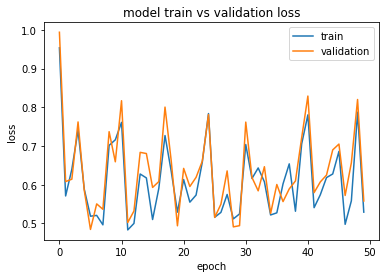

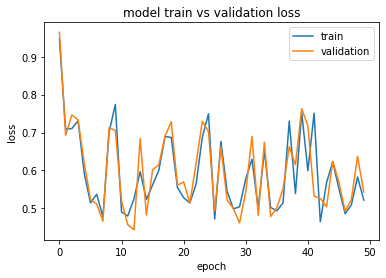

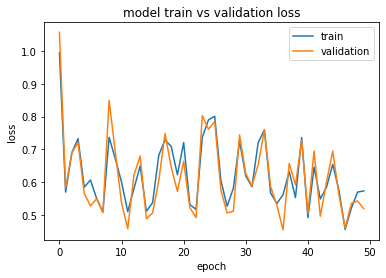

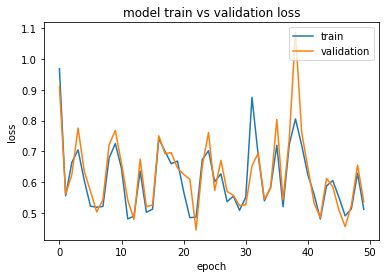

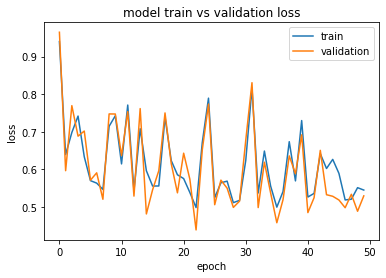

In [12]:
# plot train and validation loss
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

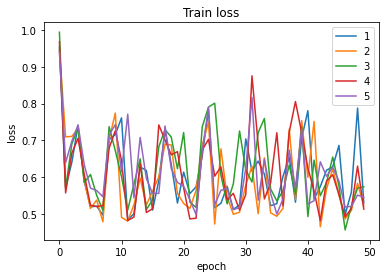

In [13]:
plt.plot(lloogg_1['train']['epoch'], lloogg_1['train']['loss'])
plt.plot(lloogg_2['train']['epoch'], lloogg_2['train']['loss'])
plt.plot(lloogg_3['train']['epoch'], lloogg_3['train']['loss'])
plt.plot(lloogg_4['train']['epoch'], lloogg_4['train']['loss'])
plt.plot(lloogg_5['train']['epoch'], lloogg_5['train']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

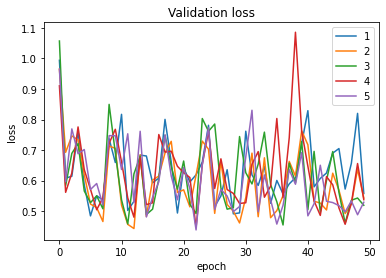

In [14]:
plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.plot(lloogg_2['val']['epoch'], lloogg_2['val']['loss'])
plt.plot(lloogg_3['val']['epoch'], lloogg_3['val']['loss'])
plt.plot(lloogg_4['val']['epoch'], lloogg_4['val']['loss'])
plt.plot(lloogg_5['val']['epoch'], lloogg_5['val']['loss'])
# plt.plot(lloogg_1['val']['epoch'], lloogg_1['val']['loss'])
plt.title('Validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['1','2','3','4','5'], loc='upper right')
plt.show()

In [15]:
result_record_f1 = pd.DataFrame.from_dict(data=result_f1, orient='index')
result_record_f1 = np.mean(np.array(result_record_f1), axis = 0)
result_record_f1 = result_record_f1.reshape(-1)

result_record_acc = pd.DataFrame.from_dict(data=result_acc, orient='index')
result_record_acc = np.mean(np.array(result_record_acc), axis = 0)
result_record_acc = result_record_acc.reshape(-1)

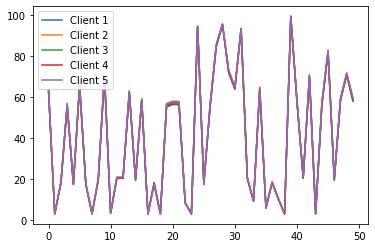

In [16]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_acc[i], label = 'Client '+ str(i+1))
plt.legend()
plt.show()

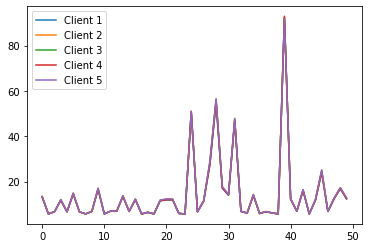

In [17]:
for i in range(client_num):
    plt.plot(np.arange(args.iters), result_f1[i], label =  'Client '+ str(i+1))
plt.legend()
plt.show()